In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

np.random.seed(1234)
tf.random.set_seed(1234)

In [7]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [8]:
sns.set(font_scale=1.6)

In [9]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [10]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))

        return model

    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1+loss_2+loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape
        
        return loss, g, g_u, g_r

        # Compute gradient projections.
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [11]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [12]:
N = 80000

### Train PINN without PCGrad

In [13]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [14]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00005: loss = 0.18346442,4.7452335e-09
Iteration 00010: loss = 0.068424754,4.9039635e-09
Iteration 00015: loss = 0.020643411,5.7194187e-09
Iteration 00020: loss = 0.0067705954,6.5925416e-09
Iteration 00025: loss = 0.0028171672,7.254272e-09
Iteration 00030: loss = 0.0014879837,7.702817e-09
Iteration 00035: loss = 0.0009485364,7.998267e-09
Iteration 00040: loss = 0.0006923361,8.193094e-09
Iteration 00045: loss = 0.00055481546,8.32344e-09
Iteration 00050: loss = 0.00047347663,8.412756e-09
Iteration 00055: loss = 0.0004212712,8.476025e-09
Iteration 00060: loss = 0.00038521548,8.5227825e-09
Iteration 00065: loss = 0.00035857037,8.559086e-09
Iteration 00070: loss = 0.0003376441,8.588776e-09
Iteration 00075: loss = 0.00032031964,8.614282e-09
Iteration 00080: loss = 0.00030535503,8.637134e-09
Iteration 00085: loss = 0.00029201413,8.658292e-09
Iteration 00090: loss = 0.00027984477,8.678355e-09
Iteration 00095: loss = 0.00026856767,8.69769e-09
Iteration 00100: loss = 0.00025801166,8.71

Iteration 00870: loss = 1.2470155e-05,1.0120349e-08
Iteration 00875: loss = 1.233724e-05,1.0125098e-08
Iteration 00880: loss = 1.2206071e-05,1.0129822e-08
Iteration 00885: loss = 1.2077213e-05,1.0134524e-08
Iteration 00890: loss = 1.1950423e-05,1.01392015e-08
Iteration 00895: loss = 1.1824916e-05,1.0143855e-08
Iteration 00900: loss = 1.1702013e-05,1.0148485e-08
Iteration 00905: loss = 1.15805315e-05,1.015309e-08
Iteration 00910: loss = 1.1461222e-05,1.0157674e-08
Iteration 00915: loss = 1.1342906e-05,1.01622355e-08
Iteration 00920: loss = 1.1227089e-05,1.0166775e-08
Iteration 00925: loss = 1.1112606e-05,1.017129e-08
Iteration 00930: loss = 1.1000188e-05,1.01757855e-08
Iteration 00935: loss = 1.0888884e-05,1.01802575e-08
Iteration 00940: loss = 1.0779415e-05,1.0184709e-08
Iteration 00945: loss = 1.0671574e-05,1.0189139e-08
Iteration 00950: loss = 1.0565155e-05,1.0193547e-08
Iteration 00955: loss = 1.0460512e-05,1.0197935e-08
Iteration 00960: loss = 1.0356888e-05,1.0202301e-08
Iteration 

Iteration 01695: loss = 3.3194558e-06,1.0690884e-08
Iteration 01700: loss = 3.2989658e-06,1.06934905e-08
Iteration 01705: loss = 3.2782734e-06,1.0696092e-08
Iteration 01710: loss = 3.2581877e-06,1.0698684e-08
Iteration 01715: loss = 3.2382002e-06,1.0701271e-08
Iteration 01720: loss = 3.2182088e-06,1.0703851e-08
Iteration 01725: loss = 3.1984164e-06,1.0706423e-08
Iteration 01730: loss = 3.1791212e-06,1.0708988e-08
Iteration 01735: loss = 3.1594202e-06,1.0711548e-08
Iteration 01740: loss = 3.140113e-06,1.0714102e-08
Iteration 01745: loss = 3.1212942e-06,1.0716649e-08
Iteration 01750: loss = 3.102269e-06,1.0719191e-08
Iteration 01755: loss = 3.083632e-06,1.0721725e-08
Iteration 01760: loss = 3.0647898e-06,1.0724253e-08
Iteration 01765: loss = 3.0463323e-06,1.0726774e-08
Iteration 01770: loss = 3.028157e-06,1.07292895e-08
Iteration 01775: loss = 3.009969e-06,1.0731799e-08
Iteration 01780: loss = 2.9919663e-06,1.0734302e-08
Iteration 01785: loss = 2.9741448e-06,1.07368e-08
Iteration 01790: 

Iteration 02500: loss = 1.4058822e-06,1.1044225e-08
Iteration 02505: loss = 1.3993053e-06,1.1046101e-08
Iteration 02510: loss = 1.3927526e-06,1.1047974e-08
Iteration 02515: loss = 1.386421e-06,1.1049845e-08
Iteration 02520: loss = 1.3800453e-06,1.1051712e-08
Iteration 02525: loss = 1.3736923e-06,1.1053576e-08
Iteration 02530: loss = 1.3673622e-06,1.1055439e-08
Iteration 02535: loss = 1.3610543e-06,1.1057296e-08
Iteration 02540: loss = 1.3548348e-06,1.1059152e-08
Iteration 02545: loss = 1.3485725e-06,1.10610054e-08
Iteration 02550: loss = 1.342331e-06,1.1062854e-08
Iteration 02555: loss = 1.3362414e-06,1.1064701e-08
Iteration 02560: loss = 1.3301081e-06,1.1066547e-08
Iteration 02565: loss = 1.3240614e-06,1.1068387e-08
Iteration 02570: loss = 1.3180357e-06,1.1070226e-08
Iteration 02575: loss = 1.3119021e-06,1.1072062e-08
Iteration 02580: loss = 1.3060472e-06,1.1073896e-08
Iteration 02585: loss = 1.3001483e-06,1.1075725e-08
Iteration 02590: loss = 1.2943339e-06,1.1077551e-08
Iteration 025

Iteration 03330: loss = 6.984873e-07,1.132236e-08
Iteration 03335: loss = 6.9580364e-07,1.1323871e-08
Iteration 03340: loss = 6.9312745e-07,1.132538e-08
Iteration 03345: loss = 6.9045865e-07,1.1326888e-08
Iteration 03350: loss = 6.8779826e-07,1.1328394e-08
Iteration 03355: loss = 6.851447e-07,1.1329898e-08
Iteration 03360: loss = 6.824993e-07,1.13314e-08
Iteration 03365: loss = 6.7986144e-07,1.1332902e-08
Iteration 03370: loss = 6.773232e-07,1.1334402e-08
Iteration 03375: loss = 6.746082e-07,1.1335899e-08
Iteration 03380: loss = 6.721307e-07,1.1337395e-08
Iteration 03385: loss = 6.696143e-07,1.1338891e-08
Iteration 03390: loss = 6.6701347e-07,1.1340383e-08
Iteration 03395: loss = 6.6451133e-07,1.1341875e-08
Iteration 03400: loss = 6.6192524e-07,1.13433645e-08
Iteration 03405: loss = 6.594375e-07,1.1344853e-08
Iteration 03410: loss = 6.5695684e-07,1.1346341e-08
Iteration 03415: loss = 6.543923e-07,1.1347826e-08
Iteration 03420: loss = 6.5192575e-07,1.1349311e-08
Iteration 03425: loss = 

Iteration 04125: loss = 3.9242755e-07,1.15453975e-08
Iteration 04130: loss = 3.9113334e-07,1.1546707e-08
Iteration 04135: loss = 3.8977217e-07,1.1548016e-08
Iteration 04140: loss = 3.884845e-07,1.1549323e-08
Iteration 04145: loss = 3.8712997e-07,1.155063e-08
Iteration 04150: loss = 3.857791e-07,1.1551935e-08
Iteration 04155: loss = 3.844315e-07,1.155324e-08
Iteration 04160: loss = 3.831567e-07,1.1554544e-08
Iteration 04165: loss = 3.8181574e-07,1.1555848e-08
Iteration 04170: loss = 3.8054722e-07,1.1557151e-08
Iteration 04175: loss = 3.7921305e-07,1.1558451e-08
Iteration 04180: loss = 3.7795084e-07,1.1559751e-08
Iteration 04185: loss = 3.766231e-07,1.1561051e-08
Iteration 04190: loss = 3.7536725e-07,1.15623475e-08
Iteration 04195: loss = 3.7404598e-07,1.1563646e-08
Iteration 04200: loss = 3.7289905e-07,1.1564942e-08
Iteration 04205: loss = 3.7165253e-07,1.1566238e-08
Iteration 04210: loss = 3.703408e-07,1.1567533e-08
Iteration 04215: loss = 3.6910015e-07,1.1568825e-08
Iteration 04220: l

Iteration 04955: loss = 2.276799e-07,1.1751023e-08
Iteration 04960: loss = 2.2695762e-07,1.1752199e-08
Iteration 04965: loss = 2.2623708e-07,1.1753375e-08
Iteration 04970: loss = 2.2551812e-07,1.1754549e-08
Iteration 04975: loss = 2.2480076e-07,1.1755722e-08
Iteration 04980: loss = 2.2411167e-07,1.1756897e-08
Iteration 04985: loss = 2.2345041e-07,1.175807e-08
Iteration 04990: loss = 2.2273788e-07,1.17592425e-08
Iteration 04995: loss = 2.220268e-07,1.1760414e-08
Iteration 05000: loss = 2.2137016e-07,1.17615855e-08
Iteration 05005: loss = 2.2066222e-07,1.1762755e-08
Iteration 05010: loss = 2.1995602e-07,1.1763925e-08
Iteration 05015: loss = 2.1925119e-07,1.1765093e-08
Iteration 05020: loss = 2.1860053e-07,1.17662635e-08
Iteration 05025: loss = 2.1789877e-07,1.1767431e-08
Iteration 05030: loss = 2.1719866e-07,1.1768598e-08
Iteration 05035: loss = 2.1650025e-07,1.1769764e-08
Iteration 05040: loss = 2.1585545e-07,1.1770929e-08
Iteration 05045: loss = 2.1521203e-07,1.1772094e-08
Iteration 05

Iteration 05775: loss = 1.3789271e-07,1.1936085e-08
Iteration 05780: loss = 1.3750535e-07,1.19371695e-08
Iteration 05785: loss = 1.3711879e-07,1.1938255e-08
Iteration 05790: loss = 1.3669153e-07,1.19393375e-08
Iteration 05795: loss = 1.363065e-07,1.194042e-08
Iteration 05800: loss = 1.3588105e-07,1.1941505e-08
Iteration 05805: loss = 1.3545647e-07,1.1942587e-08
Iteration 05810: loss = 1.350739e-07,1.194367e-08
Iteration 05815: loss = 1.3469227e-07,1.1944751e-08
Iteration 05820: loss = 1.3429083e-07,1.1945833e-08
Iteration 05825: loss = 1.339106e-07,1.1946913e-08
Iteration 05830: loss = 1.334903e-07,1.1947995e-08
Iteration 05835: loss = 1.3311175e-07,1.1949074e-08
Iteration 05840: loss = 1.3273399e-07,1.1950154e-08
Iteration 05845: loss = 1.323162e-07,1.1951233e-08
Iteration 05850: loss = 1.3194011e-07,1.1952311e-08
Iteration 05855: loss = 1.3152402e-07,1.1953389e-08
Iteration 05860: loss = 1.3114949e-07,1.1954466e-08
Iteration 05865: loss = 1.3077565e-07,1.1955544e-08
Iteration 05870: 

Iteration 06625: loss = 8.41648e-08,1.2114371e-08
Iteration 06630: loss = 8.388932e-08,1.2115386e-08
Iteration 06635: loss = 8.367926e-08,1.21164e-08
Iteration 06640: loss = 8.343729e-08,1.2117415e-08
Iteration 06645: loss = 8.3195715e-08,1.2118429e-08
Iteration 06650: loss = 8.298692e-08,1.21194415e-08
Iteration 06655: loss = 8.274626e-08,1.2120456e-08
Iteration 06660: loss = 8.250612e-08,1.212147e-08
Iteration 06665: loss = 8.2234266e-08,1.2122481e-08
Iteration 06670: loss = 8.202727e-08,1.2123494e-08
Iteration 06675: loss = 8.178853e-08,1.2124506e-08
Iteration 06680: loss = 8.155024e-08,1.2125517e-08
Iteration 06685: loss = 8.134446e-08,1.2126527e-08
Iteration 06690: loss = 8.110711e-08,1.2127537e-08
Iteration 06695: loss = 8.087019e-08,1.2128547e-08
Iteration 06700: loss = 8.066562e-08,1.212956e-08
Iteration 06705: loss = 8.042966e-08,1.21305685e-08
Iteration 06710: loss = 8.016238e-08,1.2131577e-08
Iteration 06715: loss = 7.995907e-08,1.2132586e-08
Iteration 06720: loss = 7.972449

Iteration 07445: loss = 5.314676e-08,1.2276198e-08
Iteration 07450: loss = 5.3019992e-08,1.2277159e-08
Iteration 07455: loss = 5.2867716e-08,1.2278117e-08
Iteration 07460: loss = 5.2715688e-08,1.2279077e-08
Iteration 07465: loss = 5.2589687e-08,1.2280037e-08
Iteration 07470: loss = 5.2438192e-08,1.2280995e-08
Iteration 07475: loss = 5.228703e-08,1.2281954e-08
Iteration 07480: loss = 5.216175e-08,1.22829125e-08
Iteration 07485: loss = 5.2011142e-08,1.228387e-08
Iteration 07490: loss = 5.1860784e-08,1.2284828e-08
Iteration 07495: loss = 5.1736226e-08,1.2285785e-08
Iteration 07500: loss = 5.158645e-08,1.2286742e-08
Iteration 07505: loss = 5.1411543e-08,1.22877e-08
Iteration 07510: loss = 5.1287756e-08,1.22886545e-08
Iteration 07515: loss = 5.1138812e-08,1.2289613e-08
Iteration 07520: loss = 5.101555e-08,1.2290567e-08
Iteration 07525: loss = 5.086713e-08,1.22915225e-08
Iteration 07530: loss = 5.0719052e-08,1.2292478e-08
Iteration 07535: loss = 5.0596483e-08,1.2293434e-08
Iteration 07540: l

Iteration 08260: loss = 3.410868e-08,1.2428613e-08
Iteration 08265: loss = 3.401577e-08,1.2429522e-08
Iteration 08270: loss = 3.3923026e-08,1.2430434e-08
Iteration 08275: loss = 3.3851098e-08,1.2431343e-08
Iteration 08280: loss = 3.3738104e-08,1.24322534e-08
Iteration 08285: loss = 3.3666442e-08,1.2433162e-08
Iteration 08290: loss = 3.3574377e-08,1.243407e-08
Iteration 08295: loss = 3.346196e-08,1.2434981e-08
Iteration 08300: loss = 3.339075e-08,1.2435887e-08
Iteration 08305: loss = 3.3299187e-08,1.24367965e-08
Iteration 08310: loss = 3.3187362e-08,1.2437704e-08
Iteration 08315: loss = 3.3116585e-08,1.243861e-08
Iteration 08320: loss = 3.302553e-08,1.2439518e-08
Iteration 08325: loss = 3.2955004e-08,1.2440425e-08
Iteration 08330: loss = 3.284394e-08,1.24413315e-08
Iteration 08335: loss = 3.275342e-08,1.24422375e-08
Iteration 08340: loss = 3.2683314e-08,1.2443142e-08
Iteration 08345: loss = 3.2572853e-08,1.24440485e-08
Iteration 08350: loss = 3.250301e-08,1.24449535e-08
Iteration 08355:

Iteration 09080: loss = 2.2056554e-08,1.2573878e-08
Iteration 09085: loss = 2.198714e-08,1.2574739e-08
Iteration 09090: loss = 2.1934488e-08,1.25755975e-08
Iteration 09095: loss = 2.1881911e-08,1.2576457e-08
Iteration 09100: loss = 2.1796305e-08,1.2577317e-08
Iteration 09105: loss = 2.1743958e-08,1.2578176e-08
Iteration 09110: loss = 2.169169e-08,1.2579035e-08
Iteration 09115: loss = 2.1639515e-08,1.2579893e-08
Iteration 09120: loss = 2.157096e-08,1.2580751e-08
Iteration 09125: loss = 2.151898e-08,1.2581609e-08
Iteration 09130: loss = 2.1467102e-08,1.2582467e-08
Iteration 09135: loss = 2.1415303e-08,1.2583323e-08
Iteration 09140: loss = 2.1347203e-08,1.2584181e-08
Iteration 09145: loss = 2.1295614e-08,1.2585039e-08
Iteration 09150: loss = 2.1244096e-08,1.2585895e-08
Iteration 09155: loss = 2.1192688e-08,1.25867485e-08
Iteration 09160: loss = 2.1125063e-08,1.2587606e-08
Iteration 09165: loss = 2.1073843e-08,1.2588461e-08
Iteration 09170: loss = 2.102272e-08,1.2589316e-08
Iteration 09175

Iteration 09875: loss = 1.4553943e-08,1.2706609e-08
Iteration 09880: loss = 1.45277985e-08,1.2707419e-08
Iteration 09885: loss = 1.4488182e-08,1.2708226e-08
Iteration 09890: loss = 1.4448653e-08,1.2709032e-08
Iteration 09895: loss = 1.4409189e-08,1.2709841e-08
Iteration 09900: loss = 1.4369806e-08,1.27106485e-08
Iteration 09905: loss = 1.4330481e-08,1.2711455e-08
Iteration 09910: loss = 1.4304628e-08,1.27122615e-08
Iteration 09915: loss = 1.4265445e-08,1.2713066e-08
Iteration 09920: loss = 1.4226322e-08,1.2713873e-08
Iteration 09925: loss = 1.41872745e-08,1.2714677e-08
Iteration 09930: loss = 1.4148291e-08,1.2715482e-08
Iteration 09935: loss = 1.4122706e-08,1.2716287e-08
Iteration 09940: loss = 1.4083849e-08,1.2717092e-08
Iteration 09945: loss = 1.4045059e-08,1.2717896e-08
Iteration 09950: loss = 1.4006345e-08,1.2718699e-08
Iteration 09955: loss = 1.3967696e-08,1.2719502e-08
Iteration 09960: loss = 1.39423575e-08,1.2720303e-08
Iteration 09965: loss = 1.3903832e-08,1.2721107e-08
Iterati

Iteration 10675: loss = 9.669823e-09,1.2831109e-08
Iteration 10680: loss = 9.6505905e-09,1.2831853e-08
Iteration 10685: loss = 9.620385e-09,1.2832598e-08
Iteration 10690: loss = 9.590239e-09,1.28333415e-08
Iteration 10695: loss = 9.582099e-09,1.2834085e-08
Iteration 10700: loss = 9.552031e-09,1.2834831e-08
Iteration 10705: loss = 9.532967e-09,1.28355735e-08
Iteration 10710: loss = 9.503006e-09,1.2836317e-08
Iteration 10715: loss = 9.4731005e-09,1.28370585e-08
Iteration 10720: loss = 9.465062e-09,1.2837801e-08
Iteration 10725: loss = 9.435233e-09,1.2838542e-08
Iteration 10730: loss = 9.4054675e-09,1.2839283e-08
Iteration 10735: loss = 9.3866195e-09,1.2840023e-08
Iteration 10740: loss = 9.35695e-09,1.2840765e-08
Iteration 10745: loss = 9.33818e-09,1.2841505e-08
Iteration 10750: loss = 9.31943e-09,1.2842244e-08
Iteration 10755: loss = 9.2899e-09,1.28429845e-08
Iteration 10760: loss = 9.260431e-09,1.28437225e-08
Iteration 10765: loss = 9.241803e-09,1.284446e-08
Iteration 10770: loss = 9.22

Iteration 11485: loss = 6.453005e-09,1.2945755e-08
Iteration 11490: loss = 6.4296546e-09,1.2946422e-08
Iteration 11495: loss = 6.415334e-09,1.2947088e-08
Iteration 11500: loss = 6.401034e-09,1.2947753e-08
Iteration 11505: loss = 6.377801e-09,1.2948418e-08
Iteration 11510: loss = 6.3725083e-09,1.2949084e-08
Iteration 11515: loss = 6.349337e-09,1.2949746e-08
Iteration 11520: loss = 6.3351453e-09,1.2950409e-08
Iteration 11525: loss = 6.3209717e-09,1.2951072e-08
Iteration 11530: loss = 6.306825e-09,1.2951734e-08
Iteration 11535: loss = 6.2838055e-09,1.2952396e-08
Iteration 11540: loss = 6.2786008e-09,1.2953056e-08
Iteration 11545: loss = 6.2556467e-09,1.2953716e-08
Iteration 11550: loss = 6.2416006e-09,1.2954376e-08
Iteration 11555: loss = 6.2275767e-09,1.2955036e-08
Iteration 11560: loss = 6.2135803e-09,1.2955693e-08
Iteration 11565: loss = 6.199603e-09,1.2956351e-08
Iteration 11570: loss = 6.1856493e-09,1.2957009e-08
Iteration 11575: loss = 6.1629137e-09,1.2957667e-08
Iteration 11580: lo

Iteration 12295: loss = 4.336458e-09,1.3045851e-08
Iteration 12300: loss = 4.3329544e-09,1.3046414e-08
Iteration 12305: loss = 4.322087e-09,1.3046979e-08
Iteration 12310: loss = 4.3112394e-09,1.3047541e-08
Iteration 12315: loss = 4.3004094e-09,1.3048102e-08
Iteration 12320: loss = 4.2822594e-09,1.30486635e-08
Iteration 12325: loss = 4.278801e-09,1.3049224e-08
Iteration 12330: loss = 4.260708e-09,1.3049784e-08
Iteration 12335: loss = 4.257268e-09,1.3050344e-08
Iteration 12340: loss = 4.246531e-09,1.3050901e-08
Iteration 12345: loss = 4.2358104e-09,1.3051459e-08
Iteration 12350: loss = 4.225108e-09,1.3052017e-08
Iteration 12355: loss = 4.214423e-09,1.3052574e-08
Iteration 12360: loss = 4.203759e-09,1.305313e-08
Iteration 12365: loss = 4.193112e-09,1.3053684e-08
Iteration 12370: loss = 4.182482e-09,1.3054238e-08
Iteration 12375: loss = 4.179115e-09,1.3054793e-08
Iteration 12380: loss = 4.168513e-09,1.3055344e-08
Iteration 12385: loss = 4.157927e-09,1.3055896e-08
Iteration 12390: loss = 4.

Iteration 13135: loss = 2.912347e-09,1.31296005e-08
Iteration 13140: loss = 2.9100782e-09,1.3130025e-08
Iteration 13145: loss = 2.9017768e-09,1.3130449e-08
Iteration 13150: loss = 2.8934906e-09,1.3130871e-08
Iteration 13155: loss = 2.8912401e-09,1.3131295e-08
Iteration 13160: loss = 2.8769642e-09,1.3131716e-08
Iteration 13165: loss = 2.8747256e-09,1.3132137e-08
Iteration 13170: loss = 2.8724931e-09,1.3132556e-08
Iteration 13175: loss = 2.8582712e-09,1.31329765e-08
Iteration 13180: loss = 2.8560505e-09,1.3133393e-08
Iteration 13185: loss = 2.8538338e-09,1.3133809e-08
Iteration 13190: loss = 2.8396665e-09,1.31342235e-08
Iteration 13195: loss = 2.8374634e-09,1.313464e-08
Iteration 13200: loss = 2.8292997e-09,1.3135053e-08
Iteration 13205: loss = 2.8211533e-09,1.3135466e-08
Iteration 13210: loss = 2.8189673e-09,1.3135877e-08
Iteration 13215: loss = 2.8108398e-09,1.31362885e-08
Iteration 13220: loss = 2.802729e-09,1.3136697e-08
Iteration 13225: loss = 2.7946312e-09,1.31371065e-08
Iteration 

Iteration 13940: loss = 2.0253763e-09,1.3184755e-08
Iteration 13945: loss = 2.0188407e-09,1.3185006e-08
Iteration 13950: loss = 2.0123176e-09,1.31852556e-08
Iteration 13955: loss = 2.0108235e-09,1.3185504e-08
Iteration 13960: loss = 2.0043176e-09,1.3185752e-08
Iteration 13965: loss = 1.997824e-09,1.3185999e-08
Iteration 13970: loss = 1.9963429e-09,1.3186244e-08
Iteration 13975: loss = 1.9948645e-09,1.31864875e-08
Iteration 13980: loss = 1.9834048e-09,1.3186732e-08
Iteration 13985: loss = 1.9819344e-09,1.3186972e-08
Iteration 13990: loss = 1.9804682e-09,1.3187213e-08
Iteration 13995: loss = 1.9690558e-09,1.3187452e-08
Iteration 14000: loss = 1.9675968e-09,1.3187691e-08
Iteration 14005: loss = 1.9661408e-09,1.3187925e-08
Iteration 14010: loss = 1.9646895e-09,1.3188162e-08
Iteration 14015: loss = 1.95333e-09,1.3188394e-08
Iteration 14020: loss = 1.951884e-09,1.3188627e-08
Iteration 14025: loss = 1.9504436e-09,1.3188858e-08
Iteration 14030: loss = 1.9440647e-09,1.3189088e-08
Iteration 1403

Iteration 14740: loss = 1.4337461e-09,1.3208048e-08
Iteration 14745: loss = 1.4285183e-09,1.3208077e-08
Iteration 14750: loss = 1.4275213e-09,1.3208107e-08
Iteration 14755: loss = 1.4223085e-09,1.3208131e-08
Iteration 14760: loss = 1.4213173e-09,1.3208156e-08
Iteration 14765: loss = 1.4161178e-09,1.3208181e-08
Iteration 14770: loss = 1.4151321e-09,1.32082025e-08
Iteration 14775: loss = 1.4099472e-09,1.3208224e-08
Iteration 14780: loss = 1.4089666e-09,1.3208242e-08
Iteration 14785: loss = 1.4037962e-09,1.3208259e-08
Iteration 14790: loss = 1.4028209e-09,1.3208275e-08
Iteration 14795: loss = 1.3976645e-09,1.32082905e-08
Iteration 14800: loss = 1.3966943e-09,1.3208304e-08
Iteration 14805: loss = 1.3957271e-09,1.3208314e-08
Iteration 14810: loss = 1.3905884e-09,1.3208324e-08
Iteration 14815: loss = 1.3854619e-09,1.3208332e-08
Iteration 14820: loss = 1.3845013e-09,1.32083375e-08
Iteration 14825: loss = 1.3835435e-09,1.3208343e-08
Iteration 14830: loss = 1.3784325e-09,1.3208346e-08
Iteration

Iteration 15540: loss = 1.0364051e-09,1.31916345e-08
Iteration 15545: loss = 1.0357416e-09,1.3191387e-08
Iteration 15550: loss = 1.0350812e-09,1.3191139e-08
Iteration 15555: loss = 1.0308349e-09,1.3190886e-08
Iteration 15560: loss = 1.0301768e-09,1.3190635e-08
Iteration 15565: loss = 1.0295204e-09,1.31903795e-08
Iteration 15570: loss = 1.0252891e-09,1.3190123e-08
Iteration 15575: loss = 1.0246363e-09,1.3189864e-08
Iteration 15580: loss = 1.0239849e-09,1.3189605e-08
Iteration 15585: loss = 1.0197684e-09,1.3189343e-08
Iteration 15590: loss = 1.0191202e-09,1.3189078e-08
Iteration 15595: loss = 1.0149167e-09,1.3188814e-08
Iteration 15600: loss = 1.0142721e-09,1.3188545e-08
Iteration 15605: loss = 1.0136288e-09,1.3188275e-08
Iteration 15610: loss = 1.0094396e-09,1.3188003e-08
Iteration 15615: loss = 1.0088e-09,1.3187728e-08
Iteration 15620: loss = 1.0081617e-09,1.3187452e-08
Iteration 15625: loss = 1.0039871e-09,1.3187176e-08
Iteration 15630: loss = 1.0033524e-09,1.3186896e-08
Iteration 156

Iteration 16340: loss = 7.7545176e-10,1.3126229e-08
Iteration 16345: loss = 7.7501366e-10,1.3125645e-08
Iteration 16350: loss = 7.714833e-10,1.31250575e-08
Iteration 16355: loss = 7.7104817e-10,1.3124469e-08
Iteration 16360: loss = 7.706133e-10,1.3123877e-08
Iteration 16365: loss = 7.701795e-10,1.3123286e-08
Iteration 16370: loss = 7.666628e-10,1.312269e-08
Iteration 16375: loss = 7.6623174e-10,1.3122093e-08
Iteration 16380: loss = 7.658017e-10,1.3121492e-08
Iteration 16385: loss = 7.622982e-10,1.3120891e-08
Iteration 16390: loss = 7.6187057e-10,1.3120285e-08
Iteration 16395: loss = 7.614454e-10,1.3119678e-08
Iteration 16400: loss = 7.6101925e-10,1.3119068e-08
Iteration 16405: loss = 7.605944e-10,1.3118457e-08
Iteration 16410: loss = 7.5710566e-10,1.3117844e-08
Iteration 16415: loss = 7.5362844e-10,1.3117227e-08
Iteration 16420: loss = 7.5320766e-10,1.3116608e-08
Iteration 16425: loss = 7.527879e-10,1.3115986e-08
Iteration 16430: loss = 7.523697e-10,1.3115361e-08
Iteration 16435: loss 

Iteration 17185: loss = 5.940493e-10,1.2992534e-08
Iteration 17190: loss = 5.9107613e-10,1.2991521e-08
Iteration 17195: loss = 5.907998e-10,1.2990502e-08
Iteration 17200: loss = 5.905249e-10,1.29894815e-08
Iteration 17205: loss = 5.902502e-10,1.2988457e-08
Iteration 17210: loss = 5.899758e-10,1.2987431e-08
Iteration 17215: loss = 5.8970184e-10,1.2986404e-08
Iteration 17220: loss = 5.8942823e-10,1.29853746e-08
Iteration 17225: loss = 5.864696e-10,1.298434e-08
Iteration 17230: loss = 5.835218e-10,1.2983303e-08
Iteration 17235: loss = 5.832516e-10,1.2982263e-08
Iteration 17240: loss = 5.8298294e-10,1.2981219e-08
Iteration 17245: loss = 5.8271504e-10,1.29801725e-08
Iteration 17250: loss = 5.824476e-10,1.2979122e-08
Iteration 17255: loss = 5.8218075e-10,1.297807e-08
Iteration 17260: loss = 5.819136e-10,1.2977017e-08
Iteration 17265: loss = 5.816472e-10,1.297596e-08
Iteration 17270: loss = 5.787135e-10,1.2974905e-08
Iteration 17275: loss = 5.784482e-10,1.2973843e-08
Iteration 17280: loss = 5

Iteration 18000: loss = 4.81199e-10,1.2787892e-08
Iteration 18005: loss = 4.8102683e-10,1.2786378e-08
Iteration 18010: loss = 4.8085513e-10,1.2784862e-08
Iteration 18015: loss = 4.806837e-10,1.2783344e-08
Iteration 18020: loss = 4.781014e-10,1.2781821e-08
Iteration 18025: loss = 4.7793164e-10,1.2780293e-08
Iteration 18030: loss = 4.7536103e-10,1.2778762e-08
Iteration 18035: loss = 4.7519394e-10,1.2777225e-08
Iteration 18040: loss = 4.750274e-10,1.27756845e-08
Iteration 18045: loss = 4.7486165e-10,1.277414e-08
Iteration 18050: loss = 4.7469645e-10,1.2772592e-08
Iteration 18055: loss = 4.7453125e-10,1.2771041e-08
Iteration 18060: loss = 4.7436644e-10,1.2769488e-08
Iteration 18065: loss = 4.742022e-10,1.2767932e-08
Iteration 18070: loss = 4.7164567e-10,1.2766372e-08
Iteration 18075: loss = 4.714818e-10,1.2764809e-08
Iteration 18080: loss = 4.713188e-10,1.2763242e-08
Iteration 18085: loss = 4.7115667e-10,1.27616735e-08
Iteration 18090: loss = 4.7099435e-10,1.27601e-08
Iteration 18095: loss

Iteration 18830: loss = 4.0859607e-10,1.2487298e-08
Iteration 18835: loss = 4.0850248e-10,1.24851685e-08
Iteration 18840: loss = 4.0840928e-10,1.2483033e-08
Iteration 18845: loss = 4.0831624e-10,1.24808945e-08
Iteration 18850: loss = 4.082238e-10,1.2478752e-08
Iteration 18855: loss = 4.0813095e-10,1.2476606e-08
Iteration 18860: loss = 4.058364e-10,1.2474457e-08
Iteration 18865: loss = 4.0574577e-10,1.2472301e-08
Iteration 18870: loss = 4.056555e-10,1.2470141e-08
Iteration 18875: loss = 4.0556591e-10,1.2467975e-08
Iteration 18880: loss = 4.0547699e-10,1.2465806e-08
Iteration 18885: loss = 4.0538786e-10,1.2463634e-08
Iteration 18890: loss = 4.052995e-10,1.2461457e-08
Iteration 18895: loss = 4.0521084e-10,1.24592745e-08
Iteration 18900: loss = 4.0512296e-10,1.2457091e-08
Iteration 18905: loss = 4.0503464e-10,1.2454904e-08
Iteration 18910: loss = 4.0494666e-10,1.2452713e-08
Iteration 18915: loss = 4.0485829e-10,1.2450519e-08
Iteration 18920: loss = 4.0477025e-10,1.2448323e-08
Iteration 189

Iteration 19645: loss = 3.7007328e-10,1.2084328e-08
Iteration 19650: loss = 3.700373e-10,1.2081488e-08
Iteration 19655: loss = 3.7000147e-10,1.2078644e-08
Iteration 19660: loss = 3.6996514e-10,1.2075796e-08
Iteration 19665: loss = 3.699294e-10,1.20729435e-08
Iteration 19670: loss = 3.6989375e-10,1.2070087e-08
Iteration 19675: loss = 3.677789e-10,1.2067225e-08
Iteration 19680: loss = 3.6774495e-10,1.2064357e-08
Iteration 19685: loss = 3.6771183e-10,1.2061483e-08
Iteration 19690: loss = 3.6767903e-10,1.2058604e-08
Iteration 19695: loss = 3.6764658e-10,1.2055721e-08
Iteration 19700: loss = 3.676142e-10,1.2052833e-08
Iteration 19705: loss = 3.6758188e-10,1.20499415e-08
Iteration 19710: loss = 3.675499e-10,1.2047045e-08
Iteration 19715: loss = 3.675179e-10,1.2044145e-08
Iteration 19720: loss = 3.6748574e-10,1.2041241e-08
Iteration 19725: loss = 3.6745348e-10,1.2038333e-08
Iteration 19730: loss = 3.6742143e-10,1.20354215e-08
Iteration 19735: loss = 3.6738923e-10,1.2032505e-08
Iteration 19740

Iteration 20490: loss = 3.529208e-10,1.1539839e-08
Iteration 20495: loss = 3.529251e-10,1.1536223e-08
Iteration 20500: loss = 3.5293093e-10,1.1532598e-08
Iteration 20505: loss = 3.5293712e-10,1.152897e-08
Iteration 20510: loss = 3.5294337e-10,1.1525336e-08
Iteration 20515: loss = 3.5294997e-10,1.1521698e-08
Iteration 20520: loss = 3.5295677e-10,1.1518056e-08
Iteration 20525: loss = 3.5296363e-10,1.1514411e-08
Iteration 20530: loss = 3.5297032e-10,1.1510759e-08
Iteration 20535: loss = 3.5297734e-10,1.1507105e-08
Iteration 20540: loss = 3.5298442e-10,1.1503446e-08
Iteration 20545: loss = 3.5299152e-10,1.1499783e-08
Iteration 20550: loss = 3.5299866e-10,1.1496116e-08
Iteration 20555: loss = 3.5300587e-10,1.1492444e-08
Iteration 20560: loss = 3.5301315e-10,1.1488767e-08
Iteration 20565: loss = 3.5302042e-10,1.1485088e-08
Iteration 20570: loss = 3.5302805e-10,1.1481404e-08
Iteration 20575: loss = 3.5303546e-10,1.14777166e-08
Iteration 20580: loss = 3.530429e-10,1.1474023e-08
Iteration 20585

Iteration 21300: loss = 3.5321987e-10,1.0899672e-08
Iteration 21305: loss = 3.5324033e-10,1.0895411e-08
Iteration 21310: loss = 3.5326084e-10,1.0891144e-08
Iteration 21315: loss = 3.5328193e-10,1.0886874e-08
Iteration 21320: loss = 3.5330225e-10,1.08826015e-08
Iteration 21325: loss = 3.5332368e-10,1.0878327e-08
Iteration 21330: loss = 3.5334427e-10,1.08740466e-08
Iteration 21335: loss = 3.5336553e-10,1.0869763e-08
Iteration 21340: loss = 3.5338654e-10,1.08654765e-08
Iteration 21345: loss = 3.5340655e-10,1.0861189e-08
Iteration 21350: loss = 3.5342607e-10,1.0856899e-08
Iteration 21355: loss = 3.5344516e-10,1.0852608e-08
Iteration 21360: loss = 3.5346417e-10,1.0848313e-08
Iteration 21365: loss = 3.5348272e-10,1.0844016e-08
Iteration 21370: loss = 3.5350192e-10,1.0839716e-08
Iteration 21375: loss = 3.5352057e-10,1.0835412e-08
Iteration 21380: loss = 3.5353934e-10,1.0831105e-08
Iteration 21385: loss = 3.535586e-10,1.0826795e-08
Iteration 21390: loss = 3.5357742e-10,1.0822481e-08
Iteration 

Iteration 22105: loss = 3.5638267e-10,1.0176771e-08
Iteration 22110: loss = 3.5840833e-10,1.0172105e-08
Iteration 22115: loss = 3.5841663e-10,1.0167447e-08
Iteration 22120: loss = 3.5842218e-10,1.0162793e-08
Iteration 22125: loss = 3.5842673e-10,1.0158142e-08
Iteration 22130: loss = 3.584302e-10,1.01534905e-08
Iteration 22135: loss = 3.584332e-10,1.0148836e-08
Iteration 22140: loss = 3.5843592e-10,1.0144183e-08
Iteration 22145: loss = 3.584387e-10,1.0139528e-08
Iteration 22150: loss = 3.5642855e-10,1.0134871e-08
Iteration 22155: loss = 3.5643655e-10,1.01302e-08
Iteration 22160: loss = 3.5644676e-10,1.0125517e-08
Iteration 22165: loss = 3.5645972e-10,1.0120831e-08
Iteration 22170: loss = 3.5647327e-10,1.0116141e-08
Iteration 22175: loss = 3.564873e-10,1.0111448e-08
Iteration 22180: loss = 3.565018e-10,1.0106749e-08
Iteration 22185: loss = 3.5651682e-10,1.010205e-08
Iteration 22190: loss = 3.5653183e-10,1.0097349e-08
Iteration 22195: loss = 3.5654665e-10,1.0092647e-08
Iteration 22200: lo

Iteration 22975: loss = 3.576072e-10,9.347984e-09
Iteration 22980: loss = 3.5760647e-10,9.343182e-09
Iteration 22985: loss = 3.5760525e-10,9.3383825e-09
Iteration 22990: loss = 3.576043e-10,9.333581e-09
Iteration 22995: loss = 3.5760261e-10,9.32878e-09
Iteration 23000: loss = 3.576012e-10,9.3239825e-09
Iteration 23005: loss = 3.5759987e-10,9.319183e-09
Iteration 23010: loss = 3.575982e-10,9.314384e-09
Iteration 23015: loss = 3.5759615e-10,9.309585e-09
Iteration 23020: loss = 3.5759407e-10,9.304786e-09
Iteration 23025: loss = 3.5759182e-10,9.299988e-09
Iteration 23030: loss = 3.5758954e-10,9.29519e-09
Iteration 23035: loss = 3.5758707e-10,9.290394e-09
Iteration 23040: loss = 3.5758432e-10,9.285598e-09
Iteration 23045: loss = 3.5758196e-10,9.280802e-09
Iteration 23050: loss = 3.5757877e-10,9.2760075e-09
Iteration 23055: loss = 3.5757586e-10,9.271212e-09
Iteration 23060: loss = 3.5757253e-10,9.266417e-09
Iteration 23065: loss = 3.575692e-10,9.2616235e-09
Iteration 23070: loss = 3.575659e-

Iteration 23785: loss = 3.579478e-10,8.581322e-09
Iteration 23790: loss = 3.579159e-10,8.5767375e-09
Iteration 23795: loss = 3.5788048e-10,8.572163e-09
Iteration 23800: loss = 3.5784342e-10,8.567594e-09
Iteration 23805: loss = 3.578053e-10,8.56303e-09
Iteration 23810: loss = 3.5776673e-10,8.5584695e-09
Iteration 23815: loss = 3.5772763e-10,8.5539105e-09
Iteration 23820: loss = 3.5768866e-10,8.549355e-09
Iteration 23825: loss = 3.5764916e-10,8.544802e-09
Iteration 23830: loss = 3.5760972e-10,8.54025e-09
Iteration 23835: loss = 3.5757172e-10,8.5356975e-09
Iteration 23840: loss = 3.5753644e-10,8.5311385e-09
Iteration 23845: loss = 3.575036e-10,8.526577e-09
Iteration 23850: loss = 3.574723e-10,8.522013e-09
Iteration 23855: loss = 3.5744152e-10,8.51745e-09
Iteration 23860: loss = 3.5741107e-10,8.512887e-09
Iteration 23865: loss = 3.5738068e-10,8.5083265e-09
Iteration 23870: loss = 3.5735084e-10,8.503767e-09
Iteration 23875: loss = 3.573206e-10,8.499209e-09
Iteration 23880: loss = 3.5528017e

Iteration 24645: loss = 3.5179293e-10,7.824451e-09
Iteration 24650: loss = 3.5178016e-10,7.8202795e-09
Iteration 24655: loss = 3.517703e-10,7.816103e-09
Iteration 24660: loss = 3.5176392e-10,7.811923e-09
Iteration 24665: loss = 3.5377143e-10,7.807744e-09
Iteration 24670: loss = 3.5375458e-10,7.803596e-09
Iteration 24675: loss = 3.5372735e-10,7.799478e-09
Iteration 24680: loss = 3.5369474e-10,7.7953795e-09
Iteration 24685: loss = 3.5365752e-10,7.791294e-09
Iteration 24690: loss = 3.536177e-10,7.787218e-09
Iteration 24695: loss = 3.5357708e-10,7.78315e-09
Iteration 24700: loss = 3.5353523e-10,7.779088e-09
Iteration 24705: loss = 3.5349293e-10,7.77503e-09
Iteration 24710: loss = 3.534499e-10,7.770979e-09
Iteration 24715: loss = 3.534066e-10,7.766931e-09
Iteration 24720: loss = 3.533629e-10,7.762888e-09
Iteration 24725: loss = 3.5331893e-10,7.7588505e-09
Iteration 24730: loss = 3.5327477e-10,7.754816e-09
Iteration 24735: loss = 3.5323067e-10,7.750786e-09
Iteration 24740: loss = 3.5318604e-

Iteration 25470: loss = 3.465053e-10,7.1978405e-09
Iteration 25475: loss = 3.4649197e-10,7.1943513e-09
Iteration 25480: loss = 3.464774e-10,7.19087e-09
Iteration 25485: loss = 3.4646153e-10,7.187398e-09
Iteration 25490: loss = 3.4644418e-10,7.183933e-09
Iteration 25495: loss = 3.4843592e-10,7.180483e-09
Iteration 25500: loss = 3.483964e-10,7.1770856e-09
Iteration 25505: loss = 3.483437e-10,7.1737274e-09
Iteration 25510: loss = 3.482826e-10,7.1703936e-09
Iteration 25515: loss = 3.4821668e-10,7.1670776e-09
Iteration 25520: loss = 3.481483e-10,7.1637745e-09
Iteration 25525: loss = 3.480812e-10,7.1604718e-09
Iteration 25530: loss = 3.4801897e-10,7.157161e-09
Iteration 25535: loss = 3.4795963e-10,7.153847e-09
Iteration 25540: loss = 3.4790182e-10,7.150533e-09
Iteration 25545: loss = 3.47845e-10,7.147221e-09
Iteration 25550: loss = 3.4778855e-10,7.143915e-09
Iteration 25555: loss = 3.4773207e-10,7.1406117e-09
Iteration 25560: loss = 3.4767514e-10,7.137315e-09
Iteration 25565: loss = 3.456076

Iteration 26285: loss = 3.404871e-10,6.700365e-09
Iteration 26290: loss = 3.4042436e-10,6.69776e-09
Iteration 26295: loss = 3.403616e-10,6.695161e-09
Iteration 26300: loss = 3.382947e-10,6.692565e-09
Iteration 26305: loss = 3.3825096e-10,6.6899237e-09
Iteration 26310: loss = 3.3822303e-10,6.6872454e-09
Iteration 26315: loss = 3.3820335e-10,6.6845485e-09
Iteration 26320: loss = 3.3818784e-10,6.6818453e-09
Iteration 26325: loss = 3.3817624e-10,6.6791355e-09
Iteration 26330: loss = 3.3817263e-10,6.6764088e-09
Iteration 26335: loss = 3.3817293e-10,6.6736767e-09
Iteration 26340: loss = 3.381686e-10,6.6709607e-09
Iteration 26345: loss = 3.3815742e-10,6.6682695e-09
Iteration 26350: loss = 3.381406e-10,6.665596e-09
Iteration 26355: loss = 3.3812e-10,6.662937e-09
Iteration 26360: loss = 3.3809633e-10,6.660292e-09
Iteration 26365: loss = 3.380699e-10,6.6576575e-09
Iteration 26370: loss = 3.3804104e-10,6.6550347e-09
Iteration 26375: loss = 3.3800993e-10,6.6524213e-09
Iteration 26380: loss = 3.379

Iteration 27100: loss = 3.290509e-10,6.3198566e-09
Iteration 27105: loss = 3.2901382e-10,6.3178636e-09
Iteration 27110: loss = 3.2897476e-10,6.3158794e-09
Iteration 27115: loss = 3.2893463e-10,6.3139014e-09
Iteration 27120: loss = 3.2889225e-10,6.3119328e-09
Iteration 27125: loss = 3.2884817e-10,6.3099748e-09
Iteration 27130: loss = 3.2880243e-10,6.308024e-09
Iteration 27135: loss = 3.2875436e-10,6.3060823e-09
Iteration 27140: loss = 3.2870454e-10,6.304149e-09
Iteration 27145: loss = 3.266961e-10,6.3021757e-09
Iteration 27150: loss = 3.286704e-10,6.3001178e-09
Iteration 27155: loss = 3.2865963e-10,6.298091e-09
Iteration 27160: loss = 3.286277e-10,6.2961245e-09
Iteration 27165: loss = 3.2858213e-10,6.294198e-09
Iteration 27170: loss = 3.2852757e-10,6.292302e-09
Iteration 27175: loss = 3.2846703e-10,6.2904237e-09
Iteration 27180: loss = 3.284022e-10,6.288562e-09
Iteration 27185: loss = 3.2834183e-10,6.286691e-09
Iteration 27190: loss = 3.2828754e-10,6.2848073e-09
Iteration 27195: loss = 

Iteration 27910: loss = 3.1841021e-10,6.0384755e-09
Iteration 27915: loss = 3.183546e-10,6.037067e-09
Iteration 27920: loss = 3.1829672e-10,6.0356666e-09
Iteration 27925: loss = 3.1823907e-10,6.034269e-09
Iteration 27930: loss = 3.1819083e-10,6.032849e-09
Iteration 27935: loss = 3.1814842e-10,6.031416e-09
Iteration 27940: loss = 3.1810854e-10,6.0299787e-09
Iteration 27945: loss = 3.1806888e-10,6.0285426e-09
Iteration 27950: loss = 3.180286e-10,6.0271113e-09
Iteration 27955: loss = 3.1798705e-10,6.025687e-09
Iteration 27960: loss = 3.179441e-10,6.0242695e-09
Iteration 27965: loss = 3.1789882e-10,6.022861e-09
Iteration 27970: loss = 3.1785172e-10,6.0214607e-09
Iteration 27975: loss = 3.1780234e-10,6.020068e-09
Iteration 27980: loss = 3.1775046e-10,6.018686e-09
Iteration 27985: loss = 3.176972e-10,6.0173115e-09
Iteration 27990: loss = 3.1764172e-10,6.0159433e-09
Iteration 27995: loss = 3.1758454e-10,6.0145844e-09
Iteration 28000: loss = 3.1752523e-10,6.013233e-09
Iteration 28005: loss = 3

Iteration 28745: loss = 3.0622488e-10,5.8256697e-09
Iteration 28750: loss = 3.061934e-10,5.8246017e-09
Iteration 28755: loss = 3.0615935e-10,5.823544e-09
Iteration 28760: loss = 3.06122e-10,5.822496e-09
Iteration 28765: loss = 3.0608263e-10,5.821456e-09
Iteration 28770: loss = 3.0604028e-10,5.8204273e-09
Iteration 28775: loss = 3.0599526e-10,5.819407e-09
Iteration 28780: loss = 3.0594813e-10,5.8183947e-09
Iteration 28785: loss = 3.0589878e-10,5.8173906e-09
Iteration 28790: loss = 3.0584682e-10,5.8163954e-09
Iteration 28795: loss = 3.0579336e-10,5.8154064e-09
Iteration 28800: loss = 3.0573763e-10,5.8144263e-09
Iteration 28805: loss = 3.056801e-10,5.813453e-09
Iteration 28810: loss = 3.056207e-10,5.812485e-09
Iteration 28815: loss = 3.0555986e-10,5.8115237e-09
Iteration 28820: loss = 3.0549765e-10,5.8105707e-09
Iteration 28825: loss = 3.0543376e-10,5.8096217e-09
Iteration 28830: loss = 3.0536854e-10,5.80868e-09
Iteration 28835: loss = 3.0530253e-10,5.807742e-09
Iteration 28840: loss = 3.

Iteration 29570: loss = 2.9648065e-10,5.6714846e-09
Iteration 29575: loss = 2.964233e-10,5.6707776e-09
Iteration 29580: loss = 2.9636385e-10,5.670077e-09
Iteration 29585: loss = 2.9630343e-10,5.6693805e-09
Iteration 29590: loss = 2.9624173e-10,5.6686904e-09
Iteration 29595: loss = 2.9429867e-10,5.668003e-09
Iteration 29600: loss = 2.9426203e-10,5.667246e-09
Iteration 29605: loss = 2.942566e-10,5.666407e-09
Iteration 29610: loss = 2.9426664e-10,5.665525e-09
Iteration 29615: loss = 2.9428462e-10,5.6646225e-09
Iteration 29620: loss = 2.9430533e-10,5.6637157e-09
Iteration 29625: loss = 2.9432481e-10,5.662813e-09
Iteration 29630: loss = 2.943416e-10,5.661919e-09
Iteration 29635: loss = 2.943552e-10,5.661035e-09
Iteration 29640: loss = 2.9436428e-10,5.660166e-09
Iteration 29645: loss = 2.9436897e-10,5.6593095e-09
Iteration 29650: loss = 2.943691e-10,5.6584675e-09
Iteration 29655: loss = 2.94365e-10,5.657638e-09
Iteration 29660: loss = 2.9435632e-10,5.6568226e-09
Iteration 29665: loss = 2.943

Iteration 30385: loss = 2.8633249e-10,5.5553633e-09
Iteration 30390: loss = 2.8629296e-10,5.55481e-09
Iteration 30395: loss = 2.8625055e-10,5.5542646e-09
Iteration 30400: loss = 2.8620675e-10,5.5537246e-09
Iteration 30405: loss = 2.8616062e-10,5.5531917e-09
Iteration 30410: loss = 2.86114e-10,5.5526606e-09
Iteration 30415: loss = 2.8607938e-10,5.552099e-09
Iteration 30420: loss = 2.8605504e-10,5.5515113e-09
Iteration 30425: loss = 2.860353e-10,5.5509104e-09
Iteration 30430: loss = 2.8601707e-10,5.550307e-09
Iteration 30435: loss = 2.8599803e-10,5.5497074e-09
Iteration 30440: loss = 2.859782e-10,5.5491096e-09
Iteration 30445: loss = 2.8595615e-10,5.5485208e-09
Iteration 30450: loss = 2.8593158e-10,5.547938e-09
Iteration 30455: loss = 2.8590422e-10,5.5473643e-09
Iteration 30460: loss = 2.858744e-10,5.5467986e-09
Iteration 30465: loss = 2.858426e-10,5.54624e-09
Iteration 30470: loss = 2.8580752e-10,5.5456892e-09
Iteration 30475: loss = 2.857706e-10,5.5451457e-09
Iteration 30480: loss = 2.

Iteration 31215: loss = 2.777402e-10,5.466634e-09
Iteration 31220: loss = 2.7772537e-10,5.4661564e-09
Iteration 31225: loss = 2.7770716e-10,5.4656906e-09
Iteration 31230: loss = 2.7768615e-10,5.465231e-09
Iteration 31235: loss = 2.7766198e-10,5.464782e-09
Iteration 31240: loss = 2.7763547e-10,5.4643396e-09
Iteration 31245: loss = 2.776062e-10,5.463905e-09
Iteration 31250: loss = 2.7757494e-10,5.4634777e-09
Iteration 31255: loss = 2.775413e-10,5.4630567e-09
Iteration 31260: loss = 2.7750535e-10,5.4626423e-09
Iteration 31265: loss = 2.7746797e-10,5.4622333e-09
Iteration 31270: loss = 2.77431e-10,5.4618234e-09
Iteration 31275: loss = 2.7740094e-10,5.4613967e-09
Iteration 31280: loss = 2.773739e-10,5.460961e-09
Iteration 31285: loss = 2.7734762e-10,5.4605236e-09
Iteration 31290: loss = 2.7732086e-10,5.46009e-09
Iteration 31295: loss = 2.7729283e-10,5.459659e-09
Iteration 31300: loss = 2.7726385e-10,5.4592317e-09
Iteration 31305: loss = 2.772327e-10,5.458811e-09
Iteration 31310: loss = 2.77

Iteration 32075: loss = 2.7107538e-10,5.3952394e-09
Iteration 32080: loss = 2.692787e-10,5.394828e-09
Iteration 32085: loss = 2.710764e-10,5.3944063e-09
Iteration 32090: loss = 2.7107624e-10,5.393992e-09
Iteration 32095: loss = 2.6928015e-10,5.3935816e-09
Iteration 32100: loss = 2.6927768e-10,5.393175e-09
Iteration 32105: loss = 2.7108005e-10,5.3927427e-09
Iteration 32110: loss = 2.6927574e-10,5.392354e-09
Iteration 32115: loss = 2.7107738e-10,5.391925e-09
Iteration 32120: loss = 2.6928046e-10,5.3915183e-09
Iteration 32125: loss = 2.6927874e-10,5.391112e-09
Iteration 32130: loss = 2.710787e-10,5.3906892e-09
Iteration 32135: loss = 2.692806e-10,5.3902873e-09
Iteration 32140: loss = 2.692824e-10,5.3898725e-09
Iteration 32145: loss = 2.6928193e-10,5.389465e-09
Iteration 32150: loss = 2.6928226e-10,5.3890568e-09
Iteration 32155: loss = 2.6928196e-10,5.3886495e-09
Iteration 32160: loss = 2.692825e-10,5.388239e-09
Iteration 32165: loss = 2.6928068e-10,5.387838e-09
Iteration 32170: loss = 2.6

Iteration 32930: loss = 2.649029e-10,5.337479e-09
Iteration 32935: loss = 2.6489846e-10,5.3371436e-09
Iteration 32940: loss = 2.648941e-10,5.3368097e-09
Iteration 32945: loss = 2.631104e-10,5.3364833e-09
Iteration 32950: loss = 2.6310637e-10,5.3361484e-09
Iteration 32955: loss = 2.6310074e-10,5.3358176e-09
Iteration 32960: loss = 2.6309524e-10,5.335487e-09
Iteration 32965: loss = 2.6309085e-10,5.335155e-09
Iteration 32970: loss = 2.6486555e-10,5.3348153e-09
Iteration 32975: loss = 2.6308056e-10,5.3344946e-09
Iteration 32980: loss = 2.648531e-10,5.3341607e-09
Iteration 32985: loss = 2.6484767e-10,5.3338316e-09
Iteration 32990: loss = 2.6306587e-10,5.3335034e-09
Iteration 32995: loss = 2.648372e-10,5.333173e-09
Iteration 33000: loss = 2.63053e-10,5.3328524e-09
Iteration 33005: loss = 2.6482724e-10,5.3325153e-09
Iteration 33010: loss = 2.630427e-10,5.332196e-09
Iteration 33015: loss = 2.6303795e-10,5.3318674e-09
Iteration 33020: loss = 2.6303199e-10,5.3315414e-09
Iteration 33025: loss = 2

Iteration 33745: loss = 2.5802172e-10,5.2890705e-09
Iteration 33750: loss = 2.5802133e-10,5.288769e-09
Iteration 33755: loss = 2.5801913e-10,5.2884737e-09
Iteration 33760: loss = 2.5801472e-10,5.2881832e-09
Iteration 33765: loss = 2.5800848e-10,5.287898e-09
Iteration 33770: loss = 2.5799946e-10,5.287621e-09
Iteration 33775: loss = 2.57989e-10,5.2873483e-09
Iteration 33780: loss = 2.5797572e-10,5.287084e-09
Iteration 33785: loss = 2.5796007e-10,5.2868248e-09
Iteration 33790: loss = 2.5794294e-10,5.286571e-09
Iteration 33795: loss = 2.5792327e-10,5.286324e-09
Iteration 33800: loss = 2.5790206e-10,5.2860814e-09
Iteration 33805: loss = 2.5787925e-10,5.2858433e-09
Iteration 33810: loss = 2.578546e-10,5.28561e-09
Iteration 33815: loss = 2.578288e-10,5.285381e-09
Iteration 33820: loss = 2.5780192e-10,5.285155e-09
Iteration 33825: loss = 2.5777305e-10,5.2849334e-09
Iteration 33830: loss = 2.577433e-10,5.2847153e-09
Iteration 33835: loss = 2.577131e-10,5.2844995e-09
Iteration 33840: loss = 2.57

Iteration 34600: loss = 2.5390934e-10,5.246653e-09
Iteration 34605: loss = 2.5388844e-10,5.2464384e-09
Iteration 34610: loss = 2.538666e-10,5.2462275e-09
Iteration 34615: loss = 2.5384334e-10,5.24602e-09
Iteration 34620: loss = 2.5381883e-10,5.2458162e-09
Iteration 34625: loss = 2.5379285e-10,5.245617e-09
Iteration 34630: loss = 2.537663e-10,5.2454197e-09
Iteration 34635: loss = 2.5373845e-10,5.2452256e-09
Iteration 34640: loss = 2.537103e-10,5.2450324e-09
Iteration 34645: loss = 2.5368074e-10,5.2448437e-09
Iteration 34650: loss = 2.5365013e-10,5.2446567e-09
Iteration 34655: loss = 2.519062e-10,5.2444027e-09
Iteration 34660: loss = 2.536589e-10,5.244094e-09
Iteration 34665: loss = 2.53652e-10,5.243844e-09
Iteration 34670: loss = 2.536537e-10,5.2435705e-09
Iteration 34675: loss = 2.5191357e-10,5.2433062e-09
Iteration 34680: loss = 2.53662e-10,5.2430096e-09
Iteration 34685: loss = 2.5191416e-10,5.2427667e-09
Iteration 34690: loss = 2.536635e-10,5.2424696e-09
Iteration 34695: loss = 2.519

Iteration 35450: loss = 2.4894486e-10,5.2065605e-09
Iteration 35455: loss = 2.489296e-10,5.2063527e-09
Iteration 35460: loss = 2.4891225e-10,5.2061493e-09
Iteration 35465: loss = 2.4889324e-10,5.2059512e-09
Iteration 35470: loss = 2.4887323e-10,5.2057563e-09
Iteration 35475: loss = 2.4885213e-10,5.2055635e-09
Iteration 35480: loss = 2.4883032e-10,5.205374e-09
Iteration 35485: loss = 2.488066e-10,5.205189e-09
Iteration 35490: loss = 2.487821e-10,5.2050066e-09
Iteration 35495: loss = 2.4876406e-10,5.2048064e-09
Iteration 35500: loss = 2.4875357e-10,5.2045857e-09
Iteration 35505: loss = 2.4874644e-10,5.204356e-09
Iteration 35510: loss = 2.487399e-10,5.204125e-09
Iteration 35515: loss = 2.487335e-10,5.2038938e-09
Iteration 35520: loss = 2.4872673e-10,5.2036633e-09
Iteration 35525: loss = 2.4871896e-10,5.203436e-09
Iteration 35530: loss = 2.487099e-10,5.2032116e-09
Iteration 35535: loss = 2.4869892e-10,5.2029936e-09
Iteration 35540: loss = 2.486862e-10,5.2027795e-09
Iteration 35545: loss = 

Iteration 36260: loss = 2.454841e-10,5.1719296e-09
Iteration 36265: loss = 2.4546112e-10,5.1717546e-09
Iteration 36270: loss = 2.4543756e-10,5.1715823e-09
Iteration 36275: loss = 2.4541372e-10,5.1714113e-09
Iteration 36280: loss = 2.4538896e-10,5.171243e-09
Iteration 36285: loss = 2.4536354e-10,5.1710747e-09
Iteration 36290: loss = 2.453381e-10,5.1709073e-09
Iteration 36295: loss = 2.453121e-10,5.170742e-09
Iteration 36300: loss = 2.4528565e-10,5.1705777e-09
Iteration 36305: loss = 2.4525829e-10,5.170416e-09
Iteration 36310: loss = 2.4523356e-10,5.170248e-09
Iteration 36315: loss = 2.452182e-10,5.1700537e-09
Iteration 36320: loss = 2.4520838e-10,5.169844e-09
Iteration 36325: loss = 2.4520105e-10,5.1696287e-09
Iteration 36330: loss = 2.4519406e-10,5.1694107e-09
Iteration 36335: loss = 2.4518718e-10,5.1691935e-09
Iteration 36340: loss = 2.4517943e-10,5.168979e-09
Iteration 36345: loss = 2.4517052e-10,5.1687667e-09
Iteration 36350: loss = 2.4516036e-10,5.16856e-09
Iteration 36355: loss = 

Iteration 37065: loss = 2.4030503e-10,5.1393374e-09
Iteration 37070: loss = 2.42017e-10,5.1390776e-09
Iteration 37075: loss = 2.4201371e-10,5.1388587e-09
Iteration 37080: loss = 2.420182e-10,5.138617e-09
Iteration 37085: loss = 2.403146e-10,5.1383973e-09
Iteration 37090: loss = 2.4202154e-10,5.138151e-09
Iteration 37095: loss = 2.4202237e-10,5.13792e-09
Iteration 37100: loss = 2.4202332e-10,5.1376894e-09
Iteration 37105: loss = 2.4203153e-10,5.1374385e-09
Iteration 37110: loss = 2.4203195e-10,5.137209e-09
Iteration 37115: loss = 2.420308e-10,5.1369833e-09
Iteration 37120: loss = 2.403305e-10,5.136754e-09
Iteration 37125: loss = 2.4033314e-10,5.1365188e-09
Iteration 37130: loss = 2.4203886e-10,5.1362763e-09
Iteration 37135: loss = 2.4204047e-10,5.1360436e-09
Iteration 37140: loss = 2.420433e-10,5.1358082e-09
Iteration 37145: loss = 2.403427e-10,5.1355795e-09
Iteration 37150: loss = 2.4204808e-10,5.135339e-09
Iteration 37155: loss = 2.4034388e-10,5.1351208e-09
Iteration 37160: loss = 2.4

Iteration 37920: loss = 2.3912233e-10,5.103959e-09
Iteration 37925: loss = 2.3741217e-10,5.1037885e-09
Iteration 37930: loss = 2.373999e-10,5.103599e-09
Iteration 37935: loss = 2.3908414e-10,5.103394e-09
Iteration 37940: loss = 2.3737554e-10,5.1032187e-09
Iteration 37945: loss = 2.390593e-10,5.103016e-09
Iteration 37950: loss = 2.3904626e-10,5.102827e-09
Iteration 37955: loss = 2.3903332e-10,5.10264e-09
Iteration 37960: loss = 2.3902316e-10,5.1024442e-09
Iteration 37965: loss = 2.373152e-10,5.102268e-09
Iteration 37970: loss = 2.3900046e-10,5.10206e-09
Iteration 37975: loss = 2.3898553e-10,5.1018776e-09
Iteration 37980: loss = 2.372813e-10,5.1016906e-09
Iteration 37985: loss = 2.3726843e-10,5.1015028e-09
Iteration 37990: loss = 2.3895352e-10,5.1012963e-09
Iteration 37995: loss = 2.3724422e-10,5.101123e-09
Iteration 38000: loss = 2.3723437e-10,5.1009263e-09
Iteration 38005: loss = 2.3722269e-10,5.100735e-09
Iteration 38010: loss = 2.3720947e-10,5.1005484e-09
Iteration 38015: loss = 2.38

Iteration 38720: loss = 2.359393e-10,5.0725046e-09
Iteration 38725: loss = 2.3591615e-10,5.0723474e-09
Iteration 38730: loss = 2.3589328e-10,5.0721902e-09
Iteration 38735: loss = 2.3586996e-10,5.0720326e-09
Iteration 38740: loss = 2.3584662e-10,5.0718763e-09
Iteration 38745: loss = 2.358261e-10,5.0717115e-09
Iteration 38750: loss = 2.3581503e-10,5.0715205e-09
Iteration 38755: loss = 2.358099e-10,5.0713136e-09
Iteration 38760: loss = 2.3580723e-10,5.0710995e-09
Iteration 38765: loss = 2.3580557e-10,5.070883e-09
Iteration 38770: loss = 2.3580374e-10,5.0706666e-09
Iteration 38775: loss = 2.3580096e-10,5.070453e-09
Iteration 38780: loss = 2.3579777e-10,5.070241e-09
Iteration 38785: loss = 2.3579314e-10,5.070033e-09
Iteration 38790: loss = 2.3578653e-10,5.0698294e-09
Iteration 38795: loss = 2.3577826e-10,5.0696305e-09
Iteration 38800: loss = 2.3576918e-10,5.069434e-09
Iteration 38805: loss = 2.3575897e-10,5.0692415e-09
Iteration 38810: loss = 2.3574773e-10,5.0690514e-09
Iteration 38815: los

Iteration 39550: loss = 2.33241e-10,5.038618e-09
Iteration 39555: loss = 2.3322289e-10,5.038447e-09
Iteration 39560: loss = 2.3320462e-10,5.0382774e-09
Iteration 39565: loss = 2.3318547e-10,5.03811e-09
Iteration 39570: loss = 2.3316593e-10,5.037942e-09
Iteration 39575: loss = 2.331465e-10,5.0377746e-09
Iteration 39580: loss = 2.331261e-10,5.0376103e-09
Iteration 39585: loss = 2.3310553e-10,5.037446e-09
Iteration 39590: loss = 2.330848e-10,5.0372817e-09
Iteration 39595: loss = 2.330639e-10,5.0371183e-09
Iteration 39600: loss = 2.33043e-10,5.0369557e-09
Iteration 39605: loss = 2.3302096e-10,5.0367954e-09
Iteration 39610: loss = 2.3299926e-10,5.0366347e-09
Iteration 39615: loss = 2.3297717e-10,5.0364743e-09
Iteration 39620: loss = 2.3295513e-10,5.036314e-09
Iteration 39625: loss = 2.3293992e-10,5.036136e-09
Iteration 39630: loss = 2.329329e-10,5.0359334e-09
Iteration 39635: loss = 2.3293056e-10,5.03572e-09
Iteration 39640: loss = 2.329297e-10,5.0355e-09
Iteration 39645: loss = 2.3292937e-

Iteration 40410: loss = 2.2999698e-10,5.004874e-09
Iteration 40415: loss = 2.299979e-10,5.0046496e-09
Iteration 40420: loss = 2.2999787e-10,5.0044275e-09
Iteration 40425: loss = 2.2999708e-10,5.0042077e-09
Iteration 40430: loss = 2.2999513e-10,5.0039906e-09
Iteration 40435: loss = 2.2999129e-10,5.0037783e-09
Iteration 40440: loss = 2.299863e-10,5.003571e-09
Iteration 40445: loss = 2.2997987e-10,5.003366e-09
Iteration 40450: loss = 2.2997215e-10,5.003165e-09
Iteration 40455: loss = 2.2996349e-10,5.002967e-09
Iteration 40460: loss = 2.2995404e-10,5.002771e-09
Iteration 40465: loss = 2.299425e-10,5.0025806e-09
Iteration 40470: loss = 2.2993028e-10,5.002392e-09
Iteration 40475: loss = 2.299253e-10,5.002183e-09
Iteration 40480: loss = 2.299317e-10,5.0019433e-09
Iteration 40485: loss = 2.2826523e-10,5.0017315e-09
Iteration 40490: loss = 2.2993268e-10,5.001496e-09
Iteration 40495: loss = 2.2993558e-10,5.001265e-09
Iteration 40500: loss = 2.2994134e-10,5.0010267e-09
Iteration 40505: loss = 2.2

Iteration 41215: loss = 2.2744216e-10,4.9713833e-09
Iteration 41220: loss = 2.2742974e-10,4.9711932e-09
Iteration 41225: loss = 2.2741858e-10,4.9709987e-09
Iteration 41230: loss = 2.2740476e-10,4.9708127e-09
Iteration 41235: loss = 2.2739265e-10,4.9706217e-09
Iteration 41240: loss = 2.2738515e-10,4.970418e-09
Iteration 41245: loss = 2.2737001e-10,4.970235e-09
Iteration 41250: loss = 2.2735837e-10,4.9700426e-09
Iteration 41255: loss = 2.2735025e-10,4.9698414e-09
Iteration 41260: loss = 2.2733398e-10,4.9696616e-09
Iteration 41265: loss = 2.2732048e-10,4.9694737e-09
Iteration 41270: loss = 2.2731024e-10,4.9692765e-09
Iteration 41275: loss = 2.2730208e-10,4.969076e-09
Iteration 41280: loss = 2.2729839e-10,4.9688604e-09
Iteration 41285: loss = 2.2728851e-10,4.968663e-09
Iteration 41290: loss = 2.272788e-10,4.968466e-09
Iteration 41295: loss = 2.2726826e-10,4.96827e-09
Iteration 41300: loss = 2.272574e-10,4.968075e-09
Iteration 41305: loss = 2.2724655e-10,4.9678808e-09
Iteration 41310: loss 

Iteration 42040: loss = 2.2466073e-10,4.9371804e-09
Iteration 42045: loss = 2.2466667e-10,4.9369357e-09
Iteration 42050: loss = 2.2632392e-10,4.9366964e-09
Iteration 42055: loss = 2.2467089e-10,4.936468e-09
Iteration 42060: loss = 2.2467384e-10,4.93623e-09
Iteration 42065: loss = 2.2467778e-10,4.9359916e-09
Iteration 42070: loss = 2.246806e-10,4.935756e-09
Iteration 42075: loss = 2.2467901e-10,4.9355315e-09
Iteration 42080: loss = 2.2634082e-10,4.9352793e-09
Iteration 42085: loss = 2.2468609e-10,4.935056e-09
Iteration 42090: loss = 2.2469188e-10,4.934811e-09
Iteration 42095: loss = 2.246925e-10,4.9345803e-09
Iteration 42100: loss = 2.2469536e-10,4.9343445e-09
Iteration 42105: loss = 2.2469365e-10,4.9341207e-09
Iteration 42110: loss = 2.263575e-10,4.933863e-09
Iteration 42115: loss = 2.2469905e-10,4.933648e-09
Iteration 42120: loss = 2.2470396e-10,4.933406e-09
Iteration 42125: loss = 2.2471057e-10,4.9331597e-09
Iteration 42130: loss = 2.2470255e-10,4.9329536e-09
Iteration 42135: loss = 

Iteration 42855: loss = 2.2208446e-10,4.90225e-09
Iteration 42860: loss = 2.2208829e-10,4.9020064e-09
Iteration 42865: loss = 2.2208896e-10,4.9017728e-09
Iteration 42870: loss = 2.2209207e-10,4.9015316e-09
Iteration 42875: loss = 2.220956e-10,4.9012887e-09
Iteration 42880: loss = 2.2209923e-10,4.901046e-09
Iteration 42885: loss = 2.2210193e-10,4.9008055e-09
Iteration 42890: loss = 2.2210282e-10,4.9005706e-09
Iteration 42895: loss = 2.2210245e-10,4.900339e-09
Iteration 42900: loss = 2.2210095e-10,4.9001105e-09
Iteration 42905: loss = 2.220981e-10,4.8998854e-09
Iteration 42910: loss = 2.2209388e-10,4.899664e-09
Iteration 42915: loss = 2.2208795e-10,4.899449e-09
Iteration 42920: loss = 2.2208063e-10,4.899236e-09
Iteration 42925: loss = 2.2207264e-10,4.899026e-09
Iteration 42930: loss = 2.2206344e-10,4.8988182e-09
Iteration 42935: loss = 2.220533e-10,4.898614e-09
Iteration 42940: loss = 2.2204245e-10,4.8984106e-09
Iteration 42945: loss = 2.2203091e-10,4.89821e-09
Iteration 42950: loss = 2.

Iteration 43720: loss = 2.1947832e-10,4.864314e-09
Iteration 43725: loss = 2.1946611e-10,4.8641096e-09
Iteration 43730: loss = 2.2109287e-10,4.8638933e-09
Iteration 43735: loss = 2.194377e-10,4.8637148e-09
Iteration 43740: loss = 2.1943164e-10,4.8634927e-09
Iteration 43745: loss = 2.1942032e-10,4.8632867e-09
Iteration 43750: loss = 2.2104463e-10,4.863077e-09
Iteration 43755: loss = 2.1939223e-10,4.8628896e-09
Iteration 43760: loss = 2.2102481e-10,4.862657e-09
Iteration 43765: loss = 2.1936754e-10,4.862482e-09
Iteration 43770: loss = 2.2099945e-10,4.8622515e-09
Iteration 43775: loss = 2.1934521e-10,4.86207e-09
Iteration 43780: loss = 2.1933728e-10,4.8618527e-09
Iteration 43785: loss = 2.1932535e-10,4.861648e-09
Iteration 43790: loss = 2.2095059e-10,4.8614353e-09
Iteration 43795: loss = 2.1930291e-10,4.861235e-09
Iteration 43800: loss = 2.1929025e-10,4.861032e-09
Iteration 43805: loss = 2.1927928e-10,4.8608246e-09
Iteration 43810: loss = 2.1926905e-10,4.860615e-09
Iteration 43815: loss =

Iteration 44555: loss = 2.180937e-10,4.8280318e-09
Iteration 44560: loss = 2.1807652e-10,4.8278372e-09
Iteration 44565: loss = 2.1805846e-10,4.827644e-09
Iteration 44570: loss = 2.1804064e-10,4.827451e-09
Iteration 44575: loss = 2.1802261e-10,4.8272577e-09
Iteration 44580: loss = 2.1800457e-10,4.8270645e-09
Iteration 44585: loss = 2.1798652e-10,4.8268722e-09
Iteration 44590: loss = 2.1796752e-10,4.8266813e-09
Iteration 44595: loss = 2.1794855e-10,4.826491e-09
Iteration 44600: loss = 2.1792944e-10,4.8263016e-09
Iteration 44605: loss = 2.1791047e-10,4.826111e-09
Iteration 44610: loss = 2.1789093e-10,4.825921e-09
Iteration 44615: loss = 2.1787179e-10,4.825732e-09
Iteration 44620: loss = 2.1785525e-10,4.825534e-09
Iteration 44625: loss = 2.1784825e-10,4.82531e-09
Iteration 44630: loss = 2.1784702e-10,4.8250692e-09
Iteration 44635: loss = 2.1784848e-10,4.8248214e-09
Iteration 44640: loss = 2.1785096e-10,4.8245705e-09
Iteration 44645: loss = 2.1785347e-10,4.8243196e-09
Iteration 44650: loss 

Iteration 45410: loss = 2.1533116e-10,4.789063e-09
Iteration 45415: loss = 2.1531583e-10,4.7888564e-09
Iteration 45420: loss = 2.1530043e-10,4.78865e-09
Iteration 45425: loss = 2.1528462e-10,4.788444e-09
Iteration 45430: loss = 2.1526836e-10,4.788239e-09
Iteration 45435: loss = 2.1525177e-10,4.7880366e-09
Iteration 45440: loss = 2.1523477e-10,4.787834e-09
Iteration 45445: loss = 2.1521779e-10,4.7876316e-09
Iteration 45450: loss = 2.1520052e-10,4.787431e-09
Iteration 45455: loss = 2.1518264e-10,4.787231e-09
Iteration 45460: loss = 2.151645e-10,4.787031e-09
Iteration 45465: loss = 2.1514635e-10,4.786832e-09
Iteration 45470: loss = 2.1512825e-10,4.786633e-09
Iteration 45475: loss = 2.1510994e-10,4.7864344e-09
Iteration 45480: loss = 2.1509133e-10,4.7862363e-09
Iteration 45485: loss = 2.1507213e-10,4.7860396e-09
Iteration 45490: loss = 2.1505304e-10,4.7858433e-09
Iteration 45495: loss = 2.1503366e-10,4.7856474e-09
Iteration 45500: loss = 2.1501591e-10,4.7854467e-09
Iteration 45505: loss = 

Iteration 46215: loss = 2.1317374e-10,4.749842e-09
Iteration 46220: loss = 2.1316356e-10,4.749614e-09
Iteration 46225: loss = 2.1315305e-10,4.7493867e-09
Iteration 46230: loss = 2.1314228e-10,4.749161e-09
Iteration 46235: loss = 2.1313003e-10,4.748939e-09
Iteration 46240: loss = 2.1311691e-10,4.748719e-09
Iteration 46245: loss = 2.1310366e-10,4.7484994e-09
Iteration 46250: loss = 2.1309036e-10,4.748281e-09
Iteration 46255: loss = 2.1307638e-10,4.748063e-09
Iteration 46260: loss = 2.1306189e-10,4.7478474e-09
Iteration 46265: loss = 2.1304536e-10,4.7476374e-09
Iteration 46270: loss = 2.1302875e-10,4.7474273e-09
Iteration 46275: loss = 2.1301205e-10,4.7472177e-09
Iteration 46280: loss = 2.1299512e-10,4.7470086e-09
Iteration 46285: loss = 2.1297791e-10,4.7468e-09
Iteration 46290: loss = 2.1296065e-10,4.7465916e-09
Iteration 46295: loss = 2.129434e-10,4.7463837e-09
Iteration 46300: loss = 2.129259e-10,4.7461755e-09
Iteration 46305: loss = 2.129077e-10,4.74597e-09
Iteration 46310: loss = 2.1

Iteration 47065: loss = 2.1148706e-10,4.7104094e-09
Iteration 47070: loss = 2.0986544e-10,4.710191e-09
Iteration 47075: loss = 2.1146317e-10,4.7099498e-09
Iteration 47080: loss = 2.114542e-10,4.7097113e-09
Iteration 47085: loss = 2.098426e-10,4.7094644e-09
Iteration 47090: loss = 2.1145419e-10,4.709184e-09
Iteration 47095: loss = 2.1145734e-10,4.708911e-09
Iteration 47100: loss = 2.0985093e-10,4.708648e-09
Iteration 47105: loss = 2.098538e-10,4.708377e-09
Iteration 47110: loss = 2.0985641e-10,4.708105e-09
Iteration 47115: loss = 2.0986017e-10,4.7078306e-09
Iteration 47120: loss = 2.0986278e-10,4.707559e-09
Iteration 47125: loss = 2.114745e-10,4.7072777e-09
Iteration 47130: loss = 2.1147596e-10,4.707009e-09
Iteration 47135: loss = 2.098689e-10,4.7067488e-09
Iteration 47140: loss = 2.098733e-10,4.7064717e-09
Iteration 47145: loss = 2.1148357e-10,4.7061945e-09
Iteration 47150: loss = 2.0987984e-10,4.7059237e-09
Iteration 47155: loss = 2.0988204e-10,4.705653e-09
Iteration 47160: loss = 2.0

Iteration 47910: loss = 2.0898006e-10,4.6677497e-09
Iteration 47915: loss = 2.0898251e-10,4.667471e-09
Iteration 47920: loss = 2.0738368e-10,4.6672066e-09
Iteration 47925: loss = 2.089896e-10,4.6669077e-09
Iteration 47930: loss = 2.0739377e-10,4.6666346e-09
Iteration 47935: loss = 2.0899361e-10,4.666352e-09
Iteration 47940: loss = 2.0739647e-10,4.6660835e-09
Iteration 47945: loss = 2.0900491e-10,4.6657767e-09
Iteration 47950: loss = 2.0740416e-10,4.6655177e-09
Iteration 47955: loss = 2.0900574e-10,4.665231e-09
Iteration 47960: loss = 2.0740903e-10,4.6649604e-09
Iteration 47965: loss = 2.0901292e-10,4.6646664e-09
Iteration 47970: loss = 2.0901629e-10,4.664385e-09
Iteration 47975: loss = 2.074183e-10,4.664118e-09
Iteration 47980: loss = 2.090237e-10,4.66382e-09
Iteration 47985: loss = 2.074198e-10,4.6635695e-09
Iteration 47990: loss = 2.090298e-10,4.663258e-09
Iteration 47995: loss = 2.0742631e-10,4.6630064e-09
Iteration 48000: loss = 2.0903414e-10,4.6627013e-09
Iteration 48005: loss = 2

Iteration 48760: loss = 2.0497558e-10,4.623244e-09
Iteration 48765: loss = 2.065718e-10,4.622937e-09
Iteration 48770: loss = 2.0498042e-10,4.6226702e-09
Iteration 48775: loss = 2.0657831e-10,4.62236e-09
Iteration 48780: loss = 2.0498696e-10,4.622093e-09
Iteration 48785: loss = 2.0658388e-10,4.6217847e-09
Iteration 48790: loss = 2.049962e-10,4.6215067e-09
Iteration 48795: loss = 2.0499853e-10,4.6212207e-09
Iteration 48800: loss = 2.0659215e-10,4.6209214e-09
Iteration 48805: loss = 2.0500607e-10,4.620639e-09
Iteration 48810: loss = 2.065968e-10,4.6203485e-09
Iteration 48815: loss = 2.0660013e-10,4.6200586e-09
Iteration 48820: loss = 2.0501513e-10,4.619773e-09
Iteration 48825: loss = 2.0660669e-10,4.61948e-09
Iteration 48830: loss = 2.0501963e-10,4.6192e-09
Iteration 48835: loss = 2.050245e-10,4.618906e-09
Iteration 48840: loss = 2.0661638e-10,4.618612e-09
Iteration 48845: loss = 2.0503059e-10,4.6183284e-09
Iteration 48850: loss = 2.0503504e-10,4.6180357e-09
Iteration 48855: loss = 2.0503

Iteration 49585: loss = 2.0227825e-10,4.579629e-09
Iteration 49590: loss = 2.03852e-10,4.579352e-09
Iteration 49595: loss = 2.022592e-10,4.579108e-09
Iteration 49600: loss = 2.0383151e-10,4.578835e-09
Iteration 49605: loss = 2.0223757e-10,4.5785935e-09
Iteration 49610: loss = 2.0380882e-10,4.5783235e-09
Iteration 49615: loss = 2.0380131e-10,4.578057e-09
Iteration 49620: loss = 2.0378972e-10,4.5778012e-09
Iteration 49625: loss = 2.037784e-10,4.5775455e-09
Iteration 49630: loss = 2.0376657e-10,4.5772905e-09
Iteration 49635: loss = 2.0375808e-10,4.577027e-09
Iteration 49640: loss = 2.0374637e-10,4.576772e-09
Iteration 49645: loss = 2.0373636e-10,4.576512e-09
Iteration 49650: loss = 2.0372841e-10,4.576247e-09
Iteration 49655: loss = 2.0371793e-10,4.575989e-09
Iteration 49660: loss = 2.0370723e-10,4.57573e-09
Iteration 49665: loss = 2.0369817e-10,4.575467e-09
Iteration 49670: loss = 2.0368716e-10,4.5752104e-09
Iteration 49675: loss = 2.020974e-10,4.574956e-09
Iteration 49680: loss = 2.03667

Iteration 50420: loss = 2.013894e-10,4.53338e-09
Iteration 50425: loss = 2.0137174e-10,4.533134e-09
Iteration 50430: loss = 2.013537e-10,4.5328874e-09
Iteration 50435: loss = 2.0133585e-10,4.5326427e-09
Iteration 50440: loss = 2.013178e-10,4.5323967e-09
Iteration 50445: loss = 2.0129957e-10,4.5321515e-09
Iteration 50450: loss = 2.0128137e-10,4.531907e-09
Iteration 50455: loss = 2.0126296e-10,4.531662e-09
Iteration 50460: loss = 2.0124868e-10,4.5314064e-09
Iteration 50465: loss = 2.0124363e-10,4.531124e-09
Iteration 50470: loss = 2.0124291e-10,4.5308295e-09
Iteration 50475: loss = 2.0124423e-10,4.530529e-09
Iteration 50480: loss = 2.012464e-10,4.530226e-09
Iteration 50485: loss = 2.0124839e-10,4.5299235e-09
Iteration 50490: loss = 2.012488e-10,4.5296256e-09
Iteration 50495: loss = 2.0124875e-10,4.529329e-09
Iteration 50500: loss = 2.0124781e-10,4.5290336e-09
Iteration 50505: loss = 2.0124542e-10,4.5287436e-09
Iteration 50510: loss = 2.0124206e-10,4.5284554e-09
Iteration 50515: loss = 2.

Iteration 51280: loss = 1.9886777e-10,4.4843333e-09
Iteration 51285: loss = 1.9885806e-10,4.484055e-09
Iteration 51290: loss = 1.9884766e-10,4.4837787e-09
Iteration 51295: loss = 1.9883718e-10,4.483502e-09
Iteration 51300: loss = 1.9882694e-10,4.483226e-09
Iteration 51305: loss = 1.9881709e-10,4.482948e-09
Iteration 51310: loss = 1.9880596e-10,4.4826733e-09
Iteration 51315: loss = 1.9879605e-10,4.482396e-09
Iteration 51320: loss = 1.9878678e-10,4.482116e-09
Iteration 51325: loss = 1.9877522e-10,4.4818433e-09
Iteration 51330: loss = 1.9876535e-10,4.481565e-09
Iteration 51335: loss = 1.987555e-10,4.4812873e-09
Iteration 51340: loss = 1.9874485e-10,4.481011e-09
Iteration 51345: loss = 1.987332e-10,4.4807376e-09
Iteration 51350: loss = 1.9872141e-10,4.480465e-09
Iteration 51355: loss = 1.9870955e-10,4.480192e-09
Iteration 51360: loss = 1.9869738e-10,4.4799204e-09
Iteration 51365: loss = 1.9868492e-10,4.47965e-09
Iteration 51370: loss = 1.9867075e-10,4.479383e-09
Iteration 51375: loss = 1.9

Iteration 52095: loss = 1.9633734e-10,4.4365667e-09
Iteration 52100: loss = 1.9632529e-10,4.436287e-09
Iteration 52105: loss = 1.9631578e-10,4.4359996e-09
Iteration 52110: loss = 1.963084e-10,4.4357056e-09
Iteration 52115: loss = 1.9630138e-10,4.4354116e-09
Iteration 52120: loss = 1.9628504e-10,4.435144e-09
Iteration 52125: loss = 1.9627144e-10,4.434867e-09
Iteration 52130: loss = 1.9626002e-10,4.4345856e-09
Iteration 52135: loss = 1.9624992e-10,4.4342996e-09
Iteration 52140: loss = 1.9624032e-10,4.4340127e-09
Iteration 52145: loss = 1.962356e-10,4.4337107e-09
Iteration 52150: loss = 1.962311e-10,4.4334083e-09
Iteration 52155: loss = 1.9622097e-10,4.4331223e-09
Iteration 52160: loss = 1.9621117e-10,4.4328345e-09
Iteration 52165: loss = 1.9620022e-10,4.432551e-09
Iteration 52170: loss = 1.9619019e-10,4.4322648e-09
Iteration 52175: loss = 1.9618045e-10,4.431977e-09
Iteration 52180: loss = 1.9773166e-10,4.431683e-09
Iteration 52185: loss = 1.9615308e-10,4.431424e-09
Iteration 52190: loss 

Iteration 52920: loss = 1.9342883e-10,4.3877897e-09
Iteration 52925: loss = 1.9498737e-10,4.387438e-09
Iteration 52930: loss = 1.9343295e-10,4.3871298e-09
Iteration 52935: loss = 1.9499151e-10,4.386778e-09
Iteration 52940: loss = 1.9344241e-10,4.3864548e-09
Iteration 52945: loss = 1.949999e-10,4.386105e-09
Iteration 52950: loss = 1.934481e-10,4.3857886e-09
Iteration 52955: loss = 1.9500584e-10,4.3854387e-09
Iteration 52960: loss = 1.9345862e-10,4.38511e-09
Iteration 52965: loss = 1.9346102e-10,4.3847783e-09
Iteration 52970: loss = 1.9346423e-10,4.3844444e-09
Iteration 52975: loss = 1.9346595e-10,4.3841144e-09
Iteration 52980: loss = 1.9347164e-10,4.3837733e-09
Iteration 52985: loss = 1.9347407e-10,4.3834425e-09
Iteration 52990: loss = 1.9347834e-10,4.383105e-09
Iteration 52995: loss = 1.9347883e-10,4.3827786e-09
Iteration 53000: loss = 1.9348685e-10,4.3824304e-09
Iteration 53005: loss = 1.9348656e-10,4.3821076e-09
Iteration 53010: loss = 1.934886e-10,4.381776e-09
Iteration 53015: loss 

Iteration 53775: loss = 1.9271362e-10,4.3336064e-09
Iteration 53780: loss = 1.9117613e-10,4.3332666e-09
Iteration 53785: loss = 1.9272121e-10,4.3329162e-09
Iteration 53790: loss = 1.9118097e-10,4.332584e-09
Iteration 53795: loss = 1.9118697e-10,4.3322332e-09
Iteration 53800: loss = 1.9118963e-10,4.331891e-09
Iteration 53805: loss = 1.91192e-10,4.3315502e-09
Iteration 53810: loss = 1.9119577e-10,4.3312056e-09
Iteration 53815: loss = 1.9120205e-10,4.3308526e-09
Iteration 53820: loss = 1.9120235e-10,4.330518e-09
Iteration 53825: loss = 1.9121009e-10,4.330161e-09
Iteration 53830: loss = 1.9121053e-10,4.3298254e-09
Iteration 53835: loss = 1.9121371e-10,4.3294817e-09
Iteration 53840: loss = 1.9122076e-10,4.329127e-09
Iteration 53845: loss = 1.9122422e-10,4.3287827e-09
Iteration 53850: loss = 1.9122498e-10,4.328445e-09
Iteration 53855: loss = 1.9122841e-10,4.328101e-09
Iteration 53860: loss = 1.9123536e-10,4.327746e-09
Iteration 53865: loss = 1.9123529e-10,4.327412e-09
Iteration 53870: loss =

Iteration 54620: loss = 1.8886691e-10,4.278591e-09
Iteration 54625: loss = 1.8885576e-10,4.278278e-09
Iteration 54630: loss = 1.8884487e-10,4.2779655e-09
Iteration 54635: loss = 1.8883155e-10,4.2776604e-09
Iteration 54640: loss = 1.9035834e-10,4.2773256e-09
Iteration 54645: loss = 1.8880902e-10,4.2770374e-09
Iteration 54650: loss = 1.8879658e-10,4.2767287e-09
Iteration 54655: loss = 1.8879298e-10,4.2763952e-09
Iteration 54660: loss = 1.8878421e-10,4.276076e-09
Iteration 54665: loss = 1.8877439e-10,4.27576e-09
Iteration 54670: loss = 1.8876455e-10,4.275444e-09
Iteration 54675: loss = 1.8874984e-10,4.275142e-09
Iteration 54680: loss = 1.887429e-10,4.274818e-09
Iteration 54685: loss = 1.887353e-10,4.2744945e-09
Iteration 54690: loss = 1.8872275e-10,4.274187e-09
Iteration 54695: loss = 1.887131e-10,4.27387e-09
Iteration 54700: loss = 1.8870465e-10,4.273549e-09
Iteration 54705: loss = 1.8869488e-10,4.273233e-09
Iteration 54710: loss = 1.8868378e-10,4.2729202e-09
Iteration 54715: loss = 1.88

Iteration 55465: loss = 1.8721814e-10,4.2243933e-09
Iteration 55470: loss = 1.8568401e-10,4.2240793e-09
Iteration 55475: loss = 1.872036e-10,4.223728e-09
Iteration 55480: loss = 1.8718797e-10,4.2234185e-09
Iteration 55485: loss = 1.8718317e-10,4.2230788e-09
Iteration 55490: loss = 1.8717895e-10,4.2227364e-09
Iteration 55495: loss = 1.8716968e-10,4.2224086e-09
Iteration 55500: loss = 1.8715757e-10,4.2220893e-09
Iteration 55505: loss = 1.8714373e-10,4.221775e-09
Iteration 55510: loss = 1.8713055e-10,4.2214596e-09
Iteration 55515: loss = 1.8712219e-10,4.2211283e-09
Iteration 55520: loss = 1.8711145e-10,4.220805e-09
Iteration 55525: loss = 1.8710417e-10,4.2204715e-09
Iteration 55530: loss = 1.8557034e-10,4.220155e-09
Iteration 55535: loss = 1.8708378e-10,4.2198214e-09
Iteration 55540: loss = 1.8707429e-10,4.2194936e-09
Iteration 55545: loss = 1.870648e-10,4.219166e-09
Iteration 55550: loss = 1.8705594e-10,4.218837e-09
Iteration 55555: loss = 1.8705192e-10,4.218494e-09
Iteration 55560: loss

Iteration 56310: loss = 1.8476627e-10,4.1663974e-09
Iteration 56315: loss = 1.8325134e-10,4.1660435e-09
Iteration 56320: loss = 1.847711e-10,4.1656536e-09
Iteration 56325: loss = 1.8325974e-10,4.1652894e-09
Iteration 56330: loss = 1.847779e-10,4.1649044e-09
Iteration 56335: loss = 1.8326864e-10,4.1645354e-09
Iteration 56340: loss = 1.8478408e-10,4.164158e-09
Iteration 56345: loss = 1.8327634e-10,4.1637835e-09
Iteration 56350: loss = 1.8479168e-10,4.163406e-09
Iteration 56355: loss = 1.8479684e-10,4.163026e-09
Iteration 56360: loss = 1.832865e-10,4.1626587e-09
Iteration 56365: loss = 1.8329094e-10,4.1622803e-09
Iteration 56370: loss = 1.8480802e-10,4.1618984e-09
Iteration 56375: loss = 1.848125e-10,4.16152e-09
Iteration 56380: loss = 1.8481545e-10,4.1611457e-09
Iteration 56385: loss = 1.8481977e-10,4.160768e-09
Iteration 56390: loss = 1.8331182e-10,4.160394e-09
Iteration 56395: loss = 1.8331044e-10,4.160032e-09
Iteration 56400: loss = 1.833181e-10,4.159645e-09
Iteration 56405: loss = 1.

Iteration 57115: loss = 1.8108644e-10,4.108872e-09
Iteration 57120: loss = 1.8259506e-10,4.108478e-09
Iteration 57125: loss = 1.8259855e-10,4.1080934e-09
Iteration 57130: loss = 1.8260231e-10,4.1077075e-09
Iteration 57135: loss = 1.8110467e-10,4.107321e-09
Iteration 57140: loss = 1.8110806e-10,4.106937e-09
Iteration 57145: loss = 1.8111246e-10,4.10655e-09
Iteration 57150: loss = 1.8111614e-10,4.1061647e-09
Iteration 57155: loss = 1.826236e-10,4.1057726e-09
Iteration 57160: loss = 1.8112419e-10,4.1053925e-09
Iteration 57165: loss = 1.81127e-10,4.1050097e-09
Iteration 57170: loss = 1.8113329e-10,4.1046158e-09
Iteration 57175: loss = 1.8113616e-10,4.1042334e-09
Iteration 57180: loss = 1.8114206e-10,4.103841e-09
Iteration 57185: loss = 1.8114259e-10,4.1034642e-09
Iteration 57190: loss = 1.8265273e-10,4.103064e-09
Iteration 57195: loss = 1.8114928e-10,4.1026946e-09
Iteration 57200: loss = 1.8115566e-10,4.1023007e-09
Iteration 57205: loss = 1.8116249e-10,4.1019055e-09
Iteration 57210: loss =

Iteration 57920: loss = 1.798744e-10,4.0513295e-09
Iteration 57925: loss = 1.7836936e-10,4.0509827e-09
Iteration 57930: loss = 1.7985946e-10,4.050604e-09
Iteration 57935: loss = 1.7984934e-10,4.050249e-09
Iteration 57940: loss = 1.798338e-10,4.04991e-09
Iteration 57945: loss = 1.7982615e-10,4.0495474e-09
Iteration 57950: loss = 1.798146e-10,4.0491956e-09
Iteration 57955: loss = 1.7831198e-10,4.048842e-09
Iteration 57960: loss = 1.7979597e-10,4.0484807e-09
Iteration 57965: loss = 1.7978863e-10,4.0481183e-09
Iteration 57970: loss = 1.797791e-10,4.0477603e-09
Iteration 57975: loss = 1.7827324e-10,4.0474157e-09
Iteration 57980: loss = 1.7975706e-10,4.0470547e-09
Iteration 57985: loss = 1.7825423e-10,4.0467008e-09
Iteration 57990: loss = 1.7973766e-10,4.0463406e-09
Iteration 57995: loss = 1.7972751e-10,4.0459853e-09
Iteration 58000: loss = 1.797199e-10,4.045622e-09
Iteration 58005: loss = 1.7970907e-10,4.045268e-09
Iteration 58010: loss = 1.7969902e-10,4.044912e-09
Iteration 58015: loss = 1

Iteration 58755: loss = 1.7558344e-10,3.990097e-09
Iteration 58760: loss = 1.7707781e-10,3.9896677e-09
Iteration 58765: loss = 1.7559354e-10,3.989277e-09
Iteration 58770: loss = 1.7708147e-10,3.988866e-09
Iteration 58775: loss = 1.7708914e-10,3.9884482e-09
Iteration 58780: loss = 1.7560677e-10,3.9880517e-09
Iteration 58785: loss = 1.7561065e-10,3.9876444e-09
Iteration 58790: loss = 1.7709924e-10,3.987232e-09
Iteration 58795: loss = 1.7710412e-10,3.986822e-09
Iteration 58800: loss = 1.7710773e-10,3.986415e-09
Iteration 58805: loss = 1.7562773e-10,3.9860115e-09
Iteration 58810: loss = 1.7711592e-10,3.9856e-09
Iteration 58815: loss = 1.771216e-10,3.985188e-09
Iteration 58820: loss = 1.7712559e-10,3.9847796e-09
Iteration 58825: loss = 1.7713041e-10,3.98437e-09
Iteration 58830: loss = 1.7564901e-10,3.983971e-09
Iteration 58835: loss = 1.771381e-10,3.9835553e-09
Iteration 58840: loss = 1.7565888e-10,3.98315e-09
Iteration 58845: loss = 1.7714624e-10,3.9827395e-09
Iteration 58850: loss = 1.756

Iteration 59575: loss = 1.7502366e-10,3.926095e-09
Iteration 59580: loss = 1.7354711e-10,3.9256998e-09
Iteration 59585: loss = 1.7503222e-10,3.925259e-09
Iteration 59590: loss = 1.735586e-10,3.924854e-09
Iteration 59595: loss = 1.7356427e-10,3.9244323e-09
Iteration 59600: loss = 1.7504424e-10,3.9240073e-09
Iteration 59605: loss = 1.7504768e-10,3.9235917e-09
Iteration 59610: loss = 1.7357611e-10,3.9231804e-09
Iteration 59615: loss = 1.7358352e-10,3.9227532e-09
Iteration 59620: loss = 1.7358515e-10,3.922343e-09
Iteration 59625: loss = 1.7506903e-10,3.9219055e-09
Iteration 59630: loss = 1.7359607e-10,3.9214982e-09
Iteration 59635: loss = 1.7360115e-10,3.9210777e-09
Iteration 59640: loss = 1.7360473e-10,3.920661e-09
Iteration 59645: loss = 1.7508488e-10,3.9202344e-09
Iteration 59650: loss = 1.7361564e-10,3.9198174e-09
Iteration 59655: loss = 1.7361891e-10,3.919401e-09
Iteration 59660: loss = 1.7362477e-10,3.918977e-09
Iteration 59665: loss = 1.7362795e-10,3.9185624e-09
Iteration 59670: los

Iteration 60400: loss = 1.709886e-10,3.861555e-09
Iteration 60405: loss = 1.7244979e-10,3.8611465e-09
Iteration 60410: loss = 1.7096698e-10,3.860787e-09
Iteration 60415: loss = 1.724254e-10,3.860386e-09
Iteration 60420: loss = 1.7094949e-10,3.8600065e-09
Iteration 60425: loss = 1.7240447e-10,3.8596153e-09
Iteration 60430: loss = 1.709301e-10,3.8592303e-09
Iteration 60435: loss = 1.7238481e-10,3.85884e-09
Iteration 60440: loss = 1.7090955e-10,3.8584576e-09
Iteration 60445: loss = 1.7236784e-10,3.8580574e-09
Iteration 60450: loss = 1.7235564e-10,3.857677e-09
Iteration 60455: loss = 1.7234703e-10,3.857285e-09
Iteration 60460: loss = 1.7233696e-10,3.856898e-09
Iteration 60465: loss = 1.7086177e-10,3.856515e-09
Iteration 60470: loss = 1.7231727e-10,3.8561225e-09
Iteration 60475: loss = 1.7230779e-10,3.8557335e-09
Iteration 60480: loss = 1.7083274e-10,3.85535e-09
Iteration 60485: loss = 1.708228e-10,3.854962e-09
Iteration 60490: loss = 1.7227915e-10,3.8545664e-09
Iteration 60495: loss = 1.70

Iteration 61210: loss = 1.697577e-10,3.7969428e-09
Iteration 61215: loss = 1.69763e-10,3.796501e-09
Iteration 61220: loss = 1.6830809e-10,3.7960755e-09
Iteration 61225: loss = 1.6976974e-10,3.7956274e-09
Iteration 61230: loss = 1.683184e-10,3.795192e-09
Iteration 61235: loss = 1.6978495e-10,3.794729e-09
Iteration 61240: loss = 1.697835e-10,3.7943066e-09
Iteration 61245: loss = 1.6978896e-10,3.7938634e-09
Iteration 61250: loss = 1.6833661e-10,3.793431e-09
Iteration 61255: loss = 1.6980174e-10,3.792972e-09
Iteration 61260: loss = 1.6834656e-10,3.7925476e-09
Iteration 61265: loss = 1.6980801e-10,3.792098e-09
Iteration 61270: loss = 1.6981294e-10,3.7916568e-09
Iteration 61275: loss = 1.6981822e-10,3.7912145e-09
Iteration 61280: loss = 1.6982345e-10,3.790772e-09
Iteration 61285: loss = 1.6982797e-10,3.7903316e-09
Iteration 61290: loss = 1.6983313e-10,3.789889e-09
Iteration 61295: loss = 1.6838096e-10,3.7894545e-09
Iteration 61300: loss = 1.6838625e-10,3.789012e-09
Iteration 61305: loss = 1.

Iteration 62040: loss = 1.6640322e-10,3.726629e-09
Iteration 62045: loss = 1.6640889e-10,3.7261754e-09
Iteration 62050: loss = 1.6641145e-10,3.72573e-09
Iteration 62055: loss = 1.6641101e-10,3.7252947e-09
Iteration 62060: loss = 1.6641381e-10,3.7248495e-09
Iteration 62065: loss = 1.6641644e-10,3.7244035e-09
Iteration 62070: loss = 1.6641945e-10,3.7239583e-09
Iteration 62075: loss = 1.6642142e-10,3.7235148e-09
Iteration 62080: loss = 1.6642115e-10,3.7230787e-09
Iteration 62085: loss = 1.6641971e-10,3.7226455e-09
Iteration 62090: loss = 1.664167e-10,3.722217e-09
Iteration 62095: loss = 1.6641301e-10,3.7217902e-09
Iteration 62100: loss = 1.6640848e-10,3.7213659e-09
Iteration 62105: loss = 1.6640263e-10,3.7209458e-09
Iteration 62110: loss = 1.6639627e-10,3.7205266e-09
Iteration 62115: loss = 1.6638818e-10,3.7201122e-09
Iteration 62120: loss = 1.6637967e-10,3.719699e-09
Iteration 62125: loss = 1.6637064e-10,3.7192873e-09
Iteration 62130: loss = 1.6635959e-10,3.7188819e-09
Iteration 62135: l

Iteration 62905: loss = 1.649359e-10,3.6544114e-09
Iteration 62910: loss = 1.6492528e-10,3.653995e-09
Iteration 62915: loss = 1.6347919e-10,3.6535794e-09
Iteration 62920: loss = 1.6347e-10,3.653159e-09
Iteration 62925: loss = 1.6345945e-10,3.6527417e-09
Iteration 62930: loss = 1.6344953e-10,3.6523218e-09
Iteration 62935: loss = 1.6344047e-10,3.651901e-09
Iteration 62940: loss = 1.6486694e-10,3.6514787e-09
Iteration 62945: loss = 1.634205e-10,3.6510626e-09
Iteration 62950: loss = 1.6341023e-10,3.6506447e-09
Iteration 62955: loss = 1.648383e-10,3.6502175e-09
Iteration 62960: loss = 1.6482805e-10,3.6497991e-09
Iteration 62965: loss = 1.648192e-10,3.649377e-09
Iteration 62970: loss = 1.6194562e-10,3.6489645e-09
Iteration 62975: loss = 1.6337709e-10,3.6484988e-09
Iteration 62980: loss = 1.633816e-10,3.648036e-09
Iteration 62985: loss = 1.6338386e-10,3.6475805e-09
Iteration 62990: loss = 1.6482997e-10,3.647099e-09
Iteration 62995: loss = 1.6339848e-10,3.6466392e-09
Iteration 63000: loss = 1.

Iteration 63700: loss = 1.614523e-10,3.5842316e-09
Iteration 63705: loss = 1.6145578e-10,3.5837637e-09
Iteration 63710: loss = 1.6145951e-10,3.5832948e-09
Iteration 63715: loss = 1.6146279e-10,3.582827e-09
Iteration 63720: loss = 1.6146588e-10,3.5823604e-09
Iteration 63725: loss = 1.6146728e-10,3.581898e-09
Iteration 63730: loss = 1.6146791e-10,3.5814383e-09
Iteration 63735: loss = 1.6146727e-10,3.5809817e-09
Iteration 63740: loss = 1.6146566e-10,3.5805279e-09
Iteration 63745: loss = 1.6146201e-10,3.5800807e-09
Iteration 63750: loss = 1.6145625e-10,3.5796388e-09
Iteration 63755: loss = 1.6145014e-10,3.5791992e-09
Iteration 63760: loss = 1.6144236e-10,3.5787635e-09
Iteration 63765: loss = 1.6143425e-10,3.5783285e-09
Iteration 63770: loss = 1.6142547e-10,3.5778966e-09
Iteration 63775: loss = 1.6141544e-10,3.5774672e-09
Iteration 63780: loss = 1.6140504e-10,3.5770393e-09
Iteration 63785: loss = 1.6139436e-10,3.5766121e-09
Iteration 63790: loss = 1.6138198e-10,3.576189e-09
Iteration 63795:

Iteration 64500: loss = 1.6060993e-10,3.5126995e-09
Iteration 64505: loss = 1.5917233e-10,3.512295e-09
Iteration 64510: loss = 1.5916131e-10,3.5118604e-09
Iteration 64515: loss = 1.5916e-10,3.5113972e-09
Iteration 64520: loss = 1.5914829e-10,3.5109629e-09
Iteration 64525: loss = 1.591377e-10,3.510527e-09
Iteration 64530: loss = 1.6054978e-10,3.5100716e-09
Iteration 64535: loss = 1.5911455e-10,3.5096601e-09
Iteration 64540: loss = 1.5910552e-10,3.5092191e-09
Iteration 64545: loss = 1.6051983e-10,3.508757e-09
Iteration 64550: loss = 1.5908543e-10,3.5083425e-09
Iteration 64555: loss = 1.5907343e-10,3.5079093e-09
Iteration 64560: loss = 1.5906865e-10,3.5074563e-09
Iteration 64565: loss = 1.5906225e-10,3.5070058e-09
Iteration 64570: loss = 1.5905055e-10,3.5065728e-09
Iteration 64575: loss = 1.5904235e-10,3.5061285e-09
Iteration 64580: loss = 1.604496e-10,3.5056875e-09
Iteration 64585: loss = 1.5902028e-10,3.5052574e-09
Iteration 64590: loss = 1.5901346e-10,3.5048093e-09
Iteration 64595: los

Iteration 65295: loss = 1.566131e-10,3.441116e-09
Iteration 65300: loss = 1.566089e-10,3.4406518e-09
Iteration 65305: loss = 1.5660445e-10,3.440189e-09
Iteration 65310: loss = 1.565984e-10,3.4397303e-09
Iteration 65315: loss = 1.5659148e-10,3.4392738e-09
Iteration 65320: loss = 1.5658409e-10,3.4388188e-09
Iteration 65325: loss = 1.5658097e-10,3.4383505e-09
Iteration 65330: loss = 1.5658502e-10,3.4378624e-09
Iteration 65335: loss = 1.5659163e-10,3.4373655e-09
Iteration 65340: loss = 1.5659885e-10,3.4368668e-09
Iteration 65345: loss = 1.566061e-10,3.436369e-09
Iteration 65350: loss = 1.5661315e-10,3.4358716e-09
Iteration 65355: loss = 1.5661868e-10,3.4353773e-09
Iteration 65360: loss = 1.5662327e-10,3.4348864e-09
Iteration 65365: loss = 1.5662611e-10,3.4344e-09
Iteration 65370: loss = 1.5662828e-10,3.4339163e-09
Iteration 65375: loss = 1.5662706e-10,3.4334426e-09
Iteration 65380: loss = 1.5662556e-10,3.4329708e-09
Iteration 65385: loss = 1.566219e-10,3.4325036e-09
Iteration 65390: loss =

Iteration 66095: loss = 1.5455343e-10,3.3661465e-09
Iteration 66100: loss = 1.5454647e-10,3.3656826e-09
Iteration 66105: loss = 1.5453887e-10,3.3652205e-09
Iteration 66110: loss = 1.5452985e-10,3.3647618e-09
Iteration 66115: loss = 1.545204e-10,3.3643046e-09
Iteration 66120: loss = 1.5451077e-10,3.363848e-09
Iteration 66125: loss = 1.5449945e-10,3.3633962e-09
Iteration 66130: loss = 1.5448785e-10,3.362945e-09
Iteration 66135: loss = 1.5447625e-10,3.3624943e-09
Iteration 66140: loss = 1.5446398e-10,3.3620453e-09
Iteration 66145: loss = 1.5444922e-10,3.3616039e-09
Iteration 66150: loss = 1.5443426e-10,3.3611638e-09
Iteration 66155: loss = 1.5441902e-10,3.3607233e-09
Iteration 66160: loss = 1.5440377e-10,3.3602834e-09
Iteration 66165: loss = 1.5438834e-10,3.359844e-09
Iteration 66170: loss = 1.5437258e-10,3.3594052e-09
Iteration 66175: loss = 1.5435554e-10,3.35897e-09
Iteration 66180: loss = 1.543387e-10,3.3585343e-09
Iteration 66185: loss = 1.5432147e-10,3.3580996e-09
Iteration 66190: lo

Iteration 66905: loss = 1.5199438e-10,3.2904706e-09
Iteration 66910: loss = 1.5199318e-10,3.2899818e-09
Iteration 66915: loss = 1.5199036e-10,3.2894985e-09
Iteration 66920: loss = 1.5198696e-10,3.2890162e-09
Iteration 66925: loss = 1.5198141e-10,3.2885406e-09
Iteration 66930: loss = 1.5197425e-10,3.2880694e-09
Iteration 66935: loss = 1.519665e-10,3.2876009e-09
Iteration 66940: loss = 1.5195738e-10,3.2871352e-09
Iteration 66945: loss = 1.5194788e-10,3.2866712e-09
Iteration 66950: loss = 1.5193814e-10,3.286208e-09
Iteration 66955: loss = 1.51927e-10,3.2857488e-09
Iteration 66960: loss = 1.5191527e-10,3.2852907e-09
Iteration 66965: loss = 1.5190361e-10,3.2848329e-09
Iteration 66970: loss = 1.5189149e-10,3.2843759e-09
Iteration 66975: loss = 1.5187812e-10,3.2839234e-09
Iteration 66980: loss = 1.5186437e-10,3.2834713e-09
Iteration 66985: loss = 1.5185052e-10,3.2830196e-09
Iteration 66990: loss = 1.5183665e-10,3.2825682e-09
Iteration 66995: loss = 1.5182246e-10,3.2821172e-09
Iteration 67000:

Iteration 67750: loss = 1.496171e-10,3.2097918e-09
Iteration 67755: loss = 1.4959965e-10,3.2093468e-09
Iteration 67760: loss = 1.4958183e-10,3.208902e-09
Iteration 67765: loss = 1.4956378e-10,3.2084586e-09
Iteration 67770: loss = 1.4954522e-10,3.2080174e-09
Iteration 67775: loss = 1.4952621e-10,3.207576e-09
Iteration 67780: loss = 1.4950735e-10,3.2071346e-09
Iteration 67785: loss = 1.4948849e-10,3.2066931e-09
Iteration 67790: loss = 1.4947117e-10,3.2062473e-09
Iteration 67795: loss = 1.4946223e-10,3.205776e-09
Iteration 67800: loss = 1.4945915e-10,3.205288e-09
Iteration 67805: loss = 1.4945852e-10,3.204792e-09
Iteration 67810: loss = 1.4945896e-10,3.2042935e-09
Iteration 67815: loss = 1.4945915e-10,3.2037937e-09
Iteration 67820: loss = 1.494594e-10,3.2032954e-09
Iteration 67825: loss = 1.4945935e-10,3.2027982e-09
Iteration 67830: loss = 1.4945746e-10,3.202306e-09
Iteration 67835: loss = 1.4945516e-10,3.2018141e-09
Iteration 67840: loss = 1.4945198e-10,3.2013259e-09
Iteration 67845: los

Iteration 68560: loss = 1.4761029e-10,3.130898e-09
Iteration 68565: loss = 1.4625735e-10,3.130379e-09
Iteration 68570: loss = 1.4625982e-10,3.1298732e-09
Iteration 68575: loss = 1.476148e-10,3.1293865e-09
Iteration 68580: loss = 1.4624152e-10,3.1289284e-09
Iteration 68585: loss = 1.4759573e-10,3.1284442e-09
Iteration 68590: loss = 1.4758773e-10,3.1279692e-09
Iteration 68595: loss = 1.4621608e-10,3.127506e-09
Iteration 68600: loss = 1.4757022e-10,3.1270226e-09
Iteration 68605: loss = 1.4619944e-10,3.1265568e-09
Iteration 68610: loss = 1.4619099e-10,3.126083e-09
Iteration 68615: loss = 1.4754274e-10,3.1256067e-09
Iteration 68620: loss = 1.4753444e-10,3.1251322e-09
Iteration 68625: loss = 1.4616457e-10,3.1246636e-09
Iteration 68630: loss = 1.4615607e-10,3.124189e-09
Iteration 68635: loss = 1.4614708e-10,3.1237168e-09
Iteration 68640: loss = 1.4613658e-10,3.1232485e-09
Iteration 68645: loss = 1.4749006e-10,3.122767e-09
Iteration 68650: loss = 1.4748093e-10,3.122295e-09
Iteration 68655: los

Iteration 69365: loss = 1.4489111e-10,3.0547025e-09
Iteration 69370: loss = 1.4488566e-10,3.0542224e-09
Iteration 69375: loss = 1.4487314e-10,3.053763e-09
Iteration 69380: loss = 1.4486605e-10,3.0532872e-09
Iteration 69385: loss = 1.4486533e-10,3.0527931e-09
Iteration 69390: loss = 1.4486445e-10,3.0522982e-09
Iteration 69395: loss = 1.4486363e-10,3.0518041e-09
Iteration 69400: loss = 1.4486198e-10,3.0513119e-09
Iteration 69405: loss = 1.4485797e-10,3.0508271e-09
Iteration 69410: loss = 1.4485364e-10,3.0503442e-09
Iteration 69415: loss = 1.4484856e-10,3.0498633e-09
Iteration 69420: loss = 1.4484237e-10,3.0493852e-09
Iteration 69425: loss = 1.4348532e-10,3.0489102e-09
Iteration 69430: loss = 1.4484645e-10,3.0483798e-09
Iteration 69435: loss = 1.4485248e-10,3.0478655e-09
Iteration 69440: loss = 1.4485617e-10,3.047358e-09
Iteration 69445: loss = 1.4351222e-10,3.0468428e-09
Iteration 69450: loss = 1.4487021e-10,3.0463223e-09
Iteration 69455: loss = 1.4487712e-10,3.0458058e-09
Iteration 6946

Iteration 70165: loss = 1.4183803e-10,2.9769525e-09
Iteration 70170: loss = 1.4184566e-10,2.9764426e-09
Iteration 70175: loss = 1.418516e-10,2.975938e-09
Iteration 70180: loss = 1.4185725e-10,2.9754341e-09
Iteration 70185: loss = 1.4186154e-10,2.9749352e-09
Iteration 70190: loss = 1.4186456e-10,2.974439e-09
Iteration 70195: loss = 1.418661e-10,2.9739469e-09
Iteration 70200: loss = 1.4186714e-10,2.9734577e-09
Iteration 70205: loss = 1.4186508e-10,2.9729772e-09
Iteration 70210: loss = 1.4186229e-10,2.9724996e-09
Iteration 70215: loss = 1.4185829e-10,2.9720253e-09
Iteration 70220: loss = 1.418531e-10,2.9715541e-09
Iteration 70225: loss = 1.4184748e-10,2.9710852e-09
Iteration 70230: loss = 1.418403e-10,2.97062e-09
Iteration 70235: loss = 1.4183278e-10,2.9701563e-09
Iteration 70240: loss = 1.418251e-10,2.9696934e-09
Iteration 70245: loss = 1.4181499e-10,2.9692373e-09
Iteration 70250: loss = 1.4180392e-10,2.968785e-09
Iteration 70255: loss = 1.4179276e-10,2.9683325e-09
Iteration 70260: loss 

Iteration 71005: loss = 1.3967423e-10,2.8990617e-09
Iteration 71010: loss = 1.3966353e-10,2.8986253e-09
Iteration 71015: loss = 1.3965262e-10,2.8981906e-09
Iteration 71020: loss = 1.3964314e-10,2.8977523e-09
Iteration 71025: loss = 1.3964079e-10,2.8972906e-09
Iteration 71030: loss = 1.3964334e-10,2.8968161e-09
Iteration 71035: loss = 1.3964786e-10,2.896337e-09
Iteration 71040: loss = 1.3964672e-10,2.8958729e-09
Iteration 71045: loss = 1.3963873e-10,2.8954303e-09
Iteration 71050: loss = 1.3963182e-10,2.8949851e-09
Iteration 71055: loss = 1.3962463e-10,2.8945402e-09
Iteration 71060: loss = 1.3961882e-10,2.8940916e-09
Iteration 71065: loss = 1.3961104e-10,2.893649e-09
Iteration 71070: loss = 1.4093694e-10,2.8931983e-09
Iteration 71075: loss = 1.395956e-10,2.8927636e-09
Iteration 71080: loss = 1.3958885e-10,2.8923184e-09
Iteration 71085: loss = 1.3958382e-10,2.8918679e-09
Iteration 71090: loss = 1.3957437e-10,2.8914313e-09
Iteration 71095: loss = 1.3956519e-10,2.8909937e-09
Iteration 71100

Iteration 71860: loss = 1.3729479e-10,2.8248048e-09
Iteration 71865: loss = 1.372871e-10,2.8243927e-09
Iteration 71870: loss = 1.3728114e-10,2.823975e-09
Iteration 71875: loss = 1.3727586e-10,2.8235563e-09
Iteration 71880: loss = 1.372704e-10,2.8231373e-09
Iteration 71885: loss = 1.3726485e-10,2.8227198e-09
Iteration 71890: loss = 1.37259e-10,2.8223033e-09
Iteration 71895: loss = 1.3725199e-10,2.8218898e-09
Iteration 71900: loss = 1.3724426e-10,2.821479e-09
Iteration 71905: loss = 1.3723589e-10,2.82107e-09
Iteration 71910: loss = 1.3722748e-10,2.8206624e-09
Iteration 71915: loss = 1.3721811e-10,2.820257e-09
Iteration 71920: loss = 1.372074e-10,2.8198555e-09
Iteration 71925: loss = 1.3719521e-10,2.8194593e-09
Iteration 71930: loss = 1.3718271e-10,2.8190645e-09
Iteration 71935: loss = 1.3716993e-10,2.8186704e-09
Iteration 71940: loss = 1.3716854e-10,2.8182432e-09
Iteration 71945: loss = 1.3716522e-10,2.8178213e-09
Iteration 71950: loss = 1.3715683e-10,2.8174147e-09
Iteration 71955: loss 

Iteration 72690: loss = 1.3507426e-10,2.7585743e-09
Iteration 72695: loss = 1.3507045e-10,2.7581915e-09
Iteration 72700: loss = 1.3506447e-10,2.7578164e-09
Iteration 72705: loss = 1.3375558e-10,2.7574423e-09
Iteration 72710: loss = 1.3505644e-10,2.7570541e-09
Iteration 72715: loss = 1.3374658e-10,2.7566838e-09
Iteration 72720: loss = 1.3504962e-10,2.7562905e-09
Iteration 72725: loss = 1.3373852e-10,2.7559237e-09
Iteration 72730: loss = 1.3373365e-10,2.755546e-09
Iteration 72735: loss = 1.350335e-10,2.7551634e-09
Iteration 72740: loss = 1.337253e-10,2.7547886e-09
Iteration 72745: loss = 1.3372105e-10,2.75441e-09
Iteration 72750: loss = 1.3371636e-10,2.7540334e-09
Iteration 72755: loss = 1.3371206e-10,2.753656e-09
Iteration 72760: loss = 1.337072e-10,2.7532807e-09
Iteration 72765: loss = 1.3500777e-10,2.752897e-09
Iteration 72770: loss = 1.3500219e-10,2.752524e-09
Iteration 72775: loss = 1.349978e-10,2.752148e-09
Iteration 72780: loss = 1.3499411e-10,2.7517706e-09
Iteration 72785: loss =

Iteration 73525: loss = 1.3162395e-10,2.69924e-09
Iteration 73530: loss = 1.3160546e-10,2.6989482e-09
Iteration 73535: loss = 1.3158681e-10,2.6986575e-09
Iteration 73540: loss = 1.315681e-10,2.6983666e-09
Iteration 73545: loss = 1.3155578e-10,2.6980567e-09
Iteration 73550: loss = 1.3155065e-10,2.6977256e-09
Iteration 73555: loss = 1.315487e-10,2.6973852e-09
Iteration 73560: loss = 1.3154779e-10,2.6970421e-09
Iteration 73565: loss = 1.3154798e-10,2.6966966e-09
Iteration 73570: loss = 1.3154748e-10,2.6963525e-09
Iteration 73575: loss = 1.3154622e-10,2.6960114e-09
Iteration 73580: loss = 1.3154372e-10,2.6956746e-09
Iteration 73585: loss = 1.3154035e-10,2.6953397e-09
Iteration 73590: loss = 1.3153627e-10,2.6950073e-09
Iteration 73595: loss = 1.3153047e-10,2.6946803e-09
Iteration 73600: loss = 1.3152357e-10,2.6943572e-09
Iteration 73605: loss = 1.3151523e-10,2.694039e-09
Iteration 73610: loss = 1.3150579e-10,2.6937244e-09
Iteration 73615: loss = 1.3149509e-10,2.693413e-09
Iteration 73620: l

Iteration 74335: loss = 1.2925631e-10,2.649497e-09
Iteration 74340: loss = 1.29242e-10,2.6492324e-09
Iteration 74345: loss = 1.2922717e-10,2.6489686e-09
Iteration 74350: loss = 1.2921235e-10,2.6487053e-09
Iteration 74355: loss = 1.291962e-10,2.6484468e-09
Iteration 74360: loss = 1.2917925e-10,2.6481901e-09
Iteration 74365: loss = 1.2916236e-10,2.6479348e-09
Iteration 74370: loss = 1.2914501e-10,2.6476796e-09
Iteration 74375: loss = 1.2912778e-10,2.6474256e-09
Iteration 74380: loss = 1.2911035e-10,2.6471723e-09
Iteration 74385: loss = 1.2909245e-10,2.64692e-09
Iteration 74390: loss = 1.2907468e-10,2.6466678e-09
Iteration 74395: loss = 1.2905671e-10,2.6464164e-09
Iteration 74400: loss = 1.2903828e-10,2.6461657e-09
Iteration 74405: loss = 1.2902006e-10,2.645916e-09
Iteration 74410: loss = 1.2900146e-10,2.6456661e-09
Iteration 74415: loss = 1.2898288e-10,2.6454174e-09
Iteration 74420: loss = 1.2896405e-10,2.6451699e-09
Iteration 74425: loss = 1.2894498e-10,2.644922e-09
Iteration 74430: los

Iteration 75190: loss = 1.2620792e-10,2.6012028e-09
Iteration 75195: loss = 1.2619511e-10,2.6009648e-09
Iteration 75200: loss = 1.2618197e-10,2.600727e-09
Iteration 75205: loss = 1.2616867e-10,2.6004905e-09
Iteration 75210: loss = 1.2615499e-10,2.6002551e-09
Iteration 75215: loss = 1.2614028e-10,2.600023e-09
Iteration 75220: loss = 1.2612543e-10,2.5997915e-09
Iteration 75225: loss = 1.2611025e-10,2.5995608e-09
Iteration 75230: loss = 1.2609457e-10,2.5993327e-09
Iteration 75235: loss = 1.2607794e-10,2.5991076e-09
Iteration 75240: loss = 1.2606122e-10,2.5988827e-09
Iteration 75245: loss = 1.2604438e-10,2.5986584e-09
Iteration 75250: loss = 1.2602717e-10,2.5984341e-09
Iteration 75255: loss = 1.2601002e-10,2.5982112e-09
Iteration 75260: loss = 1.2599288e-10,2.5979885e-09
Iteration 75265: loss = 1.2597559e-10,2.5977658e-09
Iteration 75270: loss = 1.2595834e-10,2.5975435e-09
Iteration 75275: loss = 1.259409e-10,2.5973217e-09
Iteration 75280: loss = 1.2592337e-10,2.5971008e-09
Iteration 75285

Iteration 76015: loss = 1.2247249e-10,2.5611266e-09
Iteration 76020: loss = 1.2372255e-10,2.560859e-09
Iteration 76025: loss = 1.2371955e-10,2.5606135e-09
Iteration 76030: loss = 1.2372191e-10,2.560352e-09
Iteration 76035: loss = 1.237166e-10,2.5601137e-09
Iteration 76040: loss = 1.2371766e-10,2.559855e-09
Iteration 76045: loss = 1.2246869e-10,2.55961e-09
Iteration 76050: loss = 1.2371404e-10,2.5593578e-09
Iteration 76055: loss = 1.2371457e-10,2.559102e-09
Iteration 76060: loss = 1.2246572e-10,2.5588567e-09
Iteration 76065: loss = 1.2371365e-10,2.5585967e-09
Iteration 76070: loss = 1.2371293e-10,2.558345e-09
Iteration 76075: loss = 1.2246328e-10,2.5581033e-09
Iteration 76080: loss = 1.2370903e-10,2.5578493e-09
Iteration 76085: loss = 1.2371065e-10,2.5575915e-09
Iteration 76090: loss = 1.2370781e-10,2.557346e-09
Iteration 76095: loss = 1.2245997e-10,2.557099e-09
Iteration 76100: loss = 1.2245889e-10,2.556849e-09
Iteration 76105: loss = 1.2245853e-10,2.5565974e-09
Iteration 76110: loss =

Iteration 76855: loss = 1.2032524e-10,2.5224889e-09
Iteration 76860: loss = 1.2157066e-10,2.522224e-09
Iteration 76865: loss = 1.2157068e-10,2.5219857e-09
Iteration 76870: loss = 1.2156666e-10,2.5217601e-09
Iteration 76875: loss = 1.2156942e-10,2.5215134e-09
Iteration 76880: loss = 1.2157063e-10,2.5212719e-09
Iteration 76885: loss = 1.2157111e-10,2.5210332e-09
Iteration 76890: loss = 1.2157206e-10,2.5207925e-09
Iteration 76895: loss = 1.2157207e-10,2.5205549e-09
Iteration 76900: loss = 1.2157479e-10,2.5203093e-09
Iteration 76905: loss = 1.2033613e-10,2.5200788e-09
Iteration 76910: loss = 1.2033842e-10,2.5198346e-09
Iteration 76915: loss = 1.2033932e-10,2.5195952e-09
Iteration 76920: loss = 1.215776e-10,2.5193525e-09
Iteration 76925: loss = 1.2157836e-10,2.5191127e-09
Iteration 76930: loss = 1.2158015e-10,2.518871e-09
Iteration 76935: loss = 1.2158156e-10,2.5186293e-09
Iteration 76940: loss = 1.2034355e-10,2.5183977e-09
Iteration 76945: loss = 1.2034526e-10,2.5181561e-09
Iteration 76950

Iteration 77675: loss = 1.1845847e-10,2.4865034e-09
Iteration 77680: loss = 1.1968747e-10,2.4862734e-09
Iteration 77685: loss = 1.19685e-10,2.486056e-09
Iteration 77690: loss = 1.1968444e-10,2.485834e-09
Iteration 77695: loss = 1.1968392e-10,2.4856115e-09
Iteration 77700: loss = 1.1845458e-10,2.4853946e-09
Iteration 77705: loss = 1.184518e-10,2.4851792e-09
Iteration 77710: loss = 1.1845229e-10,2.4849536e-09
Iteration 77715: loss = 1.1845072e-10,2.4847346e-09
Iteration 77720: loss = 1.1967984e-10,2.484504e-09
Iteration 77725: loss = 1.1844804e-10,2.4842957e-09
Iteration 77730: loss = 1.1967811e-10,2.484062e-09
Iteration 77735: loss = 1.1844553e-10,2.4838553e-09
Iteration 77740: loss = 1.1844672e-10,2.4836289e-09
Iteration 77745: loss = 1.1967376e-10,2.4834046e-09
Iteration 77750: loss = 1.1844375e-10,2.4831914e-09
Iteration 77755: loss = 1.1844363e-10,2.4829685e-09
Iteration 77760: loss = 1.196715e-10,2.4827418e-09
Iteration 77765: loss = 1.184411e-10,2.4825295e-09
Iteration 77770: loss

Iteration 78505: loss = 1.1673702e-10,2.4518025e-09
Iteration 78510: loss = 1.1672448e-10,2.4516282e-09
Iteration 78515: loss = 1.1671156e-10,2.4514546e-09
Iteration 78520: loss = 1.1669901e-10,2.4512807e-09
Iteration 78525: loss = 1.1668637e-10,2.4511067e-09
Iteration 78530: loss = 1.1667357e-10,2.450933e-09
Iteration 78535: loss = 1.16661e-10,2.4507592e-09
Iteration 78540: loss = 1.1664843e-10,2.4505855e-09
Iteration 78545: loss = 1.1663591e-10,2.4504114e-09
Iteration 78550: loss = 1.1662142e-10,2.4502427e-09
Iteration 78555: loss = 1.1660667e-10,2.4500748e-09
Iteration 78560: loss = 1.1659204e-10,2.4499072e-09
Iteration 78565: loss = 1.1657739e-10,2.4497393e-09
Iteration 78570: loss = 1.1656308e-10,2.4495712e-09
Iteration 78575: loss = 1.1654845e-10,2.4494038e-09
Iteration 78580: loss = 1.1653391e-10,2.449236e-09
Iteration 78585: loss = 1.1651942e-10,2.4490678e-09
Iteration 78590: loss = 1.1650486e-10,2.4488997e-09
Iteration 78595: loss = 1.1649325e-10,2.4487234e-09
Iteration 78600:

Iteration 79320: loss = 1.1461095e-10,2.4208413e-09
Iteration 79325: loss = 1.1461195e-10,2.420637e-09
Iteration 79330: loss = 1.1461196e-10,2.420435e-09
Iteration 79335: loss = 1.1461271e-10,2.4202313e-09
Iteration 79340: loss = 1.14614575e-10,2.420025e-09
Iteration 79345: loss = 1.14611966e-10,2.4198312e-09
Iteration 79350: loss = 1.1582438e-10,2.419617e-09
Iteration 79355: loss = 1.1582501e-10,2.4194133e-09
Iteration 79360: loss = 1.1461471e-10,2.419219e-09
Iteration 79365: loss = 1.1582638e-10,2.4190072e-09
Iteration 79370: loss = 1.1461068e-10,2.4188294e-09
Iteration 79375: loss = 1.1460873e-10,2.4186342e-09
Iteration 79380: loss = 1.1461231e-10,2.4184235e-09
Iteration 79385: loss = 1.1461703e-10,2.4182079e-09
Iteration 79390: loss = 1.1461874e-10,2.418002e-09
Iteration 79395: loss = 1.1461764e-10,2.417805e-09
Iteration 79400: loss = 1.1461834e-10,2.4176021e-09
Iteration 79405: loss = 1.1462007e-10,2.417396e-09
Iteration 79410: loss = 1.1461829e-10,2.417201e-09
Iteration 79415: lo

### Train PINN with PCGrad

In [15]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [16]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00005: loss = 0.18346442,4.7452335e-09
Iteration 00010: loss = 0.06887012,4.8407873e-09
Iteration 00015: loss = 0.022327326,5.3059797e-09
Iteration 00020: loss = 0.008389757,5.722499e-09
Iteration 00025: loss = 0.0040298156,6.00858e-09
Iteration 00030: loss = 0.0024065422,6.19152e-09
Iteration 00035: loss = 0.0016896771,6.3054384e-09
Iteration 00040: loss = 0.0013273946,6.374812e-09
Iteration 00045: loss = 0.0011245012,6.4157315e-09
Iteration 00050: loss = 0.0010011723,6.4385812e-09
Iteration 00055: loss = 0.0009206892,6.4500165e-09
Iteration 00060: loss = 0.00086453167,6.454276e-09
Iteration 00065: loss = 0.0008227311,6.454038e-09
Iteration 00070: loss = 0.00078964484,6.450986e-09
Iteration 00075: loss = 0.0007620021,6.44617e-09
Iteration 00080: loss = 0.0007378505,6.440238e-09
Iteration 00085: loss = 0.00071602425,6.433591e-09
Iteration 00090: loss = 0.00069580594,6.4264745e-09
Iteration 00095: loss = 0.00067677075,6.4190355e-09
Iteration 00100: loss = 0.0006586504,6.411365

Iteration 00810: loss = 9.039664e-05,4.4924655e-09
Iteration 00815: loss = 8.981663e-05,4.479048e-09
Iteration 00820: loss = 8.924475e-05,4.465678e-09
Iteration 00825: loss = 8.868044e-05,4.4523567e-09
Iteration 00830: loss = 8.812247e-05,4.4390847e-09
Iteration 00835: loss = 8.757298e-05,4.4258606e-09
Iteration 00840: loss = 8.703126e-05,4.412686e-09
Iteration 00845: loss = 8.649574e-05,4.3995607e-09
Iteration 00850: loss = 8.59683e-05,4.3864854e-09
Iteration 00855: loss = 8.544695e-05,4.37346e-09
Iteration 00860: loss = 8.493304e-05,4.360484e-09
Iteration 00865: loss = 8.442399e-05,4.3475583e-09
Iteration 00870: loss = 8.392386e-05,4.3346833e-09
Iteration 00875: loss = 8.342942e-05,4.3218584e-09
Iteration 00880: loss = 8.294013e-05,4.309085e-09
Iteration 00885: loss = 8.245802e-05,4.296362e-09
Iteration 00890: loss = 8.1982485e-05,4.2836903e-09
Iteration 00895: loss = 8.151342e-05,4.271069e-09
Iteration 00900: loss = 8.104879e-05,4.2584998e-09
Iteration 00905: loss = 8.0591046e-05,4.

Iteration 01645: loss = 5.1776937e-05,2.928101e-09
Iteration 01650: loss = 5.1752937e-05,2.922178e-09
Iteration 01655: loss = 5.1729363e-05,2.9162848e-09
Iteration 01660: loss = 5.1707455e-05,2.9104195e-09
Iteration 01665: loss = 5.1687206e-05,2.9045828e-09
Iteration 01670: loss = 5.1668976e-05,2.8987748e-09
Iteration 01675: loss = 5.165154e-05,2.8929952e-09
Iteration 01680: loss = 5.163578e-05,2.8872433e-09
Iteration 01685: loss = 5.162122e-05,2.881519e-09
Iteration 01690: loss = 5.1608262e-05,2.8758222e-09
Iteration 01695: loss = 5.1597308e-05,2.8701521e-09
Iteration 01700: loss = 5.158714e-05,2.8645095e-09
Iteration 01705: loss = 5.1577754e-05,2.8588938e-09
Iteration 01710: loss = 5.157036e-05,2.8533043e-09
Iteration 01715: loss = 5.1563704e-05,2.8477414e-09
Iteration 01720: loss = 5.1559447e-05,2.8422042e-09
Iteration 01725: loss = 5.1555544e-05,2.8366924e-09
Iteration 01730: loss = 5.1553605e-05,2.831206e-09
Iteration 01735: loss = 5.1552775e-05,2.825745e-09
Iteration 01740: loss 

Iteration 02445: loss = 5.5516768e-05,2.1762987e-09
Iteration 02450: loss = 5.5639128e-05,2.1718043e-09
Iteration 02455: loss = 5.5768633e-05,2.1673048e-09
Iteration 02460: loss = 5.5902914e-05,2.162798e-09
Iteration 02465: loss = 5.6042354e-05,2.1582842e-09
Iteration 02470: loss = 5.618863e-05,2.1537652e-09
Iteration 02475: loss = 5.6339297e-05,2.1492397e-09
Iteration 02480: loss = 5.6496498e-05,2.1447075e-09
Iteration 02485: loss = 5.6659363e-05,2.1401698e-09
Iteration 02490: loss = 5.6827546e-05,2.1356248e-09
Iteration 02495: loss = 5.7002788e-05,2.1310729e-09
Iteration 02500: loss = 5.7184287e-05,2.126514e-09
Iteration 02505: loss = 5.7370708e-05,2.1219495e-09
Iteration 02510: loss = 5.7564645e-05,2.117379e-09
Iteration 02515: loss = 5.7764042e-05,2.112801e-09
Iteration 02520: loss = 5.7969755e-05,2.1082172e-09
Iteration 02525: loss = 5.8181817e-05,2.103628e-09
Iteration 02530: loss = 5.8400667e-05,2.0990316e-09
Iteration 02535: loss = 5.862587e-05,2.0944304e-09
Iteration 02540: lo

Iteration 03260: loss = 0.00012255937,1.4657685e-09
Iteration 03265: loss = 0.00012202106,1.4633303e-09
Iteration 03270: loss = 0.000121452664,1.4609461e-09
Iteration 03275: loss = 0.00012085366,1.4586171e-09
Iteration 03280: loss = 0.000120221994,1.4563418e-09
Iteration 03285: loss = 0.000119559874,1.454122e-09
Iteration 03290: loss = 0.0001188673,1.4519537e-09
Iteration 03295: loss = 0.000118148455,1.4498373e-09
Iteration 03300: loss = 0.00011740131,1.4477709e-09
Iteration 03305: loss = 0.00011662779,1.445754e-09
Iteration 03310: loss = 0.000115828676,1.4437876e-09
Iteration 03315: loss = 0.00011500402,1.44187e-09
Iteration 03320: loss = 0.00011415725,1.4400003e-09
Iteration 03325: loss = 0.00011328751,1.4381756e-09
Iteration 03330: loss = 0.00011239669,1.4363978e-09
Iteration 03335: loss = 0.000111483794,1.4346637e-09
Iteration 03340: loss = 0.0001105528,1.4329744e-09
Iteration 03345: loss = 0.00010960343,1.4313254e-09
Iteration 03350: loss = 0.00010863837,1.4297177e-09
Iteration 03

Iteration 04080: loss = 1.8612947e-05,1.2928156e-09
Iteration 04085: loss = 1.8431621e-05,1.291905e-09
Iteration 04090: loss = 1.8252678e-05,1.2909952e-09
Iteration 04095: loss = 1.8076598e-05,1.2900853e-09
Iteration 04100: loss = 1.7902845e-05,1.2891755e-09
Iteration 04105: loss = 1.7731392e-05,1.2882668e-09
Iteration 04110: loss = 1.7561993e-05,1.2873587e-09
Iteration 04115: loss = 1.7395067e-05,1.2864514e-09
Iteration 04120: loss = 1.7230814e-05,1.2855447e-09
Iteration 04125: loss = 1.706855e-05,1.2846384e-09
Iteration 04130: loss = 1.6908432e-05,1.2837327e-09
Iteration 04135: loss = 1.6750711e-05,1.2828276e-09
Iteration 04140: loss = 1.6594387e-05,1.2819241e-09
Iteration 04145: loss = 1.6440637e-05,1.2810204e-09
Iteration 04150: loss = 1.6288936e-05,1.2801188e-09
Iteration 04155: loss = 1.6139538e-05,1.2792158e-09
Iteration 04160: loss = 1.5991931e-05,1.2783145e-09
Iteration 04165: loss = 1.5846077e-05,1.2774144e-09
Iteration 04170: loss = 1.570242e-05,1.2765152e-09
Iteration 04175

Iteration 04915: loss = 5.513611e-06,1.15528e-09
Iteration 04920: loss = 5.483644e-06,1.1545552e-09
Iteration 04925: loss = 5.4535526e-06,1.153831e-09
Iteration 04930: loss = 5.423597e-06,1.1531084e-09
Iteration 04935: loss = 5.3942954e-06,1.1523875e-09
Iteration 04940: loss = 5.365124e-06,1.1516674e-09
Iteration 04945: loss = 5.336085e-06,1.1509483e-09
Iteration 04950: loss = 5.307434e-06,1.1502307e-09
Iteration 04955: loss = 5.2785203e-06,1.149514e-09
Iteration 04960: loss = 5.2503815e-06,1.1487984e-09
Iteration 04965: loss = 5.222107e-06,1.1480843e-09
Iteration 04970: loss = 5.19422e-06,1.1473705e-09
Iteration 04975: loss = 5.1664642e-06,1.1466578e-09
Iteration 04980: loss = 5.1393386e-06,1.1459457e-09
Iteration 04985: loss = 5.1120755e-06,1.1452347e-09
Iteration 04990: loss = 5.084938e-06,1.1445244e-09
Iteration 04995: loss = 5.058158e-06,1.1438168e-09
Iteration 05000: loss = 5.0315025e-06,1.1431092e-09
Iteration 05005: loss = 5.0052204e-06,1.1424017e-09
Iteration 05010: loss = 4.9

Iteration 05735: loss = 2.6084244e-06,1.048703e-09
Iteration 05740: loss = 2.5984834e-06,1.0481153e-09
Iteration 05745: loss = 2.588661e-06,1.047528e-09
Iteration 05750: loss = 2.5786906e-06,1.0469419e-09
Iteration 05755: loss = 2.5690215e-06,1.046356e-09
Iteration 05760: loss = 2.5592879e-06,1.045771e-09
Iteration 05765: loss = 2.5495922e-06,1.0451863e-09
Iteration 05770: loss = 2.5400138e-06,1.0446022e-09
Iteration 05775: loss = 2.5303732e-06,1.0440189e-09
Iteration 05780: loss = 2.5207653e-06,1.043436e-09
Iteration 05785: loss = 2.511277e-06,1.0428535e-09
Iteration 05790: loss = 2.5019074e-06,1.0422716e-09
Iteration 05795: loss = 2.492387e-06,1.0416906e-09
Iteration 05800: loss = 2.4833387e-06,1.0411102e-09
Iteration 05805: loss = 2.4738752e-06,1.0405304e-09
Iteration 05810: loss = 2.4646206e-06,1.039951e-09
Iteration 05815: loss = 2.45566e-06,1.0393714e-09
Iteration 05820: loss = 2.4462863e-06,1.038793e-09
Iteration 05825: loss = 2.4372916e-06,1.038215e-09
Iteration 05830: loss = 2

Iteration 06560: loss = 1.5032907e-06,9.581721e-10
Iteration 06565: loss = 1.4988018e-06,9.576517e-10
Iteration 06570: loss = 1.4945899e-06,9.57135e-10
Iteration 06575: loss = 1.4901207e-06,9.566163e-10
Iteration 06580: loss = 1.4857969e-06,9.560988e-10
Iteration 06585: loss = 1.4814882e-06,9.555798e-10
Iteration 06590: loss = 1.4771814e-06,9.55064e-10
Iteration 06595: loss = 1.4730967e-06,9.545462e-10
Iteration 06600: loss = 1.4686763e-06,9.540302e-10
Iteration 06605: loss = 1.4645478e-06,9.535115e-10
Iteration 06610: loss = 1.4602807e-06,9.529971e-10
Iteration 06615: loss = 1.4561692e-06,9.524799e-10
Iteration 06620: loss = 1.4517913e-06,9.519646e-10
Iteration 06625: loss = 1.447702e-06,9.514471e-10
Iteration 06630: loss = 1.443681e-06,9.509329e-10
Iteration 06635: loss = 1.4394727e-06,9.504176e-10
Iteration 06640: loss = 1.4354058e-06,9.49903e-10
Iteration 06645: loss = 1.4313532e-06,9.493875e-10
Iteration 06650: loss = 1.427309e-06,9.488721e-10
Iteration 06655: loss = 1.4231363e-06

Iteration 07410: loss = 9.70506e-07,8.723126e-10
Iteration 07415: loss = 9.683987e-07,8.7181123e-10
Iteration 07420: loss = 9.66127e-07,8.7131136e-10
Iteration 07425: loss = 9.640793e-07,8.7081237e-10
Iteration 07430: loss = 9.619224e-07,8.703143e-10
Iteration 07435: loss = 9.597715e-07,8.6981544e-10
Iteration 07440: loss = 9.575148e-07,8.693173e-10
Iteration 07445: loss = 9.554865e-07,8.688169e-10
Iteration 07450: loss = 9.533516e-07,8.6831675e-10
Iteration 07455: loss = 9.512216e-07,8.678167e-10
Iteration 07460: loss = 9.492059e-07,8.673162e-10
Iteration 07465: loss = 9.470817e-07,8.668169e-10
Iteration 07470: loss = 9.44851e-07,8.6631863e-10
Iteration 07475: loss = 9.4284104e-07,8.6582075e-10
Iteration 07480: loss = 9.4072794e-07,8.6532204e-10
Iteration 07485: loss = 9.3867897e-07,8.6482194e-10
Iteration 07490: loss = 9.366877e-07,8.643211e-10
Iteration 07495: loss = 9.34592e-07,8.6382057e-10
Iteration 07500: loss = 9.326086e-07,8.633196e-10
Iteration 07505: loss = 9.3051995e-07,8.6

Iteration 08225: loss = 7.0690675e-07,7.8953327e-10
Iteration 08230: loss = 7.0576533e-07,7.890101e-10
Iteration 08235: loss = 7.046313e-07,7.884835e-10
Iteration 08240: loss = 7.0349216e-07,7.8796053e-10
Iteration 08245: loss = 7.0225974e-07,7.8743895e-10
Iteration 08250: loss = 7.012249e-07,7.869127e-10
Iteration 08255: loss = 7.000494e-07,7.863872e-10
Iteration 08260: loss = 6.990152e-07,7.858615e-10
Iteration 08265: loss = 6.9779566e-07,7.8533635e-10
Iteration 08270: loss = 6.96762e-07,7.848122e-10
Iteration 08275: loss = 6.9564067e-07,7.8428664e-10
Iteration 08280: loss = 6.945235e-07,7.837587e-10
Iteration 08285: loss = 6.934068e-07,7.832319e-10
Iteration 08290: loss = 6.9229054e-07,7.827055e-10
Iteration 08295: loss = 6.9117624e-07,7.8217893e-10
Iteration 08300: loss = 6.9015715e-07,7.816532e-10
Iteration 08305: loss = 6.890527e-07,7.811227e-10
Iteration 08310: loss = 6.879449e-07,7.805947e-10
Iteration 08315: loss = 6.8693134e-07,7.800679e-10
Iteration 08320: loss = 6.8573723e-

Iteration 09080: loss = 5.718223e-07,6.941858e-10
Iteration 09085: loss = 5.7141864e-07,6.935819e-10
Iteration 09090: loss = 5.709281e-07,6.929778e-10
Iteration 09095: loss = 5.7052756e-07,6.923724e-10
Iteration 09100: loss = 5.700438e-07,6.917655e-10
Iteration 09105: loss = 5.696449e-07,6.9115813e-10
Iteration 09110: loss = 5.6916275e-07,6.905507e-10
Iteration 09115: loss = 5.6876706e-07,6.899419e-10
Iteration 09120: loss = 5.6837274e-07,6.8933265e-10
Iteration 09125: loss = 5.67894e-07,6.8872336e-10
Iteration 09130: loss = 5.6750474e-07,6.881117e-10
Iteration 09135: loss = 5.6711525e-07,6.874997e-10
Iteration 09140: loss = 5.666431e-07,6.868871e-10
Iteration 09145: loss = 5.6633945e-07,6.8627437e-10
Iteration 09150: loss = 5.6595314e-07,6.8566114e-10
Iteration 09155: loss = 5.6548583e-07,6.850466e-10
Iteration 09160: loss = 5.6510294e-07,6.8443057e-10
Iteration 09165: loss = 5.648058e-07,6.8381517e-10
Iteration 09170: loss = 5.6442633e-07,6.831982e-10
Iteration 09175: loss = 5.63964e

Iteration 09900: loss = 5.62382e-07,5.8213534e-10
Iteration 09905: loss = 5.628739e-07,5.81343e-10
Iteration 09910: loss = 5.633686e-07,5.8054883e-10
Iteration 09915: loss = 5.6378366e-07,5.797527e-10
Iteration 09920: loss = 5.642858e-07,5.789542e-10
Iteration 09925: loss = 5.6479104e-07,5.781547e-10
Iteration 09930: loss = 5.6529933e-07,5.7735394e-10
Iteration 09935: loss = 5.65811e-07,5.765498e-10
Iteration 09940: loss = 5.6632797e-07,5.7574445e-10
Iteration 09945: loss = 5.668457e-07,5.749377e-10
Iteration 09950: loss = 5.6745483e-07,5.741271e-10
Iteration 09955: loss = 5.679806e-07,5.733162e-10
Iteration 09960: loss = 5.685938e-07,5.72503e-10
Iteration 09965: loss = 5.691259e-07,5.716886e-10
Iteration 09970: loss = 5.6974994e-07,5.708706e-10
Iteration 09975: loss = 5.7037124e-07,5.7005317e-10
Iteration 09980: loss = 5.7091705e-07,5.6923155e-10
Iteration 09985: loss = 5.7155125e-07,5.6840754e-10
Iteration 09990: loss = 5.7227174e-07,5.6758287e-10
Iteration 09995: loss = 5.7282756e-0

Iteration 10730: loss = 9.381618e-07,4.099484e-10
Iteration 10735: loss = 9.4501775e-07,4.084949e-10
Iteration 10740: loss = 9.520517e-07,4.0703194e-10
Iteration 10745: loss = 9.591431e-07,4.055609e-10
Iteration 10750: loss = 9.664183e-07,4.0408e-10
Iteration 10755: loss = 9.737068e-07,4.0259093e-10
Iteration 10760: loss = 9.813422e-07,4.010924e-10
Iteration 10765: loss = 9.890427e-07,3.995864e-10
Iteration 10770: loss = 9.969309e-07,3.9807094e-10
Iteration 10775: loss = 1.0049494e-06,3.9654643e-10
Iteration 10780: loss = 1.0131083e-06,3.950112e-10
Iteration 10785: loss = 1.0215768e-06,3.9346598e-10
Iteration 10790: loss = 1.0300732e-06,3.9191064e-10
Iteration 10795: loss = 1.0388318e-06,3.9034492e-10
Iteration 10800: loss = 1.0479013e-06,3.8877088e-10
Iteration 10805: loss = 1.0570612e-06,3.871875e-10
Iteration 10810: loss = 1.0662687e-06,3.8559134e-10
Iteration 10815: loss = 1.0758619e-06,3.839847e-10
Iteration 10820: loss = 1.0857864e-06,3.82368e-10
Iteration 10825: loss = 1.0957652

Iteration 11585: loss = 6.124221e-06,9.239463e-11
Iteration 11590: loss = 5.9632007e-06,9.265521e-11
Iteration 11595: loss = 5.8060264e-06,9.2929775e-11
Iteration 11600: loss = 5.6527074e-06,9.321424e-11
Iteration 11605: loss = 5.5037453e-06,9.350867e-11
Iteration 11610: loss = 5.3590798e-06,9.3811243e-11
Iteration 11615: loss = 5.2186897e-06,9.4120156e-11
Iteration 11620: loss = 5.082615e-06,9.4434925e-11
Iteration 11625: loss = 4.9508185e-06,9.475391e-11
Iteration 11630: loss = 4.8235265e-06,9.50755e-11
Iteration 11635: loss = 4.7001226e-06,9.540065e-11
Iteration 11640: loss = 4.5811516e-06,9.5726906e-11
Iteration 11645: loss = 4.466228e-06,9.6053915e-11
Iteration 11650: loss = 4.3552504e-06,9.638054e-11
Iteration 11655: loss = 4.2482357e-06,9.670717e-11
Iteration 11660: loss = 4.144825e-06,9.7033076e-11
Iteration 11665: loss = 4.0454397e-06,9.735738e-11
Iteration 11670: loss = 3.9491224e-06,9.768021e-11
Iteration 11675: loss = 3.8563853e-06,9.800103e-11
Iteration 11680: loss = 3.766

Iteration 12425: loss = 6.295054e-07,1.2150483e-10
Iteration 12430: loss = 6.251128e-07,1.2158102e-10
Iteration 12435: loss = 6.2083325e-07,1.2165677e-10
Iteration 12440: loss = 6.165853e-07,1.2173132e-10
Iteration 12445: loss = 6.122669e-07,1.2180632e-10
Iteration 12450: loss = 6.082883e-07,1.2188003e-10
Iteration 12455: loss = 6.041136e-07,1.2195352e-10
Iteration 12460: loss = 6.000492e-07,1.2202664e-10
Iteration 12465: loss = 5.959238e-07,1.2209961e-10
Iteration 12470: loss = 5.9198373e-07,1.221732e-10
Iteration 12475: loss = 5.8798923e-07,1.2224494e-10
Iteration 12480: loss = 5.841e-07,1.2231699e-10
Iteration 12485: loss = 5.8028303e-07,1.2238777e-10
Iteration 12490: loss = 5.764422e-07,1.2245847e-10
Iteration 12495: loss = 5.726212e-07,1.2252925e-10
Iteration 12500: loss = 5.689117e-07,1.2259899e-10
Iteration 12505: loss = 5.652247e-07,1.2266776e-10
Iteration 12510: loss = 5.6155636e-07,1.227365e-10
Iteration 12515: loss = 5.579905e-07,1.2280502e-10
Iteration 12520: loss = 5.54280

Iteration 13235: loss = 2.6220036e-07,1.2993408e-10
Iteration 13240: loss = 2.610077e-07,1.2997171e-10
Iteration 13245: loss = 2.59885e-07,1.3000695e-10
Iteration 13250: loss = 2.5869994e-07,1.3004396e-10
Iteration 13255: loss = 2.5758405e-07,1.3007949e-10
Iteration 13260: loss = 2.5646526e-07,1.3011618e-10
Iteration 13265: loss = 2.5535726e-07,1.3015143e-10
Iteration 13270: loss = 2.542476e-07,1.3018789e-10
Iteration 13275: loss = 2.532304e-07,1.3022254e-10
Iteration 13280: loss = 2.521305e-07,1.3025811e-10
Iteration 13285: loss = 2.510354e-07,1.3029333e-10
Iteration 13290: loss = 2.4994256e-07,1.3032866e-10
Iteration 13295: loss = 2.4885404e-07,1.303637e-10
Iteration 13300: loss = 2.477714e-07,1.3039843e-10
Iteration 13305: loss = 2.4674338e-07,1.3043408e-10
Iteration 13310: loss = 2.456687e-07,1.3046798e-10
Iteration 13315: loss = 2.445928e-07,1.3050354e-10
Iteration 13320: loss = 2.4357982e-07,1.3053739e-10
Iteration 13325: loss = 2.425123e-07,1.3057239e-10
Iteration 13330: loss = 

Iteration 14080: loss = 1.3572851e-07,1.3480453e-10
Iteration 14085: loss = 1.3523663e-07,1.3482815e-10
Iteration 14090: loss = 1.3474613e-07,1.3485268e-10
Iteration 14095: loss = 1.3426045e-07,1.3487472e-10
Iteration 14100: loss = 1.3383774e-07,1.3489665e-10
Iteration 14105: loss = 1.3335062e-07,1.3492027e-10
Iteration 14110: loss = 1.3290413e-07,1.349447e-10
Iteration 14115: loss = 1.3242244e-07,1.3496732e-10
Iteration 14120: loss = 1.3198412e-07,1.3498891e-10
Iteration 14125: loss = 1.3150398e-07,1.3501182e-10
Iteration 14130: loss = 1.3102496e-07,1.3503457e-10
Iteration 14135: loss = 1.3058667e-07,1.3505774e-10
Iteration 14140: loss = 1.3010983e-07,1.3508075e-10
Iteration 14145: loss = 1.2967772e-07,1.3510172e-10
Iteration 14150: loss = 1.2924768e-07,1.3512266e-10
Iteration 14155: loss = 1.2877332e-07,1.3514612e-10
Iteration 14160: loss = 1.2833958e-07,1.3516946e-10
Iteration 14165: loss = 1.2787045e-07,1.3519133e-10
Iteration 14170: loss = 1.2748266e-07,1.3521294e-10
Iteration 141

Iteration 14900: loss = 7.8831896e-08,1.380627e-10
Iteration 14905: loss = 7.856008e-08,1.3808009e-10
Iteration 14910: loss = 7.831983e-08,1.3809759e-10
Iteration 14915: loss = 7.8048096e-08,1.3811569e-10
Iteration 14920: loss = 7.780875e-08,1.3813334e-10
Iteration 14925: loss = 7.756923e-08,1.3815152e-10
Iteration 14930: loss = 7.7328735e-08,1.381717e-10
Iteration 14935: loss = 7.709217e-08,1.3818796e-10
Iteration 14940: loss = 7.682687e-08,1.3820348e-10
Iteration 14945: loss = 7.662328e-08,1.3821966e-10
Iteration 14950: loss = 7.635827e-08,1.3823563e-10
Iteration 14955: loss = 7.612305e-08,1.3825255e-10
Iteration 14960: loss = 7.59182e-08,1.3827087e-10
Iteration 14965: loss = 7.56523e-08,1.382887e-10
Iteration 14970: loss = 7.541795e-08,1.3830628e-10
Iteration 14975: loss = 7.5152535e-08,1.3832505e-10
Iteration 14980: loss = 7.4952005e-08,1.3834114e-10
Iteration 14985: loss = 7.47219e-08,1.3835633e-10
Iteration 14990: loss = 7.447638e-08,1.3837291e-10
Iteration 14995: loss = 7.427666

Iteration 15725: loss = 4.7562324e-08,1.4069927e-10
Iteration 15730: loss = 4.7413764e-08,1.4071799e-10
Iteration 15735: loss = 4.729303e-08,1.4073359e-10
Iteration 15740: loss = 4.714848e-08,1.4074783e-10
Iteration 15745: loss = 4.700527e-08,1.4076174e-10
Iteration 15750: loss = 4.6861548e-08,1.4077572e-10
Iteration 15755: loss = 4.6718043e-08,1.4078984e-10
Iteration 15760: loss = 4.6599947e-08,1.4080348e-10
Iteration 15765: loss = 4.6457387e-08,1.4081689e-10
Iteration 15770: loss = 4.6315918e-08,1.4083062e-10
Iteration 15775: loss = 4.617321e-08,1.4084492e-10
Iteration 15780: loss = 4.605562e-08,1.4085928e-10
Iteration 15785: loss = 4.591358e-08,1.4087348e-10
Iteration 15790: loss = 4.5772964e-08,1.4088723e-10
Iteration 15795: loss = 4.5631893e-08,1.4090111e-10
Iteration 15800: loss = 4.551561e-08,1.4091485e-10
Iteration 15805: loss = 4.5371124e-08,1.4093396e-10
Iteration 15810: loss = 4.5227395e-08,1.4095222e-10
Iteration 15815: loss = 4.5087422e-08,1.409666e-10
Iteration 15820: los

Iteration 16525: loss = 2.9699152e-08,1.429931e-10
Iteration 16530: loss = 2.9610808e-08,1.4300941e-10
Iteration 16535: loss = 2.9543754e-08,1.430228e-10
Iteration 16540: loss = 2.9439311e-08,1.4303429e-10
Iteration 16545: loss = 2.9373686e-08,1.4304563e-10
Iteration 16550: loss = 2.9288417e-08,1.4305707e-10
Iteration 16555: loss = 2.9203724e-08,1.4306842e-10
Iteration 16560: loss = 2.9119375e-08,1.4307973e-10
Iteration 16565: loss = 2.90542e-08,1.4309115e-10
Iteration 16570: loss = 2.8970346e-08,1.4310192e-10
Iteration 16575: loss = 2.8886058e-08,1.4311274e-10
Iteration 16580: loss = 2.882144e-08,1.4312383e-10
Iteration 16585: loss = 2.8718366e-08,1.4313589e-10
Iteration 16590: loss = 2.8653522e-08,1.4314809e-10
Iteration 16595: loss = 2.8567277e-08,1.4316388e-10
Iteration 16600: loss = 2.8462347e-08,1.43181e-10
Iteration 16605: loss = 2.8395533e-08,1.431979e-10
Iteration 16610: loss = 2.8291216e-08,1.432145e-10
Iteration 16615: loss = 2.822442e-08,1.4323069e-10
Iteration 16620: loss 

Iteration 17325: loss = 1.8764387e-08,1.4515396e-10
Iteration 17330: loss = 1.8700641e-08,1.4516724e-10
Iteration 17335: loss = 1.8652235e-08,1.4517987e-10
Iteration 17340: loss = 1.8604151e-08,1.4519216e-10
Iteration 17345: loss = 1.8556394e-08,1.4520457e-10
Iteration 17350: loss = 1.8508297e-08,1.4521721e-10
Iteration 17355: loss = 1.844541e-08,1.4522959e-10
Iteration 17360: loss = 1.8397595e-08,1.45242e-10
Iteration 17365: loss = 1.8349754e-08,1.4525464e-10
Iteration 17370: loss = 1.830239e-08,1.4526724e-10
Iteration 17375: loss = 1.8254797e-08,1.4527998e-10
Iteration 17380: loss = 1.8192566e-08,1.4529186e-10
Iteration 17385: loss = 1.8130239e-08,1.4530381e-10
Iteration 17390: loss = 1.8083057e-08,1.4531608e-10
Iteration 17395: loss = 1.8035848e-08,1.4532944e-10
Iteration 17400: loss = 1.7988489e-08,1.4534257e-10
Iteration 17405: loss = 1.7940623e-08,1.4535857e-10
Iteration 17410: loss = 1.7876944e-08,1.4537634e-10
Iteration 17415: loss = 1.7828627e-08,1.4539325e-10
Iteration 17420:

Iteration 18125: loss = 1.192677e-08,1.4728724e-10
Iteration 18130: loss = 1.1903587e-08,1.4729991e-10
Iteration 18135: loss = 1.1868184e-08,1.4731202e-10
Iteration 18140: loss = 1.18325945e-08,1.4732494e-10
Iteration 18145: loss = 1.1809479e-08,1.4733742e-10
Iteration 18150: loss = 1.1774076e-08,1.4735084e-10
Iteration 18155: loss = 1.1738513e-08,1.4736426e-10
Iteration 18160: loss = 1.1702234e-08,1.4738227e-10
Iteration 18165: loss = 1.1666344e-08,1.473989e-10
Iteration 18170: loss = 1.1643269e-08,1.474124e-10
Iteration 18175: loss = 1.1608038e-08,1.4742606e-10
Iteration 18180: loss = 1.1572961e-08,1.474396e-10
Iteration 18185: loss = 1.1537892e-08,1.4745324e-10
Iteration 18190: loss = 1.1502924e-08,1.4746686e-10
Iteration 18195: loss = 1.146809e-08,1.4748017e-10
Iteration 18200: loss = 1.1445216e-08,1.4749402e-10
Iteration 18205: loss = 1.1410408e-08,1.4750783e-10
Iteration 18210: loss = 1.1375655e-08,1.475216e-10
Iteration 18215: loss = 1.134092e-08,1.4753529e-10
Iteration 18220: l

Iteration 18960: loss = 7.524513e-09,1.4944851e-10
Iteration 18965: loss = 7.498856e-09,1.494575e-10
Iteration 18970: loss = 7.473041e-09,1.4946674e-10
Iteration 18975: loss = 7.466711e-09,1.4947588e-10
Iteration 18980: loss = 7.441004e-09,1.4948556e-10
Iteration 18985: loss = 7.414574e-09,1.4950007e-10
Iteration 18990: loss = 7.407774e-09,1.4951373e-10
Iteration 18995: loss = 7.3815234e-09,1.4952756e-10
Iteration 19000: loss = 7.355274e-09,1.4954167e-10
Iteration 19005: loss = 7.3387447e-09,1.4955646e-10
Iteration 19010: loss = 7.3221744e-09,1.495707e-10
Iteration 19015: loss = 7.296103e-09,1.4958475e-10
Iteration 19020: loss = 7.2797643e-09,1.4959876e-10
Iteration 19025: loss = 7.253801e-09,1.4961257e-10
Iteration 19030: loss = 7.2374e-09,1.4962662e-10
Iteration 19035: loss = 7.221163e-09,1.4964073e-10
Iteration 19040: loss = 7.1952972e-09,1.4965476e-10
Iteration 19045: loss = 7.169542e-09,1.4966835e-10
Iteration 19050: loss = 7.1629813e-09,1.4968186e-10
Iteration 19055: loss = 7.137

Iteration 19780: loss = 4.8720343e-09,1.5136985e-10
Iteration 19785: loss = 4.8602202e-09,1.5137858e-10
Iteration 19790: loss = 4.8406643e-09,1.5138735e-10
Iteration 19795: loss = 4.836562e-09,1.513971e-10
Iteration 19800: loss = 4.8169224e-09,1.5140662e-10
Iteration 19805: loss = 4.8129447e-09,1.5141635e-10
Iteration 19810: loss = 4.793408e-09,1.514252e-10
Iteration 19815: loss = 4.7894417e-09,1.5143414e-10
Iteration 19820: loss = 4.7700173e-09,1.5144233e-10
Iteration 19825: loss = 4.7661377e-09,1.5145185e-10
Iteration 19830: loss = 4.746654e-09,1.5146143e-10
Iteration 19835: loss = 4.742703e-09,1.5147042e-10
Iteration 19840: loss = 4.7233923e-09,1.514796e-10
Iteration 19845: loss = 4.7194697e-09,1.5148893e-10
Iteration 19850: loss = 4.6999817e-09,1.5149992e-10
Iteration 19855: loss = 4.6957536e-09,1.5151327e-10
Iteration 19860: loss = 4.6760764e-09,1.5152654e-10
Iteration 19865: loss = 4.664093e-09,1.5154047e-10
Iteration 19870: loss = 4.6521063e-09,1.5155431e-10
Iteration 19875: los

Iteration 20620: loss = 3.1917706e-09,1.5308087e-10
Iteration 20625: loss = 3.1892409e-09,1.5308951e-10
Iteration 20630: loss = 3.1740417e-09,1.530981e-10
Iteration 20635: loss = 3.1714895e-09,1.5310693e-10
Iteration 20640: loss = 3.1626441e-09,1.5311553e-10
Iteration 20645: loss = 3.1537006e-09,1.5312585e-10
Iteration 20650: loss = 3.1508682e-09,1.5313907e-10
Iteration 20655: loss = 3.135508e-09,1.5315167e-10
Iteration 20660: loss = 3.13287e-09,1.5316208e-10
Iteration 20665: loss = 3.1175735e-09,1.5317461e-10
Iteration 20670: loss = 3.1150025e-09,1.5318433e-10
Iteration 20675: loss = 3.1124987e-09,1.5319378e-10
Iteration 20680: loss = 3.0974296e-09,1.5320349e-10
Iteration 20685: loss = 3.0948721e-09,1.5321326e-10
Iteration 20690: loss = 3.0798455e-09,1.532231e-10
Iteration 20695: loss = 3.0773786e-09,1.5323248e-10
Iteration 20700: loss = 3.0686549e-09,1.5324166e-10
Iteration 20705: loss = 3.059956e-09,1.5325084e-10
Iteration 20710: loss = 3.0575658e-09,1.5325922e-10
Iteration 20715: l

Iteration 21445: loss = 2.1735338e-09,1.5441204e-10
Iteration 21450: loss = 2.1665707e-09,1.5442082e-10
Iteration 21455: loss = 2.159679e-09,1.5442919e-10
Iteration 21460: loss = 2.1580278e-09,1.544372e-10
Iteration 21465: loss = 2.156346e-09,1.5444512e-10
Iteration 21470: loss = 2.1442992e-09,1.5445312e-10
Iteration 21475: loss = 2.1426123e-09,1.5446136e-10
Iteration 21480: loss = 2.1409747e-09,1.5446955e-10
Iteration 21485: loss = 2.1289606e-09,1.5447757e-10
Iteration 21490: loss = 2.127286e-09,1.544858e-10
Iteration 21495: loss = 2.125634e-09,1.5449447e-10
Iteration 21500: loss = 2.113629e-09,1.545028e-10
Iteration 21505: loss = 2.1120026e-09,1.5451113e-10
Iteration 21510: loss = 2.1103979e-09,1.5451916e-10
Iteration 21515: loss = 2.1035944e-09,1.5452686e-10
Iteration 21520: loss = 2.0968756e-09,1.5453452e-10
Iteration 21525: loss = 2.0952249e-09,1.5454278e-10
Iteration 21530: loss = 2.0884816e-09,1.5455125e-10
Iteration 21535: loss = 2.0817492e-09,1.5455863e-10
Iteration 21540: los

Iteration 22245: loss = 1.5449357e-09,1.5528485e-10
Iteration 22250: loss = 1.543957e-09,1.5528764e-10
Iteration 22255: loss = 1.5429528e-09,1.552906e-10
Iteration 22260: loss = 1.5374658e-09,1.5529644e-10
Iteration 22265: loss = 1.5319799e-09,1.553019e-10
Iteration 22270: loss = 1.5310032e-09,1.5530438e-10
Iteration 22275: loss = 1.5300242e-09,1.5530716e-10
Iteration 22280: loss = 1.5290603e-09,1.5530939e-10
Iteration 22285: loss = 1.5236807e-09,1.5531249e-10
Iteration 22290: loss = 1.5183238e-09,1.5531548e-10
Iteration 22295: loss = 1.5173458e-09,1.5531855e-10
Iteration 22300: loss = 1.5163782e-09,1.5532134e-10
Iteration 22305: loss = 1.5110424e-09,1.5532421e-10
Iteration 22310: loss = 1.5100626e-09,1.5532708e-10
Iteration 22315: loss = 1.5047293e-09,1.5533037e-10
Iteration 22320: loss = 1.5037577e-09,1.5533329e-10
Iteration 22325: loss = 1.4984027e-09,1.5533648e-10
Iteration 22330: loss = 1.4974493e-09,1.5533932e-10
Iteration 22335: loss = 1.4921692e-09,1.5534164e-10
Iteration 22340

Iteration 23045: loss = 1.1436837e-09,1.5568628e-10
Iteration 23050: loss = 1.1430054e-09,1.5568746e-10
Iteration 23055: loss = 1.1423491e-09,1.5568805e-10
Iteration 23060: loss = 1.1379145e-09,1.5568792e-10
Iteration 23065: loss = 1.1372502e-09,1.5568895e-10
Iteration 23070: loss = 1.13276e-09,1.5569078e-10
Iteration 23075: loss = 1.132078e-09,1.5569256e-10
Iteration 23080: loss = 1.1314206e-09,1.5569329e-10
Iteration 23085: loss = 1.1307814e-09,1.5569343e-10
Iteration 23090: loss = 1.1263716e-09,1.5569357e-10
Iteration 23095: loss = 1.1256985e-09,1.556952e-10
Iteration 23100: loss = 1.1212998e-09,1.5569539e-10
Iteration 23105: loss = 1.1206893e-09,1.556945e-10
Iteration 23110: loss = 1.1200791e-09,1.5569344e-10
Iteration 23115: loss = 1.1194997e-09,1.5569124e-10
Iteration 23120: loss = 1.1151714e-09,1.5568961e-10
Iteration 23125: loss = 1.114572e-09,1.5568812e-10
Iteration 23130: loss = 1.1102242e-09,1.5568727e-10
Iteration 23135: loss = 1.1096171e-09,1.556863e-10
Iteration 23140: lo

Iteration 23880: loss = 8.66323e-10,1.556828e-10
Iteration 23885: loss = 8.658452e-10,1.5568258e-10
Iteration 23890: loss = 8.6541707e-10,1.5568002e-10
Iteration 23895: loss = 8.6170665e-10,1.5567742e-10
Iteration 23900: loss = 8.6127566e-10,1.5567486e-10
Iteration 23905: loss = 8.6086643e-10,1.556722e-10
Iteration 23910: loss = 8.604603e-10,1.5566921e-10
Iteration 23915: loss = 8.600099e-10,1.5566785e-10
Iteration 23920: loss = 8.5625834e-10,1.5566809e-10
Iteration 23925: loss = 8.5583657e-10,1.5566516e-10
Iteration 23930: loss = 8.554332e-10,1.5566247e-10
Iteration 23935: loss = 8.517313e-10,1.5565954e-10
Iteration 23940: loss = 8.513284e-10,1.5565711e-10
Iteration 23945: loss = 8.5092083e-10,1.5565366e-10
Iteration 23950: loss = 8.505406e-10,1.556498e-10
Iteration 23955: loss = 8.4682555e-10,1.5564873e-10
Iteration 23960: loss = 8.464383e-10,1.5564541e-10
Iteration 23965: loss = 8.4601753e-10,1.5564285e-10
Iteration 23970: loss = 8.456163e-10,1.5564032e-10
Iteration 23975: loss = 8.

Iteration 24720: loss = 6.78917e-10,1.5532142e-10
Iteration 24725: loss = 6.786056e-10,1.5531859e-10
Iteration 24730: loss = 6.7828615e-10,1.5531615e-10
Iteration 24735: loss = 6.750433e-10,1.553141e-10
Iteration 24740: loss = 6.747751e-10,1.5530868e-10
Iteration 24745: loss = 6.744858e-10,1.5530494e-10
Iteration 24750: loss = 6.741743e-10,1.5530216e-10
Iteration 24755: loss = 6.738732e-10,1.5529882e-10
Iteration 24760: loss = 6.7358613e-10,1.5529537e-10
Iteration 24765: loss = 6.7036643e-10,1.5529227e-10
Iteration 24770: loss = 6.7005534e-10,1.5528973e-10
Iteration 24775: loss = 6.6975275e-10,1.5528662e-10
Iteration 24780: loss = 6.665506e-10,1.5528336e-10
Iteration 24785: loss = 6.661936e-10,1.5528402e-10
Iteration 24790: loss = 6.6584027e-10,1.5528379e-10
Iteration 24795: loss = 6.6552236e-10,1.5528231e-10
Iteration 24800: loss = 6.651939e-10,1.5528123e-10
Iteration 24805: loss = 6.6485367e-10,1.5528043e-10
Iteration 24810: loss = 6.6162514e-10,1.5527968e-10
Iteration 24815: loss = 

Iteration 25545: loss = 5.45522e-10,1.5485309e-10
Iteration 25550: loss = 5.452915e-10,1.5484962e-10
Iteration 25555: loss = 5.4507604e-10,1.54846e-10
Iteration 25560: loss = 5.422328e-10,1.5484215e-10
Iteration 25565: loss = 5.420457e-10,1.5483606e-10
Iteration 25570: loss = 5.418435e-10,1.5483105e-10
Iteration 25575: loss = 5.4159105e-10,1.5483008e-10
Iteration 25580: loss = 5.4135735e-10,1.5482741e-10
Iteration 25585: loss = 5.4112664e-10,1.5482472e-10
Iteration 25590: loss = 5.382863e-10,1.5482214e-10
Iteration 25595: loss = 5.380362e-10,1.5482046e-10
Iteration 25600: loss = 5.37793e-10,1.5481852e-10
Iteration 25605: loss = 5.375479e-10,1.5481716e-10
Iteration 25610: loss = 5.3730315e-10,1.5481583e-10
Iteration 25615: loss = 5.370648e-10,1.5481391e-10
Iteration 25620: loss = 5.342257e-10,1.5481208e-10
Iteration 25625: loss = 5.3398314e-10,1.5480989e-10
Iteration 25630: loss = 5.337828e-10,1.5480477e-10
Iteration 25635: loss = 5.335785e-10,1.5480066e-10
Iteration 25640: loss = 5.333

Iteration 26360: loss = 4.4771817e-10,1.543619e-10
Iteration 26365: loss = 4.4754286e-10,1.5435937e-10
Iteration 26370: loss = 4.4735823e-10,1.543568e-10
Iteration 26375: loss = 4.4719065e-10,1.54354e-10
Iteration 26380: loss = 4.4702478e-10,1.5434967e-10
Iteration 26385: loss = 4.4450155e-10,1.5434527e-10
Iteration 26390: loss = 4.4433382e-10,1.5434147e-10
Iteration 26395: loss = 4.4416396e-10,1.5433783e-10
Iteration 26400: loss = 4.4164847e-10,1.5433382e-10
Iteration 26405: loss = 4.4148318e-10,1.5432963e-10
Iteration 26410: loss = 4.4130052e-10,1.5432791e-10
Iteration 26415: loss = 4.411169e-10,1.5432598e-10
Iteration 26420: loss = 4.4093298e-10,1.543246e-10
Iteration 26425: loss = 4.4073056e-10,1.5432372e-10
Iteration 26430: loss = 4.4054782e-10,1.5432204e-10
Iteration 26435: loss = 4.4038032e-10,1.5431902e-10
Iteration 26440: loss = 4.4020773e-10,1.5431662e-10
Iteration 26445: loss = 4.4004814e-10,1.5431291e-10
Iteration 26450: loss = 4.3752246e-10,1.5431037e-10
Iteration 26455: l

Iteration 27155: loss = 3.6999756e-10,1.540362e-10
Iteration 27160: loss = 3.6985673e-10,1.5403433e-10
Iteration 27165: loss = 3.6972972e-10,1.5403087e-10
Iteration 27170: loss = 3.696146e-10,1.5402647e-10
Iteration 27175: loss = 3.695041e-10,1.540218e-10
Iteration 27180: loss = 3.69365e-10,1.5401984e-10
Iteration 27185: loss = 3.6922565e-10,1.540183e-10
Iteration 27190: loss = 3.6905104e-10,1.5401949e-10
Iteration 27195: loss = 3.6888062e-10,1.540212e-10
Iteration 27200: loss = 3.6877335e-10,1.5401574e-10
Iteration 27205: loss = 3.6650696e-10,1.5401104e-10
Iteration 27210: loss = 3.6635053e-10,1.5401125e-10
Iteration 27215: loss = 3.6406766e-10,1.5401001e-10
Iteration 27220: loss = 3.639146e-10,1.5400936e-10
Iteration 27225: loss = 3.6376588e-10,1.540095e-10
Iteration 27230: loss = 3.6361328e-10,1.5400886e-10
Iteration 27235: loss = 3.6347114e-10,1.5400727e-10
Iteration 27240: loss = 3.6335204e-10,1.5400392e-10
Iteration 27245: loss = 3.632289e-10,1.5400062e-10
Iteration 27250: loss =

Iteration 27965: loss = 3.1072803e-10,1.5375543e-10
Iteration 27970: loss = 3.1062894e-10,1.5375291e-10
Iteration 27975: loss = 3.1052558e-10,1.5375054e-10
Iteration 27980: loss = 3.104319e-10,1.5374782e-10
Iteration 27985: loss = 3.1034558e-10,1.537437e-10
Iteration 27990: loss = 3.1025243e-10,1.537397e-10
Iteration 27995: loss = 3.0816813e-10,1.5373841e-10
Iteration 28000: loss = 3.0804856e-10,1.5373942e-10
Iteration 28005: loss = 3.0793332e-10,1.5373908e-10
Iteration 28010: loss = 3.0780842e-10,1.5373913e-10
Iteration 28015: loss = 3.0768924e-10,1.5373958e-10
Iteration 28020: loss = 3.075721e-10,1.5373983e-10
Iteration 28025: loss = 3.0745193e-10,1.5373919e-10
Iteration 28030: loss = 3.0734248e-10,1.5373834e-10
Iteration 28035: loss = 3.0724248e-10,1.5373645e-10
Iteration 28040: loss = 3.07143e-10,1.5373447e-10
Iteration 28045: loss = 3.050723e-10,1.5373258e-10
Iteration 28050: loss = 3.049684e-10,1.5373132e-10
Iteration 28055: loss = 3.0485917e-10,1.5373015e-10
Iteration 28060: los

Iteration 28785: loss = 2.6014943e-10,1.5366138e-10
Iteration 28790: loss = 2.6007596e-10,1.53659e-10
Iteration 28795: loss = 2.5997746e-10,1.536598e-10
Iteration 28800: loss = 2.5988045e-10,1.5366083e-10
Iteration 28805: loss = 2.5978528e-10,1.5366168e-10
Iteration 28810: loss = 2.5969515e-10,1.5366179e-10
Iteration 28815: loss = 2.5961452e-10,1.5366056e-10
Iteration 28820: loss = 2.5953026e-10,1.5365968e-10
Iteration 28825: loss = 2.5944497e-10,1.5365877e-10
Iteration 28830: loss = 2.5935606e-10,1.5365871e-10
Iteration 28835: loss = 2.5927452e-10,1.5365767e-10
Iteration 28840: loss = 2.5919752e-10,1.5365587e-10
Iteration 28845: loss = 2.591214e-10,1.5365374e-10
Iteration 28850: loss = 2.5903218e-10,1.5365428e-10
Iteration 28855: loss = 2.5893312e-10,1.5365505e-10
Iteration 28860: loss = 2.5884248e-10,1.5365563e-10
Iteration 28865: loss = 2.587511e-10,1.5365592e-10
Iteration 28870: loss = 2.5865027e-10,1.536569e-10
Iteration 28875: loss = 2.5856614e-10,1.5365699e-10
Iteration 28880: l

Iteration 29580: loss = 2.2315294e-10,1.5364408e-10
Iteration 29585: loss = 2.2308838e-10,1.5364308e-10
Iteration 29590: loss = 2.2302495e-10,1.5364188e-10
Iteration 29595: loss = 2.2295236e-10,1.5364222e-10
Iteration 29600: loss = 2.2286657e-10,1.536452e-10
Iteration 29605: loss = 2.2277365e-10,1.5364898e-10
Iteration 29610: loss = 2.2268765e-10,1.536519e-10
Iteration 29615: loss = 2.2260367e-10,1.536545e-10
Iteration 29620: loss = 2.2251423e-10,1.5365743e-10
Iteration 29625: loss = 2.2243091e-10,1.5366004e-10
Iteration 29630: loss = 2.223511e-10,1.5366251e-10
Iteration 29635: loss = 2.2060315e-10,1.5366325e-10
Iteration 29640: loss = 2.2054036e-10,1.5366243e-10
Iteration 29645: loss = 2.2047669e-10,1.536615e-10
Iteration 29650: loss = 2.2041291e-10,1.5366103e-10
Iteration 29655: loss = 2.2035167e-10,1.5365977e-10
Iteration 29660: loss = 2.2029097e-10,1.5365868e-10
Iteration 29665: loss = 2.2023204e-10,1.5365721e-10
Iteration 29670: loss = 2.2017556e-10,1.5365537e-10
Iteration 29675: 

Iteration 30400: loss = 1.9158669e-10,1.53732e-10
Iteration 30405: loss = 1.9152867e-10,1.5373232e-10
Iteration 30410: loss = 1.9147532e-10,1.537327e-10
Iteration 30415: loss = 1.9142267e-10,1.5373208e-10
Iteration 30420: loss = 1.9137543e-10,1.5373106e-10
Iteration 30425: loss = 1.9132824e-10,1.5373021e-10
Iteration 30430: loss = 1.9127643e-10,1.5372947e-10
Iteration 30435: loss = 1.9123014e-10,1.5372853e-10
Iteration 30440: loss = 1.9118052e-10,1.5372717e-10
Iteration 30445: loss = 1.9113718e-10,1.537261e-10
Iteration 30450: loss = 1.910856e-10,1.5372592e-10
Iteration 30455: loss = 1.910219e-10,1.5372757e-10
Iteration 30460: loss = 1.9096137e-10,1.5372877e-10
Iteration 30465: loss = 1.9090551e-10,1.5372979e-10
Iteration 30470: loss = 1.908476e-10,1.5373064e-10
Iteration 30475: loss = 1.907902e-10,1.5373132e-10
Iteration 30480: loss = 1.9073414e-10,1.5373164e-10
Iteration 30485: loss = 1.906798e-10,1.5373235e-10
Iteration 30490: loss = 1.9061945e-10,1.5373368e-10
Iteration 30495: loss

Iteration 31195: loss = 1.6876679e-10,1.5375444e-10
Iteration 31200: loss = 1.6871009e-10,1.5375695e-10
Iteration 31205: loss = 1.6865866e-10,1.537594e-10
Iteration 31210: loss = 1.6861003e-10,1.5376032e-10
Iteration 31215: loss = 1.6856704e-10,1.5376059e-10
Iteration 31220: loss = 1.685246e-10,1.537608e-10
Iteration 31225: loss = 1.684799e-10,1.5376111e-10
Iteration 31230: loss = 1.6843953e-10,1.5376095e-10
Iteration 31235: loss = 1.6839664e-10,1.5376057e-10
Iteration 31240: loss = 1.6834695e-10,1.5376247e-10
Iteration 31245: loss = 1.6829245e-10,1.5376476e-10
Iteration 31250: loss = 1.682417e-10,1.5376693e-10
Iteration 31255: loss = 1.6819739e-10,1.5376764e-10
Iteration 31260: loss = 1.6669523e-10,1.5376819e-10
Iteration 31265: loss = 1.6664774e-10,1.5376994e-10
Iteration 31270: loss = 1.6659757e-10,1.5377133e-10
Iteration 31275: loss = 1.6655814e-10,1.5377093e-10
Iteration 31280: loss = 1.6651897e-10,1.537706e-10
Iteration 31285: loss = 1.6648001e-10,1.5377002e-10
Iteration 31290: l

Iteration 32005: loss = 1.4926162e-10,1.5387985e-10
Iteration 32010: loss = 1.4921478e-10,1.5388366e-10
Iteration 32015: loss = 1.4916461e-10,1.5388739e-10
Iteration 32020: loss = 1.4911546e-10,1.5389082e-10
Iteration 32025: loss = 1.4906767e-10,1.538939e-10
Iteration 32030: loss = 1.4765496e-10,1.5389694e-10
Iteration 32035: loss = 1.4761221e-10,1.5389867e-10
Iteration 32040: loss = 1.4757505e-10,1.5389977e-10
Iteration 32045: loss = 1.4753464e-10,1.5390092e-10
Iteration 32050: loss = 1.4749839e-10,1.5390188e-10
Iteration 32055: loss = 1.4746397e-10,1.539014e-10
Iteration 32060: loss = 1.4743388e-10,1.5390113e-10
Iteration 32065: loss = 1.4740353e-10,1.5390064e-10
Iteration 32070: loss = 1.4737002e-10,1.539001e-10
Iteration 32075: loss = 1.4733752e-10,1.5390024e-10
Iteration 32080: loss = 1.4730034e-10,1.5390085e-10
Iteration 32085: loss = 1.4726417e-10,1.5390178e-10
Iteration 32090: loss = 1.4586922e-10,1.5390211e-10
Iteration 32095: loss = 1.4583822e-10,1.539015e-10
Iteration 32100:

Iteration 32825: loss = 1.3020691e-10,1.5407399e-10
Iteration 32830: loss = 1.3018203e-10,1.5407386e-10
Iteration 32835: loss = 1.3015776e-10,1.5407281e-10
Iteration 32840: loss = 1.3013635e-10,1.5407153e-10
Iteration 32845: loss = 1.3011121e-10,1.5407041e-10
Iteration 32850: loss = 1.3009067e-10,1.5406908e-10
Iteration 32855: loss = 1.3006722e-10,1.5406765e-10
Iteration 32860: loss = 1.3005032e-10,1.5406515e-10
Iteration 32865: loss = 1.3001882e-10,1.5406623e-10
Iteration 32870: loss = 1.2998806e-10,1.5406772e-10
Iteration 32875: loss = 1.2994712e-10,1.5407106e-10
Iteration 32880: loss = 1.299063e-10,1.5407461e-10
Iteration 32885: loss = 1.2986975e-10,1.5407803e-10
Iteration 32890: loss = 1.2983123e-10,1.5408085e-10
Iteration 32895: loss = 1.2979356e-10,1.540835e-10
Iteration 32900: loss = 1.297563e-10,1.5408642e-10
Iteration 32905: loss = 1.2971946e-10,1.540889e-10
Iteration 32910: loss = 1.2968586e-10,1.540915e-10
Iteration 32915: loss = 1.2965008e-10,1.540939e-10
Iteration 32920: l

Iteration 33645: loss = 1.1814155e-10,1.5421435e-10
Iteration 33650: loss = 1.1812133e-10,1.5421425e-10
Iteration 33655: loss = 1.1809821e-10,1.5421411e-10
Iteration 33660: loss = 1.1807823e-10,1.5421367e-10
Iteration 33665: loss = 1.1805551e-10,1.542135e-10
Iteration 33670: loss = 1.1803666e-10,1.5421296e-10
Iteration 33675: loss = 1.1801556e-10,1.542121e-10
Iteration 33680: loss = 1.1799674e-10,1.5421114e-10
Iteration 33685: loss = 1.1797584e-10,1.5421056e-10
Iteration 33690: loss = 1.1795591e-10,1.5421003e-10
Iteration 33695: loss = 1.1671751e-10,1.5421014e-10
Iteration 33700: loss = 1.1669024e-10,1.5421117e-10
Iteration 33705: loss = 1.166655e-10,1.5421252e-10
Iteration 33710: loss = 1.1664458e-10,1.5421173e-10
Iteration 33715: loss = 1.1662424e-10,1.5421082e-10
Iteration 33720: loss = 1.1660385e-10,1.5421005e-10
Iteration 33725: loss = 1.165842e-10,1.5420955e-10
Iteration 33730: loss = 1.16564e-10,1.5420913e-10
Iteration 33735: loss = 1.1654473e-10,1.5420851e-10
Iteration 33740: l

Iteration 34460: loss = 1.0749044e-10,1.5425052e-10
Iteration 34465: loss = 1.0746351e-10,1.54253e-10
Iteration 34470: loss = 1.0743837e-10,1.5425544e-10
Iteration 34475: loss = 1.0741033e-10,1.5425808e-10
Iteration 34480: loss = 1.0738482e-10,1.542607e-10
Iteration 34485: loss = 1.0735637e-10,1.5426292e-10
Iteration 34490: loss = 1.0617631e-10,1.5426332e-10
Iteration 34495: loss = 1.06156035e-10,1.5426409e-10
Iteration 34500: loss = 1.0613518e-10,1.5426482e-10
Iteration 34505: loss = 1.0611343e-10,1.5426588e-10
Iteration 34510: loss = 1.0609171e-10,1.5426707e-10
Iteration 34515: loss = 1.06067544e-10,1.5426815e-10
Iteration 34520: loss = 1.06046734e-10,1.5426876e-10
Iteration 34525: loss = 1.06027125e-10,1.542696e-10
Iteration 34530: loss = 1.0600774e-10,1.5426996e-10
Iteration 34535: loss = 1.05988496e-10,1.5427001e-10
Iteration 34540: loss = 1.0597079e-10,1.5426968e-10
Iteration 34545: loss = 1.05949936e-10,1.5426961e-10
Iteration 34550: loss = 1.0593255e-10,1.5426936e-10
Iteration 

Iteration 35275: loss = 9.882497e-11,1.5427977e-10
Iteration 35280: loss = 9.8808295e-11,1.5427976e-10
Iteration 35285: loss = 9.8793716e-11,1.5427948e-10
Iteration 35290: loss = 9.877704e-11,1.5427926e-10
Iteration 35295: loss = 9.8762463e-11,1.5427884e-10
Iteration 35300: loss = 9.874723e-11,1.5427838e-10
Iteration 35305: loss = 9.8730746e-11,1.5427812e-10
Iteration 35310: loss = 9.871678e-11,1.5427781e-10
Iteration 35315: loss = 9.870068e-11,1.5427724e-10
Iteration 35320: loss = 9.868787e-11,1.5427654e-10
Iteration 35325: loss = 9.8672286e-11,1.5427587e-10
Iteration 35330: loss = 9.8659136e-11,1.5427536e-10
Iteration 35335: loss = 9.864402e-11,1.542746e-10
Iteration 35340: loss = 9.863111e-11,1.5427376e-10
Iteration 35345: loss = 9.861656e-11,1.5427284e-10
Iteration 35350: loss = 9.860377e-11,1.5427191e-10
Iteration 35355: loss = 9.858889e-11,1.5427101e-10
Iteration 35360: loss = 9.857642e-11,1.5427001e-10
Iteration 35365: loss = 9.744738e-11,1.5426985e-10
Iteration 35370: loss = 9.

Iteration 36085: loss = 8.953068e-11,1.5439668e-10
Iteration 36090: loss = 8.9511974e-11,1.5439858e-10
Iteration 36095: loss = 8.949317e-11,1.5440035e-10
Iteration 36100: loss = 8.9475545e-11,1.5440216e-10
Iteration 36105: loss = 8.945656e-11,1.544039e-10
Iteration 36110: loss = 8.943995e-11,1.5440535e-10
Iteration 36115: loss = 8.941998e-11,1.5440707e-10
Iteration 36120: loss = 8.9400765e-11,1.5440979e-10
Iteration 36125: loss = 8.93861e-11,1.5441014e-10
Iteration 36130: loss = 8.936973e-11,1.5441051e-10
Iteration 36135: loss = 8.93545e-11,1.5441116e-10
Iteration 36140: loss = 8.934039e-11,1.5441168e-10
Iteration 36145: loss = 8.932555e-11,1.5441227e-10
Iteration 36150: loss = 8.931141e-11,1.5441276e-10
Iteration 36155: loss = 8.929762e-11,1.5441194e-10
Iteration 36160: loss = 8.928288e-11,1.5441286e-10
Iteration 36165: loss = 8.926406e-11,1.5441444e-10
Iteration 36170: loss = 8.924731e-11,1.5441588e-10
Iteration 36175: loss = 8.92289e-11,1.5441752e-10
Iteration 36180: loss = 8.921256

Iteration 36920: loss = 8.2848416e-11,1.5454289e-10
Iteration 36925: loss = 8.283241e-11,1.5454446e-10
Iteration 36930: loss = 8.281604e-11,1.5454622e-10
Iteration 36935: loss = 8.2800204e-11,1.5454782e-10
Iteration 36940: loss = 8.278442e-11,1.5454925e-10
Iteration 36945: loss = 8.277038e-11,1.5455094e-10
Iteration 36950: loss = 8.27535e-11,1.5455312e-10
Iteration 36955: loss = 8.273641e-11,1.5455505e-10
Iteration 36960: loss = 8.271914e-11,1.5455724e-10
Iteration 36965: loss = 8.270117e-11,1.5455959e-10
Iteration 36970: loss = 8.2683964e-11,1.5456181e-10
Iteration 36975: loss = 8.2666735e-11,1.5456386e-10
Iteration 36980: loss = 8.265211e-11,1.5456605e-10
Iteration 36985: loss = 8.263571e-11,1.5456772e-10
Iteration 36990: loss = 8.261961e-11,1.5456961e-10
Iteration 36995: loss = 8.260361e-11,1.545711e-10
Iteration 37000: loss = 8.258757e-11,1.5457272e-10
Iteration 37005: loss = 8.155415e-11,1.5457376e-10
Iteration 37010: loss = 8.1543834e-11,1.5457373e-10
Iteration 37015: loss = 8.15

Iteration 37750: loss = 7.7049984e-11,1.5451218e-10
Iteration 37755: loss = 7.7045904e-11,1.5450904e-10
Iteration 37760: loss = 7.704228e-11,1.5450603e-10
Iteration 37765: loss = 7.7038945e-11,1.5450355e-10
Iteration 37770: loss = 7.7028564e-11,1.5450369e-10
Iteration 37775: loss = 7.7016775e-11,1.5450383e-10
Iteration 37780: loss = 7.7006575e-11,1.5450381e-10
Iteration 37785: loss = 7.699669e-11,1.5450366e-10
Iteration 37790: loss = 7.69863e-11,1.5450341e-10
Iteration 37795: loss = 7.6975336e-11,1.5450324e-10
Iteration 37800: loss = 7.696629e-11,1.5450266e-10
Iteration 37805: loss = 7.695692e-11,1.5450213e-10
Iteration 37810: loss = 7.694798e-11,1.5450195e-10
Iteration 37815: loss = 7.693703e-11,1.545024e-10
Iteration 37820: loss = 7.6917354e-11,1.5450581e-10
Iteration 37825: loss = 7.6898994e-11,1.5450946e-10
Iteration 37830: loss = 7.688119e-11,1.5451254e-10
Iteration 37835: loss = 7.6863904e-11,1.5451594e-10
Iteration 37840: loss = 7.6846834e-11,1.5451913e-10
Iteration 37845: loss 

Iteration 38580: loss = 7.399228e-11,1.5426199e-10
Iteration 38585: loss = 7.39907e-11,1.5425822e-10
Iteration 38590: loss = 7.3990154e-11,1.5425408e-10
Iteration 38595: loss = 7.398869e-11,1.542503e-10
Iteration 38600: loss = 7.3988086e-11,1.5424644e-10
Iteration 38605: loss = 7.3986636e-11,1.5424242e-10
Iteration 38610: loss = 7.3986275e-11,1.5423862e-10
Iteration 38615: loss = 7.398479e-11,1.542347e-10
Iteration 38620: loss = 7.39842e-11,1.5423064e-10
Iteration 38625: loss = 7.398255e-11,1.5422674e-10
Iteration 38630: loss = 7.398216e-11,1.5422297e-10
Iteration 38635: loss = 7.398063e-11,1.5421886e-10
Iteration 38640: loss = 7.397851e-11,1.5421509e-10
Iteration 38645: loss = 7.397868e-11,1.5421114e-10
Iteration 38650: loss = 7.3976526e-11,1.5420722e-10
Iteration 38655: loss = 7.397666e-11,1.5420332e-10
Iteration 38660: loss = 7.3974514e-11,1.5419943e-10
Iteration 38665: loss = 7.397465e-11,1.5419563e-10
Iteration 38670: loss = 7.397243e-11,1.5419166e-10
Iteration 38675: loss = 7.397

Iteration 39440: loss = 7.247628e-11,1.5376315e-10
Iteration 39445: loss = 7.2464444e-11,1.5376447e-10
Iteration 39450: loss = 7.24505e-11,1.537661e-10
Iteration 39455: loss = 7.243918e-11,1.5376796e-10
Iteration 39460: loss = 7.242564e-11,1.5376955e-10
Iteration 39465: loss = 7.2414595e-11,1.537708e-10
Iteration 39470: loss = 7.240134e-11,1.5377191e-10
Iteration 39475: loss = 7.238891e-11,1.5377327e-10
Iteration 39480: loss = 7.2378055e-11,1.5377472e-10
Iteration 39485: loss = 7.2365426e-11,1.5377566e-10
Iteration 39490: loss = 7.235498e-11,1.5377696e-10
Iteration 39495: loss = 7.234286e-11,1.5377787e-10
Iteration 39500: loss = 7.233308e-11,1.5377838e-10
Iteration 39505: loss = 7.232095e-11,1.5377935e-10
Iteration 39510: loss = 7.1359064e-11,1.5378018e-10
Iteration 39515: loss = 7.134546e-11,1.5378154e-10
Iteration 39520: loss = 7.133718e-11,1.537816e-10
Iteration 39525: loss = 7.132693e-11,1.5378201e-10
Iteration 39530: loss = 7.131568e-11,1.5378292e-10
Iteration 39535: loss = 7.1307

Iteration 40275: loss = 6.717565e-11,1.5380983e-10
Iteration 40280: loss = 6.7173926e-11,1.5380744e-10
Iteration 40285: loss = 6.716994e-11,1.5380518e-10
Iteration 40290: loss = 6.716666e-11,1.538028e-10
Iteration 40295: loss = 6.716275e-11,1.5380049e-10
Iteration 40300: loss = 6.7159577e-11,1.5379817e-10
Iteration 40305: loss = 6.715569e-11,1.5379586e-10
Iteration 40310: loss = 6.715234e-11,1.5379337e-10
Iteration 40315: loss = 6.7148585e-11,1.5379104e-10
Iteration 40320: loss = 6.714517e-11,1.537887e-10
Iteration 40325: loss = 6.714319e-11,1.5378629e-10
Iteration 40330: loss = 6.7139905e-11,1.5378396e-10
Iteration 40335: loss = 6.71361e-11,1.5378165e-10
Iteration 40340: loss = 6.713298e-11,1.5377923e-10
Iteration 40345: loss = 6.712916e-11,1.537768e-10
Iteration 40350: loss = 6.7126034e-11,1.5377438e-10
Iteration 40355: loss = 6.712244e-11,1.5377184e-10
Iteration 40360: loss = 6.7119484e-11,1.5376941e-10
Iteration 40365: loss = 6.7116084e-11,1.5376661e-10
Iteration 40370: loss = 6.71

Iteration 41080: loss = 6.432238e-11,1.5369163e-10
Iteration 41085: loss = 6.431774e-11,1.5368959e-10
Iteration 41090: loss = 6.431452e-11,1.5368781e-10
Iteration 41095: loss = 6.430999e-11,1.5368581e-10
Iteration 41100: loss = 6.4307e-11,1.536839e-10
Iteration 41105: loss = 6.430245e-11,1.5368203e-10
Iteration 41110: loss = 6.429981e-11,1.5367999e-10
Iteration 41115: loss = 6.429541e-11,1.5367808e-10
Iteration 41120: loss = 6.4290795e-11,1.5367631e-10
Iteration 41125: loss = 6.428758e-11,1.536745e-10
Iteration 41130: loss = 6.428314e-11,1.5367244e-10
Iteration 41135: loss = 6.4280074e-11,1.5367063e-10
Iteration 41140: loss = 6.427617e-11,1.536687e-10
Iteration 41145: loss = 6.4273e-11,1.5366679e-10
Iteration 41150: loss = 6.426875e-11,1.5366504e-10
Iteration 41155: loss = 6.426428e-11,1.5366311e-10
Iteration 41160: loss = 6.4261145e-11,1.5366096e-10
Iteration 41165: loss = 6.425672e-11,1.5365925e-10
Iteration 41170: loss = 6.425415e-11,1.536575e-10
Iteration 41175: loss = 6.4249134e-1

Iteration 41935: loss = 6.174942e-11,1.5345102e-10
Iteration 41940: loss = 6.174417e-11,1.5345036e-10
Iteration 41945: loss = 6.1738475e-11,1.534496e-10
Iteration 41950: loss = 6.1733445e-11,1.534489e-10
Iteration 41955: loss = 6.172638e-11,1.534482e-10
Iteration 41960: loss = 6.1721045e-11,1.534477e-10
Iteration 41965: loss = 6.171569e-11,1.5344698e-10
Iteration 41970: loss = 6.171057e-11,1.5344613e-10
Iteration 41975: loss = 6.1703614e-11,1.5344542e-10
Iteration 41980: loss = 6.16985e-11,1.5344481e-10
Iteration 41985: loss = 6.169329e-11,1.534438e-10
Iteration 41990: loss = 6.168864e-11,1.5344287e-10
Iteration 41995: loss = 6.168235e-11,1.5344194e-10
Iteration 42000: loss = 6.167769e-11,1.5344093e-10
Iteration 42005: loss = 6.167219e-11,1.5344032e-10
Iteration 42010: loss = 6.1667095e-11,1.5343976e-10
Iteration 42015: loss = 6.166124e-11,1.5343915e-10
Iteration 42020: loss = 6.1654674e-11,1.5343841e-10
Iteration 42025: loss = 6.164896e-11,1.53438e-10
Iteration 42030: loss = 6.164376e

Iteration 42750: loss = 5.914523e-11,1.533163e-10
Iteration 42755: loss = 5.913332e-11,1.5331984e-10
Iteration 42760: loss = 5.9120264e-11,1.5332277e-10
Iteration 42765: loss = 5.910874e-11,1.5332571e-10
Iteration 42770: loss = 5.909719e-11,1.5332892e-10
Iteration 42775: loss = 5.9085896e-11,1.5333179e-10
Iteration 42780: loss = 5.9072934e-11,1.5333458e-10
Iteration 42785: loss = 5.906166e-11,1.5333734e-10
Iteration 42790: loss = 5.904993e-11,1.5334058e-10
Iteration 42795: loss = 5.904243e-11,1.5334052e-10
Iteration 42800: loss = 5.903631e-11,1.5334051e-10
Iteration 42805: loss = 5.902954e-11,1.5334028e-10
Iteration 42810: loss = 5.902482e-11,1.5334062e-10
Iteration 42815: loss = 5.901878e-11,1.533402e-10
Iteration 42820: loss = 5.901135e-11,1.5334041e-10
Iteration 42825: loss = 5.9000055e-11,1.5334328e-10
Iteration 42830: loss = 5.89872e-11,1.5334621e-10
Iteration 42835: loss = 5.8975595e-11,1.5334911e-10
Iteration 42840: loss = 5.896464e-11,1.533518e-10
Iteration 42845: loss = 5.8953

Iteration 43570: loss = 5.6567764e-11,1.5322696e-10
Iteration 43575: loss = 5.6563778e-11,1.532258e-10
Iteration 43580: loss = 5.6559157e-11,1.5322478e-10
Iteration 43585: loss = 5.6555153e-11,1.5322377e-10
Iteration 43590: loss = 5.6550622e-11,1.5322257e-10
Iteration 43595: loss = 5.6546805e-11,1.5322148e-10
Iteration 43600: loss = 5.6542746e-11,1.5322009e-10
Iteration 43605: loss = 5.6539693e-11,1.5321894e-10
Iteration 43610: loss = 5.6536633e-11,1.5321663e-10
Iteration 43615: loss = 5.653833e-11,1.5321236e-10
Iteration 43620: loss = 5.6539176e-11,1.5320839e-10
Iteration 43625: loss = 5.6540755e-11,1.5320427e-10
Iteration 43630: loss = 5.6541553e-11,1.5320012e-10
Iteration 43635: loss = 5.654178e-11,1.5319698e-10
Iteration 43640: loss = 5.6538708e-11,1.531946e-10
Iteration 43645: loss = 5.6540314e-11,1.5319059e-10
Iteration 43650: loss = 5.654116e-11,1.531865e-10
Iteration 43655: loss = 5.6540078e-11,1.5318365e-10
Iteration 43660: loss = 5.6539495e-11,1.5318095e-10
Iteration 43665: l

Iteration 44400: loss = 5.4024115e-11,1.5317665e-10
Iteration 44405: loss = 5.402419e-11,1.5317343e-10
Iteration 44410: loss = 5.4023924e-11,1.5317023e-10
Iteration 44415: loss = 5.4024073e-11,1.531672e-10
Iteration 44420: loss = 5.402413e-11,1.5316402e-10
Iteration 44425: loss = 5.4023078e-11,1.5316097e-10
Iteration 44430: loss = 5.402322e-11,1.5315788e-10
Iteration 44435: loss = 5.402297e-11,1.5315485e-10
Iteration 44440: loss = 5.4023203e-11,1.5315157e-10
Iteration 44445: loss = 5.4022165e-11,1.5314851e-10
Iteration 44450: loss = 5.4022353e-11,1.531453e-10
Iteration 44455: loss = 5.4021215e-11,1.5314275e-10
Iteration 44460: loss = 5.401463e-11,1.5314268e-10
Iteration 44465: loss = 5.400996e-11,1.5314279e-10
Iteration 44470: loss = 5.400411e-11,1.5314269e-10
Iteration 44475: loss = 5.3999635e-11,1.531425e-10
Iteration 44480: loss = 5.3993827e-11,1.5314225e-10
Iteration 44485: loss = 5.3987637e-11,1.5314205e-10
Iteration 44490: loss = 5.3983203e-11,1.5314208e-10
Iteration 44495: loss 

Iteration 45220: loss = 5.1691373e-11,1.5306843e-10
Iteration 45225: loss = 5.1684202e-11,1.530693e-10
Iteration 45230: loss = 5.1678276e-11,1.5306988e-10
Iteration 45235: loss = 5.167242e-11,1.5307072e-10
Iteration 45240: loss = 5.1666615e-11,1.5307104e-10
Iteration 45245: loss = 5.1659624e-11,1.5307156e-10
Iteration 45250: loss = 5.1653997e-11,1.5307222e-10
Iteration 45255: loss = 5.164871e-11,1.5307258e-10
Iteration 45260: loss = 5.1643162e-11,1.530728e-10
Iteration 45265: loss = 5.163645e-11,1.5307342e-10
Iteration 45270: loss = 5.1630988e-11,1.5307369e-10
Iteration 45275: loss = 5.1625565e-11,1.5307401e-10
Iteration 45280: loss = 5.1620208e-11,1.5307436e-10
Iteration 45285: loss = 5.161362e-11,1.5307458e-10
Iteration 45290: loss = 5.1608686e-11,1.5307508e-10
Iteration 45295: loss = 5.1603357e-11,1.5307541e-10
Iteration 45300: loss = 5.1598118e-11,1.5307562e-10
Iteration 45305: loss = 5.1592983e-11,1.530758e-10
Iteration 45310: loss = 5.1586343e-11,1.5307627e-10
Iteration 45315: lo

Iteration 46050: loss = 5.0252854e-11,1.5294956e-10
Iteration 46055: loss = 5.0252524e-11,1.5294636e-10
Iteration 46060: loss = 5.025258e-11,1.5294344e-10
Iteration 46065: loss = 5.0252007e-11,1.529405e-10
Iteration 46070: loss = 5.0252066e-11,1.5293741e-10
Iteration 46075: loss = 5.0251636e-11,1.5293437e-10
Iteration 46080: loss = 5.0251702e-11,1.5293145e-10
Iteration 46085: loss = 5.02514e-11,1.5292821e-10
Iteration 46090: loss = 5.0250974e-11,1.5292509e-10
Iteration 46095: loss = 5.0251112e-11,1.5292209e-10
Iteration 46100: loss = 5.0250974e-11,1.5291884e-10
Iteration 46105: loss = 5.0252264e-11,1.5291575e-10
Iteration 46110: loss = 5.0251987e-11,1.5291272e-10
Iteration 46115: loss = 5.0252164e-11,1.5290955e-10
Iteration 46120: loss = 5.0251765e-11,1.5290641e-10
Iteration 46125: loss = 5.0251723e-11,1.5290344e-10
Iteration 46130: loss = 5.0251414e-11,1.5290043e-10
Iteration 46135: loss = 5.025158e-11,1.5289732e-10
Iteration 46140: loss = 5.025116e-11,1.5289424e-10
Iteration 46145: l

Iteration 46890: loss = 5.024239e-11,1.5243723e-10
Iteration 46895: loss = 5.024199e-11,1.5243419e-10
Iteration 46900: loss = 5.0242286e-11,1.5243097e-10
Iteration 46905: loss = 5.0241897e-11,1.5242821e-10
Iteration 46910: loss = 5.0241516e-11,1.524249e-10
Iteration 46915: loss = 5.024156e-11,1.5242202e-10
Iteration 46920: loss = 5.0242227e-11,1.5241897e-10
Iteration 46925: loss = 5.0242432e-11,1.5241582e-10
Iteration 46930: loss = 5.024207e-11,1.5241278e-10
Iteration 46935: loss = 5.0242126e-11,1.5240999e-10
Iteration 46940: loss = 5.024181e-11,1.5240681e-10
Iteration 46945: loss = 5.0241884e-11,1.5240384e-10
Iteration 46950: loss = 5.0241682e-11,1.5240066e-10
Iteration 46955: loss = 5.0241675e-11,1.523976e-10
Iteration 46960: loss = 5.0241266e-11,1.5239454e-10
Iteration 46965: loss = 5.0241422e-11,1.5239143e-10
Iteration 46970: loss = 5.024123e-11,1.5238838e-10
Iteration 46975: loss = 5.0240728e-11,1.5238559e-10
Iteration 46980: loss = 5.024209e-11,1.5238222e-10
Iteration 46985: loss

Iteration 47710: loss = 5.0240395e-11,1.519366e-10
Iteration 47715: loss = 5.024015e-11,1.519335e-10
Iteration 47720: loss = 5.02403e-11,1.5193019e-10
Iteration 47725: loss = 5.0239948e-11,1.5192732e-10
Iteration 47730: loss = 5.024008e-11,1.519243e-10
Iteration 47735: loss = 5.023972e-11,1.5192139e-10
Iteration 47740: loss = 5.0240645e-11,1.5191834e-10
Iteration 47745: loss = 5.0240697e-11,1.519152e-10
Iteration 47750: loss = 5.024053e-11,1.519124e-10
Iteration 47755: loss = 5.02406e-11,1.5190924e-10
Iteration 47760: loss = 5.024035e-11,1.5190625e-10
Iteration 47765: loss = 5.0240454e-11,1.519032e-10
Iteration 47770: loss = 5.024016e-11,1.519e-10
Iteration 47775: loss = 5.0240218e-11,1.5189694e-10
Iteration 47780: loss = 5.0239906e-11,1.5189403e-10
Iteration 47785: loss = 5.0239993e-11,1.5189097e-10
Iteration 47790: loss = 5.0239823e-11,1.5188781e-10
Iteration 47795: loss = 5.023988e-11,1.5188488e-10
Iteration 47800: loss = 5.024071e-11,1.5188206e-10
Iteration 47805: loss = 5.0240357e

Iteration 48540: loss = 4.9202448e-11,1.515921e-10
Iteration 48545: loss = 4.9195873e-11,1.5159302e-10
Iteration 48550: loss = 4.9189545e-11,1.5159432e-10
Iteration 48555: loss = 4.9183043e-11,1.5159518e-10
Iteration 48560: loss = 4.917809e-11,1.5159612e-10
Iteration 48565: loss = 4.917203e-11,1.5159704e-10
Iteration 48570: loss = 4.916631e-11,1.5159789e-10
Iteration 48575: loss = 4.9159926e-11,1.5159866e-10
Iteration 48580: loss = 4.9154198e-11,1.5159946e-10
Iteration 48585: loss = 4.9148418e-11,1.516005e-10
Iteration 48590: loss = 4.914084e-11,1.5160215e-10
Iteration 48595: loss = 4.913252e-11,1.5160467e-10
Iteration 48600: loss = 4.9123875e-11,1.5160714e-10
Iteration 48605: loss = 4.911588e-11,1.516092e-10
Iteration 48610: loss = 4.910936e-11,1.5161039e-10
Iteration 48615: loss = 4.9103832e-11,1.5161168e-10
Iteration 48620: loss = 4.9097736e-11,1.516124e-10
Iteration 48625: loss = 4.909152e-11,1.5161347e-10
Iteration 48630: loss = 4.908512e-11,1.5161433e-10
Iteration 48635: loss = 4

Iteration 49345: loss = 4.7830125e-11,1.5150858e-10
Iteration 49350: loss = 4.7828876e-11,1.5150635e-10
Iteration 49355: loss = 4.782852e-11,1.5150406e-10
Iteration 49360: loss = 4.7827242e-11,1.5150185e-10
Iteration 49365: loss = 4.7826094e-11,1.5149934e-10
Iteration 49370: loss = 4.7826104e-11,1.5149694e-10
Iteration 49375: loss = 4.782501e-11,1.5149454e-10
Iteration 49380: loss = 4.7824605e-11,1.5149214e-10
Iteration 49385: loss = 4.782338e-11,1.5148972e-10
Iteration 49390: loss = 4.782333e-11,1.5148766e-10
Iteration 49395: loss = 4.78223e-11,1.5148519e-10
Iteration 49400: loss = 4.7818343e-11,1.5148467e-10
Iteration 49405: loss = 4.781262e-11,1.5148549e-10
Iteration 49410: loss = 4.7806942e-11,1.5148655e-10
Iteration 49415: loss = 4.7801377e-11,1.5148736e-10
Iteration 49420: loss = 4.779574e-11,1.5148822e-10
Iteration 49425: loss = 4.7789966e-11,1.5148882e-10
Iteration 49430: loss = 4.7784898e-11,1.5148935e-10
Iteration 49435: loss = 4.7779752e-11,1.5148993e-10
Iteration 49440: los

Iteration 50165: loss = 4.6852036e-11,1.5117857e-10
Iteration 50170: loss = 4.6852053e-11,1.5117613e-10
Iteration 50175: loss = 4.6849764e-11,1.5117438e-10
Iteration 50180: loss = 4.6844122e-11,1.5117593e-10
Iteration 50185: loss = 4.683783e-11,1.5117729e-10
Iteration 50190: loss = 4.683104e-11,1.5117853e-10
Iteration 50195: loss = 4.6825443e-11,1.5117999e-10
Iteration 50200: loss = 4.6818716e-11,1.5118141e-10
Iteration 50205: loss = 4.6813123e-11,1.5118283e-10
Iteration 50210: loss = 4.6806503e-11,1.5118395e-10
Iteration 50215: loss = 4.6799956e-11,1.5118555e-10
Iteration 50220: loss = 4.679473e-11,1.5118684e-10
Iteration 50225: loss = 4.678895e-11,1.5118794e-10
Iteration 50230: loss = 4.6783726e-11,1.5118873e-10
Iteration 50235: loss = 4.6777377e-11,1.5118971e-10
Iteration 50240: loss = 4.6771243e-11,1.5119073e-10
Iteration 50245: loss = 4.6766067e-11,1.5119189e-10
Iteration 50250: loss = 4.675919e-11,1.5119322e-10
Iteration 50255: loss = 4.675309e-11,1.511952e-10
Iteration 50260: lo

Iteration 50970: loss = 4.5438455e-11,1.5117763e-10
Iteration 50975: loss = 4.5433986e-11,1.5117833e-10
Iteration 50980: loss = 4.5429077e-11,1.51179e-10
Iteration 50985: loss = 4.5423883e-11,1.5117935e-10
Iteration 50990: loss = 4.5419852e-11,1.5117957e-10
Iteration 50995: loss = 4.5415074e-11,1.5118001e-10
Iteration 51000: loss = 4.5411123e-11,1.5118032e-10
Iteration 51005: loss = 4.5406335e-11,1.511806e-10
Iteration 51010: loss = 4.540116e-11,1.5118112e-10
Iteration 51015: loss = 4.5397523e-11,1.5118154e-10
Iteration 51020: loss = 4.5392367e-11,1.5118186e-10
Iteration 51025: loss = 4.538878e-11,1.5118212e-10
Iteration 51030: loss = 4.4633925e-11,1.5118067e-10
Iteration 51035: loss = 4.463055e-11,1.5117957e-10
Iteration 51040: loss = 4.462851e-11,1.5117871e-10
Iteration 51045: loss = 4.4626094e-11,1.5117758e-10
Iteration 51050: loss = 4.4623884e-11,1.511768e-10
Iteration 51055: loss = 4.4620186e-11,1.5117615e-10
Iteration 51060: loss = 4.4617907e-11,1.5117527e-10
Iteration 51065: los

Iteration 51795: loss = 4.4434456e-11,1.5090662e-10
Iteration 51800: loss = 4.4433967e-11,1.5090479e-10
Iteration 51805: loss = 4.4433106e-11,1.509024e-10
Iteration 51810: loss = 4.4432347e-11,1.5090043e-10
Iteration 51815: loss = 4.4430935e-11,1.5089846e-10
Iteration 51820: loss = 4.4430088e-11,1.5089632e-10
Iteration 51825: loss = 4.4429554e-11,1.5089442e-10
Iteration 51830: loss = 4.4428423e-11,1.5089258e-10
Iteration 51835: loss = 4.4426362e-11,1.5089091e-10
Iteration 51840: loss = 4.4424703e-11,1.508895e-10
Iteration 51845: loss = 4.442319e-11,1.5088811e-10
Iteration 51850: loss = 4.4421324e-11,1.5088679e-10
Iteration 51855: loss = 4.4418844e-11,1.5088551e-10
Iteration 51860: loss = 4.4417105e-11,1.508842e-10
Iteration 51865: loss = 4.4415277e-11,1.5088296e-10
Iteration 51870: loss = 4.4413834e-11,1.5088152e-10
Iteration 51875: loss = 4.4411086e-11,1.5088011e-10
Iteration 51880: loss = 4.440973e-11,1.5087866e-10
Iteration 51885: loss = 4.440806e-11,1.5087731e-10
Iteration 51890: l

Iteration 52615: loss = 4.4284156e-11,1.5057253e-10
Iteration 52620: loss = 4.4283053e-11,1.505707e-10
Iteration 52625: loss = 4.4283712e-11,1.505675e-10
Iteration 52630: loss = 4.4282533e-11,1.5056585e-10
Iteration 52635: loss = 4.428184e-11,1.5056312e-10
Iteration 52640: loss = 4.4281006e-11,1.5056134e-10
Iteration 52645: loss = 4.4281304e-11,1.5055843e-10
Iteration 52650: loss = 4.4280902e-11,1.505564e-10
Iteration 52655: loss = 4.4280166e-11,1.5055371e-10
Iteration 52660: loss = 4.427909e-11,1.5055203e-10
Iteration 52665: loss = 4.4279348e-11,1.5054938e-10
Iteration 52670: loss = 4.4278883e-11,1.5054705e-10
Iteration 52675: loss = 4.427779e-11,1.5054465e-10
Iteration 52680: loss = 4.427735e-11,1.5054244e-10
Iteration 52685: loss = 4.4277245e-11,1.5054016e-10
Iteration 52690: loss = 4.4277096e-11,1.5053786e-10
Iteration 52695: loss = 4.4275982e-11,1.505353e-10
Iteration 52700: loss = 4.4275947e-11,1.5053302e-10
Iteration 52705: loss = 4.4275097e-11,1.5053098e-10
Iteration 52710: los

Iteration 53440: loss = 4.4200792e-11,1.501923e-10
Iteration 53445: loss = 4.4200938e-11,1.5018953e-10
Iteration 53450: loss = 4.420039e-11,1.5018747e-10
Iteration 53455: loss = 4.4199134e-11,1.5018503e-10
Iteration 53460: loss = 4.419951e-11,1.5018252e-10
Iteration 53465: loss = 4.4199717e-11,1.501799e-10
Iteration 53470: loss = 4.4199148e-11,1.5017798e-10
Iteration 53475: loss = 4.4197826e-11,1.5017548e-10
Iteration 53480: loss = 4.4198062e-11,1.5017301e-10
Iteration 53485: loss = 4.4197618e-11,1.5017079e-10
Iteration 53490: loss = 4.4197906e-11,1.5016827e-10
Iteration 53495: loss = 4.4196796e-11,1.5016581e-10
Iteration 53500: loss = 4.4196913e-11,1.5016322e-10
Iteration 53505: loss = 4.419647e-11,1.5016105e-10
Iteration 53510: loss = 4.419672e-11,1.5015866e-10
Iteration 53515: loss = 4.4195442e-11,1.5015605e-10
Iteration 53520: loss = 4.4195744e-11,1.5015336e-10
Iteration 53525: loss = 4.41953e-11,1.5015135e-10
Iteration 53530: loss = 4.4195522e-11,1.5014864e-10
Iteration 53535: los

Iteration 54290: loss = 4.3293192e-11,1.4986132e-10
Iteration 54295: loss = 4.3286607e-11,1.49863e-10
Iteration 54300: loss = 4.32812e-11,1.4986429e-10
Iteration 54305: loss = 4.3276018e-11,1.4986602e-10
Iteration 54310: loss = 4.3270987e-11,1.4986742e-10
Iteration 54315: loss = 4.3264708e-11,1.4986853e-10
Iteration 54320: loss = 4.3259184e-11,1.4986974e-10
Iteration 54325: loss = 4.3254133e-11,1.4987142e-10
Iteration 54330: loss = 4.324892e-11,1.498724e-10
Iteration 54335: loss = 4.324166e-11,1.498747e-10
Iteration 54340: loss = 4.3234093e-11,1.4987744e-10
Iteration 54345: loss = 4.3229868e-11,1.49878e-10
Iteration 54350: loss = 4.3224684e-11,1.4987947e-10
Iteration 54355: loss = 4.321747e-11,1.4988255e-10
Iteration 54360: loss = 4.320934e-11,1.4988538e-10
Iteration 54365: loss = 4.3201814e-11,1.4988832e-10
Iteration 54370: loss = 4.3194708e-11,1.4989099e-10
Iteration 54375: loss = 4.3187714e-11,1.4989383e-10
Iteration 54380: loss = 4.3179668e-11,1.4989668e-10
Iteration 54385: loss = 

Iteration 55110: loss = 4.2135295e-11,1.4975242e-10
Iteration 55115: loss = 4.2134258e-11,1.4975059e-10
Iteration 55120: loss = 4.2133245e-11,1.4974864e-10
Iteration 55125: loss = 4.2132176e-11,1.4974681e-10
Iteration 55130: loss = 4.2131316e-11,1.497448e-10
Iteration 55135: loss = 4.2130213e-11,1.497428e-10
Iteration 55140: loss = 4.21297e-11,1.4974118e-10
Iteration 55145: loss = 4.2128617e-11,1.4973917e-10
Iteration 55150: loss = 4.2127687e-11,1.4973733e-10
Iteration 55155: loss = 4.2126583e-11,1.4973556e-10
Iteration 55160: loss = 4.212675e-11,1.4973366e-10
Iteration 55165: loss = 4.2125737e-11,1.4973169e-10
Iteration 55170: loss = 4.2124807e-11,1.4972981e-10
Iteration 55175: loss = 4.21238e-11,1.4972779e-10
Iteration 55180: loss = 4.2122746e-11,1.4972591e-10
Iteration 55185: loss = 4.2122153e-11,1.4972402e-10
Iteration 55190: loss = 4.2121084e-11,1.4972229e-10
Iteration 55195: loss = 4.212028e-11,1.4972025e-10
Iteration 55200: loss = 4.21192e-11,1.497184e-10
Iteration 55205: loss =

Iteration 55955: loss = 4.1972176e-11,1.494479e-10
Iteration 55960: loss = 4.1246586e-11,1.4944582e-10
Iteration 55965: loss = 4.1245132e-11,1.4944453e-10
Iteration 55970: loss = 4.1243408e-11,1.4944321e-10
Iteration 55975: loss = 4.1241344e-11,1.494422e-10
Iteration 55980: loss = 4.1240095e-11,1.4944139e-10
Iteration 55985: loss = 4.12376e-11,1.494407e-10
Iteration 55990: loss = 4.1235456e-11,1.4943985e-10
Iteration 55995: loss = 4.123296e-11,1.4943913e-10
Iteration 56000: loss = 4.1230446e-11,1.4943846e-10
Iteration 56005: loss = 4.122806e-11,1.4943774e-10
Iteration 56010: loss = 4.122594e-11,1.4943684e-10
Iteration 56015: loss = 4.1223757e-11,1.4943598e-10
Iteration 56020: loss = 4.1221682e-11,1.4943498e-10
Iteration 56025: loss = 4.1219708e-11,1.4943403e-10
Iteration 56030: loss = 4.12177e-11,1.4943285e-10
Iteration 56035: loss = 4.12161e-11,1.4943176e-10
Iteration 56040: loss = 4.12143e-11,1.4943059e-10
Iteration 56045: loss = 4.1212297e-11,1.4942941e-10
Iteration 56050: loss = 4.

Iteration 56755: loss = 4.1059326e-11,1.4919614e-10
Iteration 56760: loss = 4.105845e-11,1.4919432e-10
Iteration 56765: loss = 4.105793e-11,1.4919238e-10
Iteration 56770: loss = 4.1057116e-11,1.4919044e-10
Iteration 56775: loss = 4.1056204e-11,1.4918852e-10
Iteration 56780: loss = 4.1055447e-11,1.4918668e-10
Iteration 56785: loss = 4.1054615e-11,1.4918469e-10
Iteration 56790: loss = 4.1053803e-11,1.4918267e-10
Iteration 56795: loss = 4.105302e-11,1.491809e-10
Iteration 56800: loss = 4.1053192e-11,1.4917884e-10
Iteration 56805: loss = 4.105236e-11,1.4917699e-10
Iteration 56810: loss = 4.1051898e-11,1.4917517e-10
Iteration 56815: loss = 4.105108e-11,1.4917326e-10
Iteration 56820: loss = 4.105021e-11,1.4917148e-10
Iteration 56825: loss = 4.104946e-11,1.4916918e-10
Iteration 56830: loss = 4.1048696e-11,1.4916744e-10
Iteration 56835: loss = 4.1047877e-11,1.491655e-10
Iteration 56840: loss = 4.1047023e-11,1.4916363e-10
Iteration 56845: loss = 4.104626e-11,1.4916172e-10
Iteration 56850: loss 

Iteration 57565: loss = 3.9093853e-11,1.4922555e-10
Iteration 57570: loss = 3.908948e-11,1.4922624e-10
Iteration 57575: loss = 3.9087438e-11,1.4922603e-10
Iteration 57580: loss = 3.9084236e-11,1.4922585e-10
Iteration 57585: loss = 3.9081238e-11,1.4922569e-10
Iteration 57590: loss = 3.9078966e-11,1.4922558e-10
Iteration 57595: loss = 3.9075947e-11,1.4922547e-10
Iteration 57600: loss = 3.9073782e-11,1.4922522e-10
Iteration 57605: loss = 3.9071024e-11,1.492248e-10
Iteration 57610: loss = 3.906793e-11,1.492244e-10
Iteration 57615: loss = 3.9065876e-11,1.49224e-10
Iteration 57620: loss = 3.9063235e-11,1.4922369e-10
Iteration 57625: loss = 3.9061154e-11,1.4922324e-10
Iteration 57630: loss = 3.9058565e-11,1.4922286e-10
Iteration 57635: loss = 3.9055637e-11,1.492222e-10
Iteration 57640: loss = 3.9054076e-11,1.4922158e-10
Iteration 57645: loss = 3.905121e-11,1.4922111e-10
Iteration 57650: loss = 3.9049538e-11,1.4922055e-10
Iteration 57655: loss = 3.904684e-11,1.4921991e-10
Iteration 57660: loss

Iteration 58385: loss = 3.8850048e-11,1.4903523e-10
Iteration 58390: loss = 3.8848674e-11,1.4903383e-10
Iteration 58395: loss = 3.884799e-11,1.490324e-10
Iteration 58400: loss = 3.8845774e-11,1.4903144e-10
Iteration 58405: loss = 3.8844414e-11,1.4902993e-10
Iteration 58410: loss = 3.8843692e-11,1.490286e-10
Iteration 58415: loss = 3.8842415e-11,1.4902699e-10
Iteration 58420: loss = 3.8841704e-11,1.4902563e-10
Iteration 58425: loss = 3.8839845e-11,1.4902476e-10
Iteration 58430: loss = 3.8838086e-11,1.4902349e-10
Iteration 58435: loss = 3.8837402e-11,1.4902195e-10
Iteration 58440: loss = 3.8836188e-11,1.4902057e-10
Iteration 58445: loss = 3.8835088e-11,1.4901937e-10
Iteration 58450: loss = 3.883378e-11,1.490178e-10
Iteration 58455: loss = 3.8831827e-11,1.4901666e-10
Iteration 58460: loss = 3.8830817e-11,1.4901588e-10
Iteration 58465: loss = 3.8829176e-11,1.4901438e-10
Iteration 58470: loss = 3.8828777e-11,1.4901302e-10
Iteration 58475: loss = 3.8827084e-11,1.490115e-10
Iteration 58480: l

Iteration 59195: loss = 3.7883082e-11,1.4887996e-10
Iteration 59200: loss = 3.7881042e-11,1.4887916e-10
Iteration 59205: loss = 3.787957e-11,1.4887827e-10
Iteration 59210: loss = 3.7877593e-11,1.4887742e-10
Iteration 59215: loss = 3.7876407e-11,1.4887647e-10
Iteration 59220: loss = 3.787448e-11,1.4887563e-10
Iteration 59225: loss = 3.7871963e-11,1.4887468e-10
Iteration 59230: loss = 3.787085e-11,1.4887368e-10
Iteration 59235: loss = 3.786901e-11,1.4887289e-10
Iteration 59240: loss = 3.786783e-11,1.488718e-10
Iteration 59245: loss = 3.7865548e-11,1.4887107e-10
Iteration 59250: loss = 3.7863417e-11,1.4887006e-10
Iteration 59255: loss = 3.7862425e-11,1.4886926e-10
Iteration 59260: loss = 3.786038e-11,1.4886832e-10
Iteration 59265: loss = 3.7859302e-11,1.4886747e-10
Iteration 59270: loss = 3.785691e-11,1.4886656e-10
Iteration 59275: loss = 3.7854976e-11,1.4886566e-10
Iteration 59280: loss = 3.7853897e-11,1.4886477e-10
Iteration 59285: loss = 3.7851857e-11,1.488639e-10
Iteration 59290: loss

Iteration 60005: loss = 3.685562e-11,1.4879366e-10
Iteration 60010: loss = 3.6854426e-11,1.487926e-10
Iteration 60015: loss = 3.685321e-11,1.4879162e-10
Iteration 60020: loss = 3.685197e-11,1.4879083e-10
Iteration 60025: loss = 3.6849638e-11,1.4878979e-10
Iteration 60030: loss = 3.6848437e-11,1.4878881e-10
Iteration 60035: loss = 3.684719e-11,1.4878775e-10
Iteration 60040: loss = 3.6845048e-11,1.4878686e-10
Iteration 60045: loss = 3.6843643e-11,1.4878597e-10
Iteration 60050: loss = 3.6842456e-11,1.4878493e-10
Iteration 60055: loss = 3.684132e-11,1.4878405e-10
Iteration 60060: loss = 3.6839205e-11,1.4878307e-10
Iteration 60065: loss = 3.6837967e-11,1.4878197e-10
Iteration 60070: loss = 3.6836565e-11,1.4878106e-10
Iteration 60075: loss = 3.683528e-11,1.4878013e-10
Iteration 60080: loss = 3.6833273e-11,1.4877904e-10
Iteration 60085: loss = 3.683207e-11,1.4877811e-10
Iteration 60090: loss = 3.6830636e-11,1.4877719e-10
Iteration 60095: loss = 3.6828547e-11,1.4877617e-10
Iteration 60100: los

Iteration 60810: loss = 3.5876985e-11,1.4869214e-10
Iteration 60815: loss = 3.5875306e-11,1.4869152e-10
Iteration 60820: loss = 3.5873512e-11,1.4869103e-10
Iteration 60825: loss = 3.587095e-11,1.4869055e-10
Iteration 60830: loss = 3.5869193e-11,1.4868995e-10
Iteration 60835: loss = 3.586749e-11,1.4868938e-10
Iteration 60840: loss = 3.5865772e-11,1.486889e-10
Iteration 60845: loss = 3.5863482e-11,1.486882e-10
Iteration 60850: loss = 3.5861862e-11,1.4868777e-10
Iteration 60855: loss = 3.5860186e-11,1.4868713e-10
Iteration 60860: loss = 3.5857706e-11,1.4868648e-10
Iteration 60865: loss = 3.5856176e-11,1.4868601e-10
Iteration 60870: loss = 3.5854507e-11,1.4868537e-10
Iteration 60875: loss = 3.5852845e-11,1.486847e-10
Iteration 60880: loss = 3.585045e-11,1.4868401e-10
Iteration 60885: loss = 3.584882e-11,1.4868344e-10
Iteration 60890: loss = 3.584694e-11,1.4868294e-10
Iteration 60895: loss = 3.5845025e-11,1.4868282e-10
Iteration 60900: loss = 3.5841736e-11,1.4868318e-10
Iteration 60905: los

Iteration 61610: loss = 3.4889314e-11,1.4862146e-10
Iteration 61615: loss = 3.4888283e-11,1.4862048e-10
Iteration 61620: loss = 3.488713e-11,1.4861964e-10
Iteration 61625: loss = 3.4885074e-11,1.4861871e-10
Iteration 61630: loss = 3.4883776e-11,1.4861795e-10
Iteration 61635: loss = 3.4882465e-11,1.4861706e-10
Iteration 61640: loss = 3.4881268e-11,1.4861609e-10
Iteration 61645: loss = 3.487917e-11,1.4861512e-10
Iteration 61650: loss = 3.487805e-11,1.4861427e-10
Iteration 61655: loss = 3.4876674e-11,1.4861336e-10
Iteration 61660: loss = 3.4875523e-11,1.4861237e-10
Iteration 61665: loss = 3.4873725e-11,1.4861161e-10
Iteration 61670: loss = 3.487245e-11,1.4861073e-10
Iteration 61675: loss = 3.4871245e-11,1.4860974e-10
Iteration 61680: loss = 3.486908e-11,1.4860888e-10
Iteration 61685: loss = 3.4867928e-11,1.486079e-10
Iteration 61690: loss = 3.4866676e-11,1.4860702e-10
Iteration 61695: loss = 3.486542e-11,1.486061e-10
Iteration 61700: loss = 3.4863414e-11,1.486053e-10
Iteration 61705: loss

Iteration 62445: loss = 3.4645904e-11,1.48479e-10
Iteration 62450: loss = 3.464471e-11,1.48478e-10
Iteration 62455: loss = 3.464419e-11,1.4847645e-10
Iteration 62460: loss = 3.464279e-11,1.4847566e-10
Iteration 62465: loss = 3.464095e-11,1.484747e-10
Iteration 62470: loss = 3.4640114e-11,1.4847351e-10
Iteration 62475: loss = 3.4639333e-11,1.4847246e-10
Iteration 62480: loss = 3.4638556e-11,1.4847117e-10
Iteration 62485: loss = 3.463631e-11,1.4847053e-10
Iteration 62490: loss = 3.4635794e-11,1.484689e-10
Iteration 62495: loss = 3.4634417e-11,1.4846799e-10
Iteration 62500: loss = 3.463247e-11,1.4846706e-10
Iteration 62505: loss = 3.463178e-11,1.4846589e-10
Iteration 62510: loss = 3.4630625e-11,1.4846493e-10
Iteration 62515: loss = 3.4629542e-11,1.4846399e-10
Iteration 62520: loss = 3.462709e-11,1.4846352e-10
Iteration 62525: loss = 3.462627e-11,1.4846244e-10
Iteration 62530: loss = 3.462462e-11,1.484618e-10
Iteration 62535: loss = 3.4623873e-11,1.484607e-10
Iteration 62540: loss = 3.4621

Iteration 63245: loss = 3.29897e-11,1.48461e-10
Iteration 63250: loss = 3.2986797e-11,1.484615e-10
Iteration 63255: loss = 3.2983765e-11,1.4846215e-10
Iteration 63260: loss = 3.2981017e-11,1.4846274e-10
Iteration 63265: loss = 3.297793e-11,1.4846331e-10
Iteration 63270: loss = 3.297493e-11,1.4846384e-10
Iteration 63275: loss = 3.2972954e-11,1.4846444e-10
Iteration 63280: loss = 3.296991e-11,1.484651e-10
Iteration 63285: loss = 3.2967126e-11,1.4846567e-10
Iteration 63290: loss = 3.2964093e-11,1.4846607e-10
Iteration 63295: loss = 3.296139e-11,1.4846681e-10
Iteration 63300: loss = 3.295846e-11,1.4846724e-10
Iteration 63305: loss = 3.2955527e-11,1.4846777e-10
Iteration 63310: loss = 3.2952925e-11,1.4846824e-10
Iteration 63315: loss = 3.2950143e-11,1.4846854e-10
Iteration 63320: loss = 3.2947686e-11,1.4846895e-10
Iteration 63325: loss = 3.2945e-11,1.4846911e-10
Iteration 63330: loss = 3.294259e-11,1.4846943e-10
Iteration 63335: loss = 3.2939925e-11,1.4846951e-10
Iteration 63340: loss = 3.2

Iteration 64100: loss = 3.267642e-11,1.4840398e-10
Iteration 64105: loss = 3.2674967e-11,1.4840341e-10
Iteration 64110: loss = 3.26735e-11,1.4840273e-10
Iteration 64115: loss = 3.2672035e-11,1.4840183e-10
Iteration 64120: loss = 3.2670904e-11,1.4840087e-10
Iteration 64125: loss = 3.2669437e-11,1.4840024e-10
Iteration 64130: loss = 3.2667757e-11,1.4839968e-10
Iteration 64135: loss = 3.2666665e-11,1.4839895e-10
Iteration 64140: loss = 3.2664954e-11,1.4839838e-10
Iteration 64145: loss = 3.2663334e-11,1.4839764e-10
Iteration 64150: loss = 3.2661998e-11,1.4839696e-10
Iteration 64155: loss = 3.2660225e-11,1.4839628e-10
Iteration 64160: loss = 3.2658914e-11,1.4839575e-10
Iteration 64165: loss = 3.265725e-11,1.4839528e-10
Iteration 64170: loss = 3.2656138e-11,1.4839407e-10
Iteration 64175: loss = 3.2655465e-11,1.4839348e-10
Iteration 64180: loss = 3.2653907e-11,1.4839291e-10
Iteration 64185: loss = 3.265246e-11,1.4839213e-10
Iteration 64190: loss = 3.2650885e-11,1.4839152e-10
Iteration 64195: 

Iteration 64900: loss = 3.1147477e-11,1.483324e-10
Iteration 64905: loss = 3.1145496e-11,1.4833229e-10
Iteration 64910: loss = 3.114353e-11,1.4833224e-10
Iteration 64915: loss = 3.1141974e-11,1.4833171e-10
Iteration 64920: loss = 3.114001e-11,1.4833168e-10
Iteration 64925: loss = 3.1137686e-11,1.483319e-10
Iteration 64930: loss = 3.1135983e-11,1.4833157e-10
Iteration 64935: loss = 3.113422e-11,1.4833126e-10
Iteration 64940: loss = 3.1132482e-11,1.4833088e-10
Iteration 64945: loss = 3.113052e-11,1.483308e-10
Iteration 64950: loss = 3.1128596e-11,1.4833097e-10
Iteration 64955: loss = 3.1126605e-11,1.4833051e-10
Iteration 64960: loss = 3.1124967e-11,1.483301e-10
Iteration 64965: loss = 3.1123118e-11,1.4832996e-10
Iteration 64970: loss = 3.112088e-11,1.4832995e-10
Iteration 64975: loss = 3.111897e-11,1.4832968e-10
Iteration 64980: loss = 3.1117813e-11,1.4832965e-10
Iteration 64985: loss = 3.1115874e-11,1.483295e-10
Iteration 64990: loss = 3.1113764e-11,1.4832946e-10
Iteration 64995: loss =

Iteration 65715: loss = 3.091011e-11,1.4824247e-10
Iteration 65720: loss = 3.0908873e-11,1.4824164e-10
Iteration 65725: loss = 3.0906847e-11,1.482416e-10
Iteration 65730: loss = 3.090594e-11,1.4824052e-10
Iteration 65735: loss = 3.0903915e-11,1.4824045e-10
Iteration 65740: loss = 3.0902694e-11,1.4823953e-10
Iteration 65745: loss = 3.090145e-11,1.4823892e-10
Iteration 65750: loss = 3.0899245e-11,1.4823895e-10
Iteration 65755: loss = 3.0898274e-11,1.4823777e-10
Iteration 65760: loss = 3.0897274e-11,1.4823752e-10
Iteration 65765: loss = 3.089586e-11,1.4823705e-10
Iteration 65770: loss = 3.0892063e-11,1.4823848e-10
Iteration 65775: loss = 3.088633e-11,1.4824249e-10
Iteration 65780: loss = 3.0881134e-11,1.4824539e-10
Iteration 65785: loss = 3.0875674e-11,1.4824898e-10
Iteration 65790: loss = 3.0870178e-11,1.4825233e-10
Iteration 65795: loss = 3.0864474e-11,1.4825578e-10
Iteration 65800: loss = 3.0859083e-11,1.4825906e-10
Iteration 65805: loss = 3.0853622e-11,1.4826251e-10
Iteration 65810: l

Iteration 66570: loss = 2.9151764e-11,1.4844634e-10
Iteration 66575: loss = 2.9150158e-11,1.4844685e-10
Iteration 66580: loss = 2.9147757e-11,1.4844706e-10
Iteration 66585: loss = 2.9146033e-11,1.4844742e-10
Iteration 66590: loss = 2.914363e-11,1.4844759e-10
Iteration 66595: loss = 2.9141165e-11,1.4844803e-10
Iteration 66600: loss = 2.9139524e-11,1.4844811e-10
Iteration 66605: loss = 2.9137057e-11,1.4844843e-10
Iteration 66610: loss = 2.9135683e-11,1.4844898e-10
Iteration 66615: loss = 2.913315e-11,1.4844928e-10
Iteration 66620: loss = 2.9130868e-11,1.4844952e-10
Iteration 66625: loss = 2.9129137e-11,1.4844972e-10
Iteration 66630: loss = 2.9126753e-11,1.4845036e-10
Iteration 66635: loss = 2.9124352e-11,1.484505e-10
Iteration 66640: loss = 2.912263e-11,1.4845108e-10
Iteration 66645: loss = 2.9120314e-11,1.4845125e-10
Iteration 66650: loss = 2.9118638e-11,1.4845149e-10
Iteration 66655: loss = 2.911629e-11,1.4845163e-10
Iteration 66660: loss = 2.9113833e-11,1.4845201e-10
Iteration 66665: 

Iteration 67385: loss = 2.8275668e-11,1.4843055e-10
Iteration 67390: loss = 2.8878436e-11,1.484278e-10
Iteration 67395: loss = 2.8275124e-11,1.4842746e-10
Iteration 67400: loss = 2.8877864e-11,1.4842444e-10
Iteration 67405: loss = 2.8275146e-11,1.4842358e-10
Iteration 67410: loss = 2.8275585e-11,1.4842153e-10
Iteration 67415: loss = 2.8878159e-11,1.484185e-10
Iteration 67420: loss = 2.8275528e-11,1.4841836e-10
Iteration 67425: loss = 2.827597e-11,1.4841559e-10
Iteration 67430: loss = 2.887785e-11,1.4841386e-10
Iteration 67435: loss = 2.8877664e-11,1.4841246e-10
Iteration 67440: loss = 2.8877921e-11,1.4841012e-10
Iteration 67445: loss = 2.8275148e-11,1.4840928e-10
Iteration 67450: loss = 2.887869e-11,1.4840577e-10
Iteration 67455: loss = 2.8275852e-11,1.4840493e-10
Iteration 67460: loss = 2.8878025e-11,1.4840248e-10
Iteration 67465: loss = 2.8274674e-11,1.4840236e-10
Iteration 67470: loss = 2.82758e-11,1.483995e-10
Iteration 67475: loss = 2.8877638e-11,1.4839742e-10
Iteration 67480: los

Iteration 68190: loss = 2.8873836e-11,1.4814103e-10
Iteration 68195: loss = 2.8874292e-11,1.4813864e-10
Iteration 68200: loss = 2.8271585e-11,1.4813786e-10
Iteration 68205: loss = 2.8874165e-11,1.4813496e-10
Iteration 68210: loss = 2.8271644e-11,1.4813416e-10
Iteration 68215: loss = 2.8271954e-11,1.4813176e-10
Iteration 68220: loss = 2.887402e-11,1.4812956e-10
Iteration 68225: loss = 2.8271349e-11,1.4812858e-10
Iteration 68230: loss = 2.887409e-11,1.4812566e-10
Iteration 68235: loss = 2.8271448e-11,1.4812493e-10
Iteration 68240: loss = 2.8873981e-11,1.4812201e-10
Iteration 68245: loss = 2.8271455e-11,1.4812176e-10
Iteration 68250: loss = 2.8874042e-11,1.4811824e-10
Iteration 68255: loss = 2.8873848e-11,1.481171e-10
Iteration 68260: loss = 2.8874068e-11,1.4811437e-10
Iteration 68265: loss = 2.8873617e-11,1.481134e-10
Iteration 68270: loss = 2.8271116e-11,1.4811254e-10
Iteration 68275: loss = 2.887439e-11,1.4810916e-10
Iteration 68280: loss = 2.88735e-11,1.4810822e-10
Iteration 68285: lo

Iteration 68995: loss = 2.8869981e-11,1.4785229e-10
Iteration 69000: loss = 2.8870193e-11,1.4785002e-10
Iteration 69005: loss = 2.8267971e-11,1.4784887e-10
Iteration 69010: loss = 2.82682e-11,1.4784671e-10
Iteration 69015: loss = 2.8870057e-11,1.4784476e-10
Iteration 69020: loss = 2.82678e-11,1.4784357e-10
Iteration 69025: loss = 2.8869901e-11,1.4784128e-10
Iteration 69030: loss = 2.886992e-11,1.4783938e-10
Iteration 69035: loss = 2.8267846e-11,1.4783816e-10
Iteration 69040: loss = 2.8268101e-11,1.4783594e-10
Iteration 69045: loss = 2.886976e-11,1.4783472e-10
Iteration 69050: loss = 2.8870037e-11,1.4783205e-10
Iteration 69055: loss = 2.8870245e-11,1.4782987e-10
Iteration 69060: loss = 2.8267935e-11,1.4782953e-10
Iteration 69065: loss = 2.887047e-11,1.4782597e-10
Iteration 69070: loss = 2.887005e-11,1.4782542e-10
Iteration 69075: loss = 2.8870293e-11,1.4782262e-10
Iteration 69080: loss = 2.8267805e-11,1.478224e-10
Iteration 69085: loss = 2.887029e-11,1.4781959e-10
Iteration 69090: loss 

Iteration 69795: loss = 2.8868435e-11,1.475643e-10
Iteration 69800: loss = 2.8264101e-11,1.4756506e-10
Iteration 69805: loss = 2.8867504e-11,1.4756159e-10
Iteration 69810: loss = 2.8867042e-11,1.4756005e-10
Iteration 69815: loss = 2.8866673e-11,1.4755833e-10
Iteration 69820: loss = 2.8264837e-11,1.4755769e-10
Iteration 69825: loss = 2.8867388e-11,1.4755397e-10
Iteration 69830: loss = 2.8868618e-11,1.4755133e-10
Iteration 69835: loss = 2.8866525e-11,1.4755215e-10
Iteration 69840: loss = 2.8867195e-11,1.4754947e-10
Iteration 69845: loss = 2.8868354e-11,1.4754607e-10
Iteration 69850: loss = 2.8868618e-11,1.475438e-10
Iteration 69855: loss = 2.886722e-11,1.47544e-10
Iteration 69860: loss = 2.8867297e-11,1.4754195e-10
Iteration 69865: loss = 2.8867742e-11,1.4753995e-10
Iteration 69870: loss = 2.8866678e-11,1.4753901e-10
Iteration 69875: loss = 2.8866916e-11,1.4753712e-10
Iteration 69880: loss = 2.8868491e-11,1.4753374e-10
Iteration 69885: loss = 2.8866675e-11,1.4753367e-10
Iteration 69890: 

Iteration 70630: loss = 2.8909965e-11,1.4722004e-10
Iteration 70635: loss = 2.8910332e-11,1.4721785e-10
Iteration 70640: loss = 2.8911132e-11,1.472153e-10
Iteration 70645: loss = 2.8911642e-11,1.472132e-10
Iteration 70650: loss = 2.891165e-11,1.4721088e-10
Iteration 70655: loss = 2.8911066e-11,1.4721027e-10
Iteration 70660: loss = 2.8909252e-11,1.4721027e-10
Iteration 70665: loss = 2.891079e-11,1.472068e-10
Iteration 70670: loss = 2.8911762e-11,1.4720433e-10
Iteration 70675: loss = 2.8909852e-11,1.4720412e-10
Iteration 70680: loss = 2.8910617e-11,1.4720136e-10
Iteration 70685: loss = 2.891161e-11,1.4719892e-10
Iteration 70690: loss = 2.8909632e-11,1.4719867e-10
Iteration 70695: loss = 2.891134e-11,1.471953e-10
Iteration 70700: loss = 2.891149e-11,1.4719345e-10
Iteration 70705: loss = 2.8910159e-11,1.4719265e-10
Iteration 70710: loss = 2.8911885e-11,1.4718955e-10
Iteration 70715: loss = 2.8909873e-11,1.471895e-10
Iteration 70720: loss = 2.89109e-11,1.4718675e-10
Iteration 70725: loss = 

Iteration 71445: loss = 2.8907774e-11,1.4692925e-10
Iteration 71450: loss = 2.8909208e-11,1.4692604e-10
Iteration 71455: loss = 2.890767e-11,1.4692585e-10
Iteration 71460: loss = 2.8907902e-11,1.4692424e-10
Iteration 71465: loss = 2.8908993e-11,1.4692111e-10
Iteration 71470: loss = 2.890855e-11,1.469197e-10
Iteration 71475: loss = 2.8908998e-11,1.4691826e-10
Iteration 71480: loss = 2.8907148e-11,1.4691794e-10
Iteration 71485: loss = 2.8907843e-11,1.469157e-10
Iteration 71490: loss = 2.8907696e-11,1.4691344e-10
Iteration 71495: loss = 2.8908188e-11,1.4691115e-10
Iteration 71500: loss = 2.8908724e-11,1.4690901e-10
Iteration 71505: loss = 2.8909306e-11,1.4690649e-10
Iteration 71510: loss = 2.8907743e-11,1.4690622e-10
Iteration 71515: loss = 2.8906627e-11,1.469059e-10
Iteration 71520: loss = 2.8906986e-11,1.4690318e-10
Iteration 71525: loss = 2.890854e-11,1.4690012e-10
Iteration 71530: loss = 2.890828e-11,1.4689869e-10
Iteration 71535: loss = 2.890773e-11,1.4689717e-10
Iteration 71540: los

Iteration 72260: loss = 2.8905578e-11,1.4664066e-10
Iteration 72265: loss = 2.8905869e-11,1.4663876e-10
Iteration 72270: loss = 2.8905434e-11,1.466374e-10
Iteration 72275: loss = 2.8905059e-11,1.466358e-10
Iteration 72280: loss = 2.8905779e-11,1.4663357e-10
Iteration 72285: loss = 2.8905467e-11,1.4663207e-10
Iteration 72290: loss = 2.8905175e-11,1.466304e-10
Iteration 72295: loss = 2.890581e-11,1.4662796e-10
Iteration 72300: loss = 2.890583e-11,1.4662671e-10
Iteration 72305: loss = 2.8904656e-11,1.4662548e-10
Iteration 72310: loss = 2.8905314e-11,1.4662319e-10
Iteration 72315: loss = 2.8905552e-11,1.466212e-10
Iteration 72320: loss = 2.89061e-11,1.4661959e-10
Iteration 72325: loss = 2.8905467e-11,1.466175e-10
Iteration 72330: loss = 2.890529e-11,1.46616e-10
Iteration 72335: loss = 2.8905036e-11,1.4661444e-10
Iteration 72340: loss = 2.890531e-11,1.4661249e-10
Iteration 72345: loss = 2.8906039e-11,1.4660993e-10
Iteration 72350: loss = 2.8904988e-11,1.46609e-10
Iteration 72355: loss = 2.8

Iteration 73065: loss = 2.8903076e-11,1.463571e-10
Iteration 73070: loss = 2.8902691e-11,1.4635629e-10
Iteration 73075: loss = 2.8902854e-11,1.463543e-10
Iteration 73080: loss = 2.8902847e-11,1.4635208e-10
Iteration 73085: loss = 2.8902651e-11,1.4635057e-10
Iteration 73090: loss = 2.8902292e-11,1.4634892e-10
Iteration 73095: loss = 2.8902903e-11,1.4634677e-10
Iteration 73100: loss = 2.8903163e-11,1.4634506e-10
Iteration 73105: loss = 2.8903546e-11,1.4634306e-10
Iteration 73110: loss = 2.8903067e-11,1.4634159e-10
Iteration 73115: loss = 2.890319e-11,1.4633975e-10
Iteration 73120: loss = 2.8903435e-11,1.4633719e-10
Iteration 73125: loss = 2.8903076e-11,1.4633603e-10
Iteration 73130: loss = 2.8902917e-11,1.4633458e-10
Iteration 73135: loss = 2.8902283e-11,1.4633325e-10
Iteration 73140: loss = 2.8902774e-11,1.4633117e-10
Iteration 73145: loss = 2.8902748e-11,1.4632895e-10
Iteration 73150: loss = 2.8902629e-11,1.4632748e-10
Iteration 73155: loss = 2.8902929e-11,1.4632597e-10
Iteration 73160

Iteration 73865: loss = 2.8935984e-11,1.460405e-10
Iteration 73870: loss = 2.8937604e-11,1.4603746e-10
Iteration 73875: loss = 2.8938206e-11,1.460344e-10
Iteration 73880: loss = 2.8939885e-11,1.4603116e-10
Iteration 73885: loss = 2.8941663e-11,1.4602766e-10
Iteration 73890: loss = 2.8942066e-11,1.4602494e-10
Iteration 73895: loss = 2.8943903e-11,1.4602161e-10
Iteration 73900: loss = 2.894504e-11,1.4601874e-10
Iteration 73905: loss = 2.8946621e-11,1.4601585e-10
Iteration 73910: loss = 2.8947464e-11,1.4601244e-10
Iteration 73915: loss = 2.894851e-11,1.4600979e-10
Iteration 73920: loss = 2.8950035e-11,1.4600654e-10
Iteration 73925: loss = 2.8951862e-11,1.4600336e-10
Iteration 73930: loss = 2.8952415e-11,1.4600052e-10
Iteration 73935: loss = 2.8953865e-11,1.4599737e-10
Iteration 73940: loss = 2.8955454e-11,1.4599413e-10
Iteration 73945: loss = 2.8955777e-11,1.4599177e-10
Iteration 73950: loss = 2.8957491e-11,1.4598836e-10
Iteration 73955: loss = 2.8959099e-11,1.4598497e-10
Iteration 73960:

Iteration 74675: loss = 2.9024982e-11,1.45664e-10
Iteration 74680: loss = 2.9023681e-11,1.4566379e-10
Iteration 74685: loss = 2.9023796e-11,1.4566202e-10
Iteration 74690: loss = 2.9024309e-11,1.4565917e-10
Iteration 74695: loss = 2.9024035e-11,1.4565846e-10
Iteration 74700: loss = 2.9023778e-11,1.456562e-10
Iteration 74705: loss = 2.902481e-11,1.4565352e-10
Iteration 74710: loss = 2.9023511e-11,1.4565349e-10
Iteration 74715: loss = 2.9024047e-11,1.4565077e-10
Iteration 74720: loss = 2.902529e-11,1.4564784e-10
Iteration 74725: loss = 2.9023296e-11,1.4564774e-10
Iteration 74730: loss = 2.9024052e-11,1.4564559e-10
Iteration 74735: loss = 2.902461e-11,1.4564293e-10
Iteration 74740: loss = 2.902431e-11,1.4564158e-10
Iteration 74745: loss = 2.9024552e-11,1.4563964e-10
Iteration 74750: loss = 2.9024207e-11,1.4563825e-10
Iteration 74755: loss = 2.9023584e-11,1.4563692e-10
Iteration 74760: loss = 2.9024644e-11,1.4563441e-10
Iteration 74765: loss = 2.9023334e-11,1.4563369e-10
Iteration 74770: lo

Iteration 75490: loss = 2.9027466e-11,1.4537548e-10
Iteration 75495: loss = 2.902776e-11,1.4537314e-10
Iteration 75500: loss = 2.9028112e-11,1.4537059e-10
Iteration 75505: loss = 2.9027544e-11,1.4536986e-10
Iteration 75510: loss = 2.902796e-11,1.4536787e-10
Iteration 75515: loss = 2.9028132e-11,1.453658e-10
Iteration 75520: loss = 2.9027794e-11,1.4536453e-10
Iteration 75525: loss = 2.9027962e-11,1.4536242e-10
Iteration 75530: loss = 2.9028238e-11,1.4536053e-10
Iteration 75535: loss = 2.9027792e-11,1.4535911e-10
Iteration 75540: loss = 2.902737e-11,1.4535728e-10
Iteration 75545: loss = 2.9027896e-11,1.4535523e-10
Iteration 75550: loss = 2.902797e-11,1.4535337e-10
Iteration 75555: loss = 2.902814e-11,1.4535131e-10
Iteration 75560: loss = 2.902715e-11,1.4535047e-10
Iteration 75565: loss = 2.902753e-11,1.4534816e-10
Iteration 75570: loss = 2.9028053e-11,1.4534601e-10
Iteration 75575: loss = 2.9028358e-11,1.4534418e-10
Iteration 75580: loss = 2.9027872e-11,1.4534275e-10
Iteration 75585: los

Iteration 76290: loss = 2.9031258e-11,1.450909e-10
Iteration 76295: loss = 2.9031453e-11,1.4508887e-10
Iteration 76300: loss = 2.903188e-11,1.4508691e-10
Iteration 76305: loss = 2.903214e-11,1.4508472e-10
Iteration 76310: loss = 2.9031298e-11,1.4508385e-10
Iteration 76315: loss = 2.9032865e-11,1.4508085e-10
Iteration 76320: loss = 2.9031747e-11,1.4507998e-10
Iteration 76325: loss = 2.9031458e-11,1.4507845e-10
Iteration 76330: loss = 2.9031432e-11,1.4507659e-10
Iteration 76335: loss = 2.9031838e-11,1.4507451e-10
Iteration 76340: loss = 2.9031564e-11,1.4507322e-10
Iteration 76345: loss = 2.9032136e-11,1.4507104e-10
Iteration 76350: loss = 2.9033121e-11,1.4506851e-10
Iteration 76355: loss = 2.9032698e-11,1.4506701e-10
Iteration 76360: loss = 2.9031895e-11,1.4506624e-10
Iteration 76365: loss = 2.9032771e-11,1.450635e-10
Iteration 76370: loss = 2.903261e-11,1.4506199e-10
Iteration 76375: loss = 2.9032087e-11,1.4506049e-10
Iteration 76380: loss = 2.9032249e-11,1.4505841e-10
Iteration 76385: 

Iteration 77140: loss = 2.9139753e-11,1.4468626e-10
Iteration 77145: loss = 2.91405e-11,1.4468335e-10
Iteration 77150: loss = 2.914193e-11,1.4468024e-10
Iteration 77155: loss = 2.9143625e-11,1.4467719e-10
Iteration 77160: loss = 2.914483e-11,1.4467424e-10
Iteration 77165: loss = 2.9145516e-11,1.4467146e-10
Iteration 77170: loss = 2.9146973e-11,1.446682e-10
Iteration 77175: loss = 2.9148406e-11,1.4466495e-10
Iteration 77180: loss = 2.914955e-11,1.4466223e-10
Iteration 77185: loss = 2.915018e-11,1.4465965e-10
Iteration 77190: loss = 2.9151567e-11,1.4465687e-10
Iteration 77195: loss = 2.915314e-11,1.4465376e-10
Iteration 77200: loss = 2.9153756e-11,1.4465092e-10
Iteration 77205: loss = 2.915512e-11,1.4464765e-10
Iteration 77210: loss = 2.9156278e-11,1.4464506e-10
Iteration 77215: loss = 2.915761e-11,1.4464199e-10
Iteration 77220: loss = 2.915827e-11,1.446393e-10
Iteration 77225: loss = 2.9159623e-11,1.4463664e-10
Iteration 77230: loss = 2.9160976e-11,1.4463375e-10
Iteration 77235: loss = 

Iteration 77945: loss = 2.928799e-11,1.4426035e-10
Iteration 77950: loss = 2.928766e-11,1.4425852e-10
Iteration 77955: loss = 2.928816e-11,1.4425684e-10
Iteration 77960: loss = 2.9289102e-11,1.4425391e-10
Iteration 77965: loss = 2.9287833e-11,1.4425355e-10
Iteration 77970: loss = 2.9287846e-11,1.4425157e-10
Iteration 77975: loss = 2.9288582e-11,1.4424911e-10
Iteration 77980: loss = 2.9287333e-11,1.442485e-10
Iteration 77985: loss = 2.928802e-11,1.4424638e-10
Iteration 77990: loss = 2.928834e-11,1.4424471e-10
Iteration 77995: loss = 2.9288804e-11,1.4424188e-10
Iteration 78000: loss = 2.928809e-11,1.4424134e-10
Iteration 78005: loss = 2.9288055e-11,1.4423934e-10
Iteration 78010: loss = 2.9288374e-11,1.442371e-10
Iteration 78015: loss = 2.928839e-11,1.4423573e-10
Iteration 78020: loss = 2.9288637e-11,1.442332e-10
Iteration 78025: loss = 2.9287885e-11,1.4423267e-10
Iteration 78030: loss = 2.928759e-11,1.442308e-10
Iteration 78035: loss = 2.928849e-11,1.442283e-10
Iteration 78040: loss = 2.

Iteration 78745: loss = 2.9285848e-11,1.4398545e-10
Iteration 78750: loss = 2.9286327e-11,1.4398323e-10
Iteration 78755: loss = 2.928625e-11,1.439815e-10
Iteration 78760: loss = 2.9285994e-11,1.4398012e-10
Iteration 78765: loss = 2.9286032e-11,1.4397847e-10
Iteration 78770: loss = 2.9286577e-11,1.4397644e-10
Iteration 78775: loss = 2.9286143e-11,1.4397503e-10
Iteration 78780: loss = 2.9286087e-11,1.439735e-10
Iteration 78785: loss = 2.9286098e-11,1.4397115e-10
Iteration 78790: loss = 2.928564e-11,1.4397031e-10
Iteration 78795: loss = 2.928606e-11,1.4396784e-10
Iteration 78800: loss = 2.9286316e-11,1.4396628e-10
Iteration 78805: loss = 2.928616e-11,1.439648e-10
Iteration 78810: loss = 2.92865e-11,1.4396298e-10
Iteration 78815: loss = 2.9285817e-11,1.4396158e-10
Iteration 78820: loss = 2.9285543e-11,1.4395954e-10
Iteration 78825: loss = 2.9286015e-11,1.4395751e-10
Iteration 78830: loss = 2.9286195e-11,1.4395557e-10
Iteration 78835: loss = 2.9285702e-11,1.4395427e-10
Iteration 78840: loss

Iteration 79545: loss = 2.9283218e-11,1.4371196e-10
Iteration 79550: loss = 2.9283413e-11,1.4371035e-10
Iteration 79555: loss = 2.928309e-11,1.4370824e-10
Iteration 79560: loss = 2.928341e-11,1.4370641e-10
Iteration 79565: loss = 2.9283805e-11,1.4370458e-10
Iteration 79570: loss = 2.9283843e-11,1.4370233e-10
Iteration 79575: loss = 2.9284405e-11,1.4370036e-10
Iteration 79580: loss = 2.928319e-11,1.4370002e-10
Iteration 79585: loss = 2.928456e-11,1.4369711e-10
Iteration 79590: loss = 2.928418e-11,1.4369564e-10
Iteration 79595: loss = 2.9282958e-11,1.4369471e-10
Iteration 79600: loss = 2.9284367e-11,1.4369221e-10
Iteration 79605: loss = 2.928315e-11,1.4369135e-10
Iteration 79610: loss = 2.9283718e-11,1.4368923e-10
Iteration 79615: loss = 2.9283714e-11,1.4368731e-10
Iteration 79620: loss = 2.9283305e-11,1.4368597e-10
Iteration 79625: loss = 2.9282816e-11,1.4368481e-10
Iteration 79630: loss = 2.9283364e-11,1.4368277e-10
Iteration 79635: loss = 2.9283853e-11,1.4368076e-10
Iteration 79640: l

### Visualize layer gradients

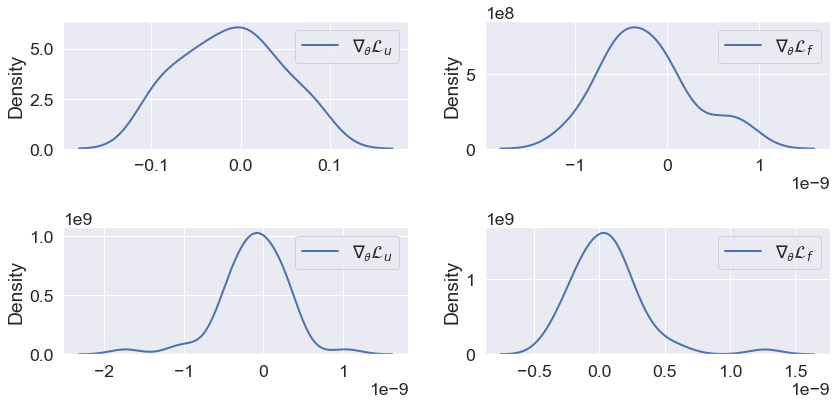

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[0][1][0].numpy().flatten(), linewidth =2, ax = axs[0][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[0][0].legend()


sns.kdeplot(PINN_solver.gradients_log[0][2][0].numpy().flatten(), linewidth =2, ax = axs[0][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[0][1].legend()


sns.kdeplot(PINN_solver.gradients_log[2][1][0].numpy().flatten(), linewidth =2, ax = axs[1][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[1][0].legend()


sns.kdeplot(PINN_solver.gradients_log[2][2][0].numpy().flatten(), linewidth =2, ax = axs[1][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[1][1].legend()

plt.tight_layout()
plt.legend()

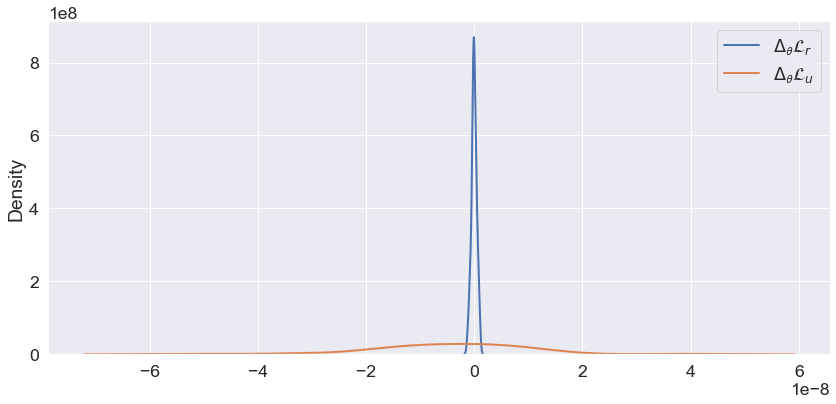

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[1][2][0].numpy().flatten(), ax = axs, linewidth =2,
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

sns.kdeplot(PINN_solver.gradients_log[1][1][0].numpy().flatten(), linewidth =2, ax = axs, 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')

plt.tight_layout()
plt.legend()

### Visualize loss function

In [19]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Loss convergence comparison

In [20]:
iterations_range = np.array(range(len(pinn_pcgrad_loss_log[50000:52000, 1]))) + 50000

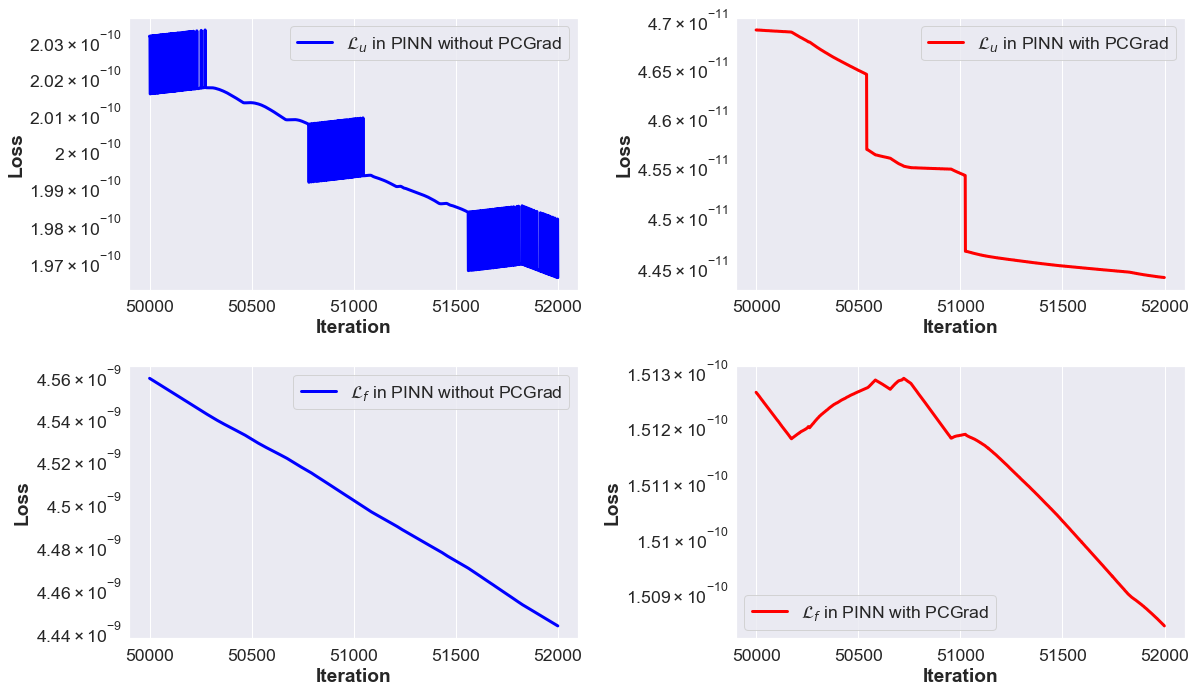

In [21]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 0], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_u$ in PINN without PCGrad', ax = ax[0][0])

ax[0][0].set(yscale="log")
ax[0][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 0], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_u$ in PINN with PCGrad', ax = ax[0][1])

ax[0][1].set(yscale="log")
ax[0][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[0][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 1], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_f$ in PINN without PCGrad', ax = ax[1][0])

ax[1][0].set(yscale="log")
ax[1][0].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][0].set_ylabel("Loss", fontdict=dict(weight='bold'))


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 1], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_f$ in PINN with PCGrad', ax = ax[1][1])

ax[1][1].set(yscale="log")
ax[1][1].set_xlabel("Iteration", fontdict=dict(weight='bold'))
ax[1][1].set_ylabel("Loss", fontdict=dict(weight='bold'))


plt.tight_layout()
plt.savefig('loss_convergence_demonstration_small_homo.pdf')

#### Comparison of loss 

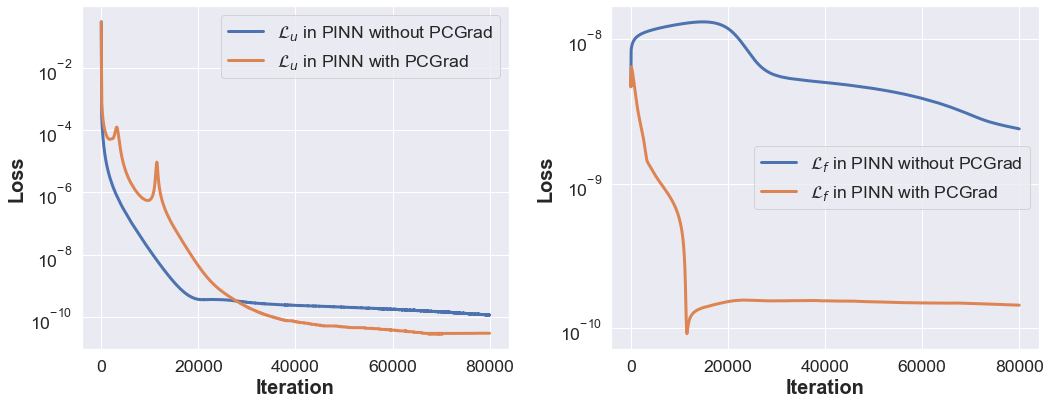

In [22]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[0].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])
axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration", fontdict=dict(weight='bold'), fontsize=20)
axes[1].set_ylabel("Loss", fontdict=dict(weight='bold'), fontsize=20)

plt.tight_layout()
plt.savefig("performance_comparison_small_homo.pdf")

#### Solution quality comparison

In [23]:
matlab_solver_solution_df = pd.read_csv('homo_80000.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [24]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [25]:
matlab_solver_solution_df

,state_0,state_1,state_2
0,0.997940,0.000894,0.001161
1,0.995890,0.001785,0.002321
2,0.993850,0.002673,0.003480
3,0.991800,0.003557,0.004639
4,0.989770,0.004439,0.005796
...,...,...,...
4995,0.000034,0.000575,0.999390
4996,0.000034,0.000574,0.999390
4997,0.000034,0.000573,0.999390
4998,0.000034,0.000572,0.999390


In [26]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 

In [27]:
y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

In [28]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

#### Compare PINN predictions with Matlab solver

In [29]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

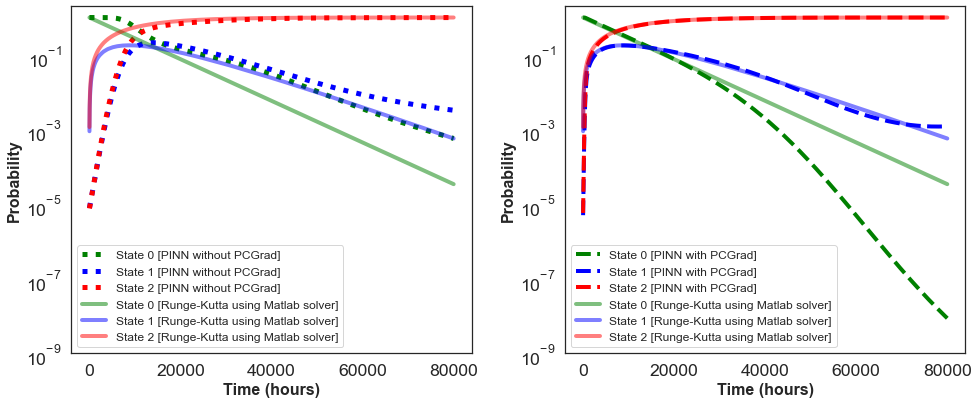

In [30]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0 [PINN without PCGrad]', linewidth = 5, color = 'green', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1 [PINN without PCGrad]', linewidth = 5, color = 'blue', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2 [PINN without PCGrad]', linewidth = 5, color = 'red', 
             linestyle='dotted', ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta using Matlab solver]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta using Matlab solver]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta using Matlab solver]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([1e-9, 2])
ax[0].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'State 0 [PINN with PCGrad]', 
             color = 'green', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'State 1 [PINN with PCGrad]', 
             color = 'blue', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'State 2 [PINN with PCGrad]', 
             color = 'red', linestyle='--', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta using Matlab solver]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta using Matlab solver]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta using Matlab solver]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([1e-9, 2])
ax[1].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_small_homo.pdf")

In [31]:
y_pred_df.tail()

,state_0,state_1,state_2
4995,0.000576,0.003273,0.996151
4996,0.000575,0.003271,0.996154
4997,0.000574,0.003269,0.996157
4998,0.000574,0.003267,0.996159
4999,0.000573,0.003265,0.996162


In [32]:
y_pred_pcgrad_df.tail()

,state_0,state_1,state_2
4995,8.851925e-09,0.001210,0.998790
4996,8.813731e-09,0.001210,0.998790
4997,8.775618e-09,0.001210,0.998789
4998,8.737768e-09,0.001211,0.998789
4999,8.700082e-09,0.001211,0.998789


In [33]:
y_pred_pcgrad_df.loc[:3749]

,state_0,state_1,state_2
0,0.999989,0.000005,0.000006
1,0.999985,0.000007,0.000008
2,0.999979,0.000010,0.000011
3,0.999970,0.000014,0.000016
4,0.999959,0.000019,0.000023
...,...,...,...
3745,0.000005,0.002921,0.997074
3746,0.000005,0.002916,0.997079
3747,0.000005,0.002912,0.997083
3748,0.000005,0.002908,0.997087


In [34]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [35]:
y_diff

,state_0,state_1,state_2
0,-0.002045,0.000886,0.001153
1,-0.004094,0.001777,0.002313
2,-0.006134,0.002665,0.003472
3,-0.008183,0.003549,0.004630
4,-0.010213,0.004430,0.005788
...,...,...,...
4995,-0.000541,-0.002697,0.003239
4996,-0.000541,-0.002696,0.003236
4997,-0.000540,-0.002696,0.003233
4998,-0.000539,-0.002695,0.003231


#### Generate histogram of prediction difference with respect to each state

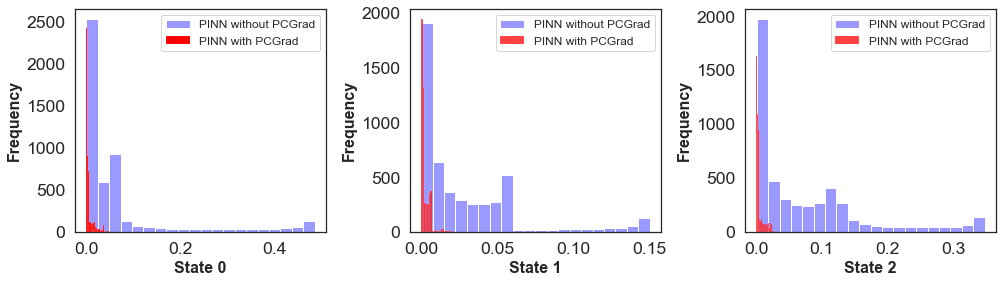

In [36]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff['state_0']), bins=20, ax=axes[0], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_0']), bins=20, ax=axes[0], alpha=1, color='red', label='PINN with PCGrad')
#plt.axvline(x=np.mean(np.abs(y_diff['state_0'])), linewidth=2, linestyle="--", alpha=0.6, 
#            color='blue', label='Mean of no PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['state_1']), bins=20, ax=axes[1], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_1']), bins=20, ax=axes[1], color='red', label='PINN with PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff['state_2']), bins=20, ax=axes[2], alpha=0.4, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_2']), bins=20, ax=axes[2], color='red', label='PINN with PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_homo.pdf")

#### Compare RMSE

In [37]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [38]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.11113877315748705
RMSE of PINN with PCGrad is 0.008288227119764797


In [39]:
(np.mean(y_diff['rmse']) - np.mean(y_diff_pcgrad['rmse']))/np.mean(y_diff['rmse'])

0.9254245221150668

In [40]:
print ('RMSE of PINN without PCGrad before 60000 is', np.mean(y_diff['rmse'][:3749]))
print ('RMSE of PINN with PCGrad before 60000 is', np.mean(y_diff_pcgrad['rmse'][:3749]))

print ('RMSE of PINN without PCGrad after 60000 is', np.mean(y_diff['rmse'][3749:]))
print ('RMSE of PINN with PCGrad after 60000 is', np.mean(y_diff_pcgrad['rmse'][3749:]))

RMSE of PINN without PCGrad before 60000 is 0.14614564637253824
RMSE of PINN with PCGrad before 60000 is 0.010821644732411187
RMSE of PINN without PCGrad after 60000 is 0.00623008596066333
RMSE of PINN with PCGrad after 60000 is 0.0006960747378213706
